In [ ]:
# Szükséges könyvtárak telepítése
!pip install yfinance --quiet
!pip install matplotlib --quiet
!pip install keras-tuner --quiet
!pip install openpyxl --quiet
!pip install scikit-learn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import networkx as nx
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
import keras_tuner as kt
from datetime import datetime, timedelta
import cvxopt
from cvxopt import matrix
import matplotlib.dates as mdates


[                       0%                       ]

Adatok letöltése...


[*********************100%***********************]  10 of 10 completed
<ipython-input-23-f84215fd05d2>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=summary_stats.index, y=summary_stats['Correlation with Nasdaq'], palette="viridis")


Alap metrikák és korrelációk a Nasdaq indexszel:
            Mean  Standard Deviation  Skewness   Kurtosis  \
Ticker                                                      
AAPL    0.001068            0.018158  0.011732   5.268543   
TXN     0.000806            0.017730  0.094546   5.321782   
NVDA    0.002785            0.030495  0.663017   8.804987   
AVGO    0.001525            0.022382  0.008038   7.902660   
ISRG    0.001042            0.019524  0.052423   8.057993   
CSX     0.000654            0.017952  0.818766  20.054985   
EBAY    0.000562            0.018945 -0.110825   7.034768   
MCHP    0.000938            0.023351 -0.086481   6.727347   
TSLA    0.001718            0.035433  0.207916   4.341968   

        Correlation with Nasdaq  
Ticker                           
AAPL                   0.803634  
TXN                    0.762895  
NVDA                   0.724401  
AVGO                   0.711366  
ISRG                   0.693287  
CSX                    0.579824  
EBAY   

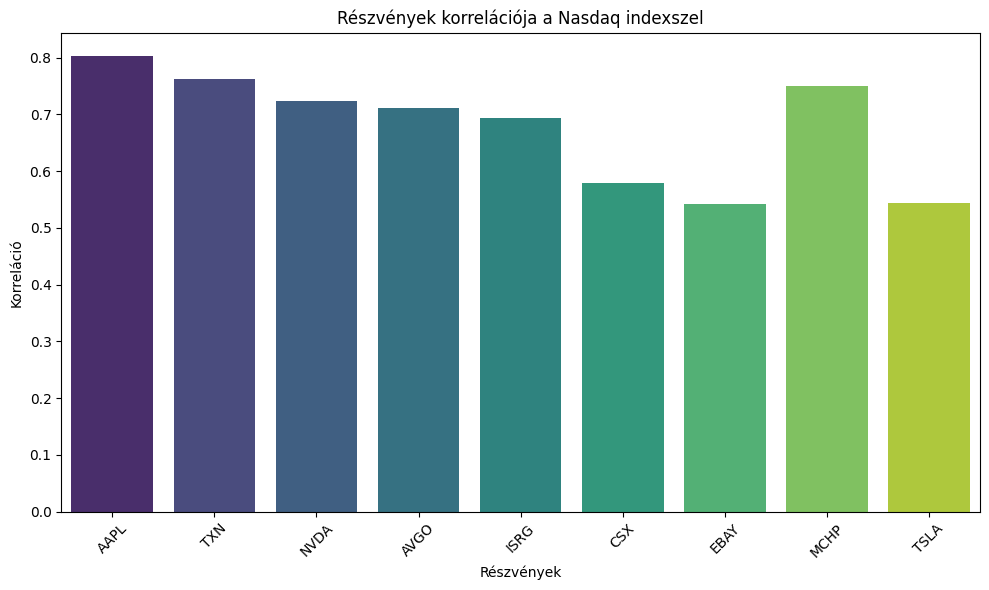

<ipython-input-23-f84215fd05d2>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=summary_stats.index, y=summary_stats['Mean'], ax=axes[0, 0], palette="Blues")
<ipython-input-23-f84215fd05d2>:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(summary_stats.index, rotation=45)
<ipython-input-23-f84215fd05d2>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=summary_stats.index, y=summary_stats['Standard Deviation'], ax=axes[0, 1], palette="Greens")
<ipython-input-23-f84215fd05d2>:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_t

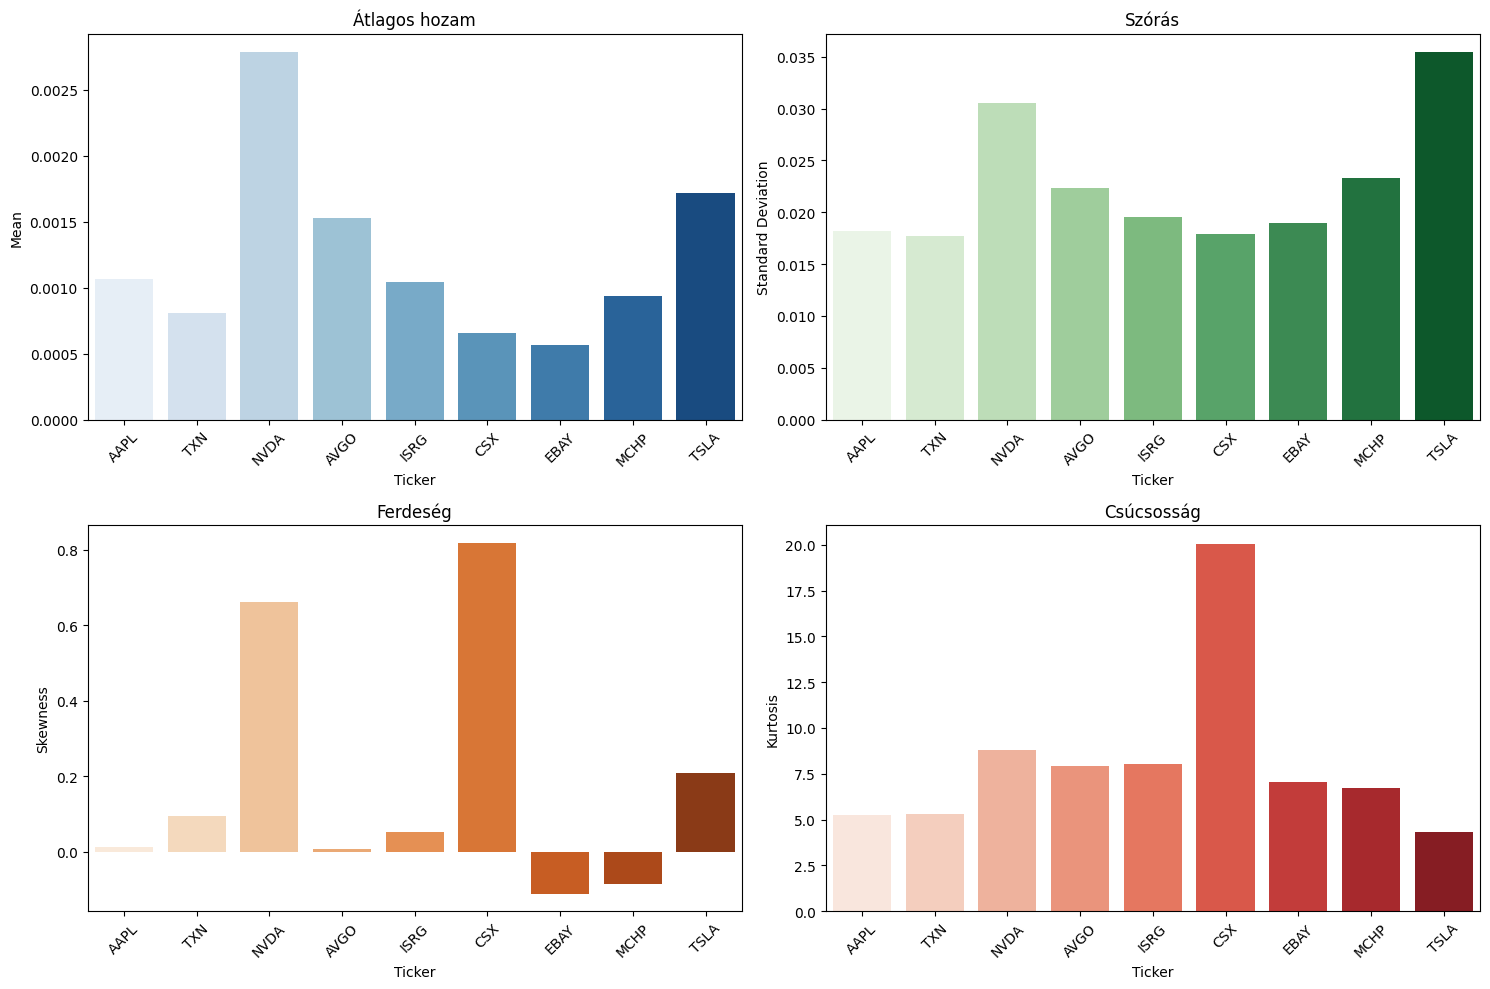

In [ ]:
# Konstansok
START_DATE = '2015-01-01'
END_DATE = '2024-06-30'
TICKERS = ['AAPL', 'TXN', 'NVDA', 'AVGO', 'ISRG', 'CSX', 'EBAY', 'MCHP', 'TSLA']
INDEX = '^IXIC'  # Nasdaq index

# Adatok letöltése
print("Adatok letöltése...")
all_data = yf.download(TICKERS + [INDEX], start=START_DATE, end=END_DATE)['Adj Close']

# Napi hozamok kiszámítása
returns = all_data.pct_change().dropna()

# Alap metrikák kiszámítása
summary_stats = returns[TICKERS].agg(['mean', 'std', 'skew', 'kurtosis']).T
summary_stats.columns = ['Mean', 'Standard Deviation', 'Skewness', 'Kurtosis']

# Korreláció a Nasdaq index-szel
correlations = returns.corrwith(returns[INDEX])
summary_stats['Correlation with Nasdaq'] = correlations[TICKERS]

# Összegző táblázat megjelenítése
print("Alap metrikák és korrelációk a Nasdaq indexszel:")
print(summary_stats)

# Vizualizáció: korreláció a Nasdaq indexszel
plt.figure(figsize=(10, 6))
sns.barplot(x=summary_stats.index, y=summary_stats['Correlation with Nasdaq'], palette="viridis")
plt.title("Részvények korrelációja a Nasdaq indexszel")
plt.ylabel("Korreláció")
plt.xlabel("Részvények")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Vizualizáció: Alap metrikák
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.barplot(x=summary_stats.index, y=summary_stats['Mean'], ax=axes[0, 0], palette="Blues")
axes[0, 0].set_title("Átlagos hozam")
axes[0, 0].set_xticklabels(summary_stats.index, rotation=45)

sns.barplot(x=summary_stats.index, y=summary_stats['Standard Deviation'], ax=axes[0, 1], palette="Greens")
axes[0, 1].set_title("Szórás")
axes[0, 1].set_xticklabels(summary_stats.index, rotation=45)

sns.barplot(x=summary_stats.index, y=summary_stats['Skewness'], ax=axes[1, 0], palette="Oranges")
axes[1, 0].set_title("Ferdeség")
axes[1, 0].set_xticklabels(summary_stats.index, rotation=45)

sns.barplot(x=summary_stats.index, y=summary_stats['Kurtosis'], ax=axes[1, 1], palette="Reds")
axes[1, 1].set_title("Csúcsosság")
axes[1, 1].set_xticklabels(summary_stats.index, rotation=45)

plt.tight_layout()
plt.show()


[                       0%                       ]

Adatok letöltése...


[*********************100%***********************]  10 of 10 completed


Pénzügyi metrikák kiszámítása...
  Ticker      Beta  Sharpe Ratio  Treynor Ratio
0   AAPL  1.082943      0.049506       0.000830
1    TXN  1.003850      0.035890       0.000634
2   NVDA  1.639434      0.085779       0.001595
3   AVGO  1.181635      0.060592       0.001147
4   ISRG  1.004557      0.044678       0.000868
5    CSX  0.772488      0.026975       0.000627
6   EBAY  0.762473      0.020739       0.000515
7   MCHP  1.299378      0.032926       0.000592
8   TSLA  1.429030      0.043714       0.001084


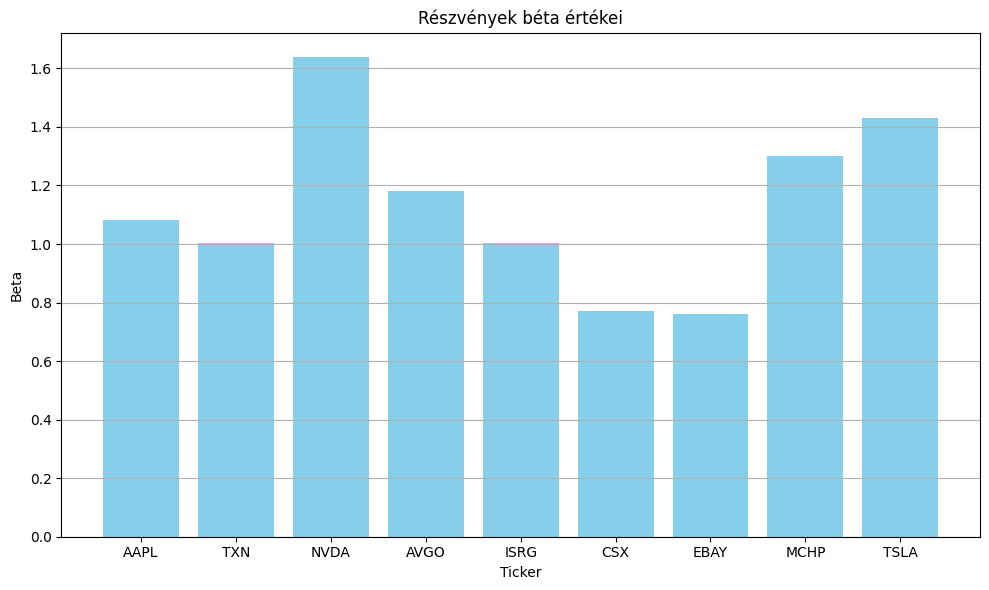

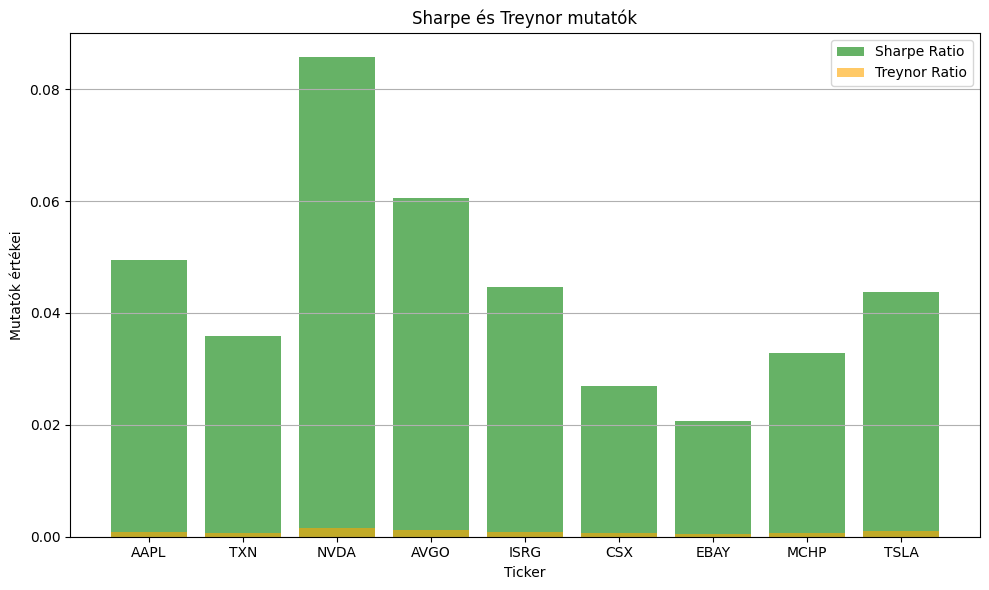

In [ ]:
# Konstansok
START_DATE = '2015-01-01'
END_DATE = '2024-06-30'
TICKERS = ['AAPL', 'TXN', 'NVDA', 'AVGO', 'ISRG', 'CSX', 'EBAY', 'MCHP', 'TSLA']
INDEX = '^IXIC'  # Nasdaq index
RISK_FREE_RATE = 0.0427 / 252  # Napi kockázatmentes hozam (évi 4,27%)

# Béta kiszámítása
def calculate_beta(stock_returns, index_returns):
    covariance = np.cov(stock_returns, index_returns)[0, 1]
    variance = np.var(index_returns)
    beta = covariance / variance
    return beta

# Sharpe-mutató kiszámítása
def calculate_sharpe_ratio(stock_returns):
    excess_returns = stock_returns - RISK_FREE_RATE
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns)
    return sharpe_ratio

# Treynor-mutató kiszámítása
def calculate_treynor_ratio(stock_returns, index_returns):
    beta = calculate_beta(stock_returns, index_returns)
    if beta == 0:
        return np.nan  # Nullával való osztást elkerülünk
    excess_returns = np.mean(stock_returns) - RISK_FREE_RATE
    treynor_ratio = excess_returns / beta
    return treynor_ratio

# Fő függvény: Pénzügyi metrikák kiszámítása
def financial_metrics(data, index_returns):
    metrics = []
    for ticker in TICKERS:
        stock_returns = data[ticker].dropna()
        beta = calculate_beta(stock_returns, index_returns)
        sharpe = calculate_sharpe_ratio(stock_returns)
        treynor = calculate_treynor_ratio(stock_returns, index_returns)
        metrics.append({
            'Ticker': ticker,
            'Beta': beta,
            'Sharpe Ratio': sharpe,
            'Treynor Ratio': treynor
        })
    return pd.DataFrame(metrics)

# Adatok letöltése
print("Adatok letöltése...")
data = yf.download(TICKERS + [INDEX], start=START_DATE, end=END_DATE)['Adj Close']

# Napi hozamok kiszámítása
returns = data.pct_change().dropna()

# Index napi hozamok
index_returns = returns[INDEX]

# Pénzügyi metrikák kiszámítása
print("Pénzügyi metrikák kiszámítása...")
metrics_df = financial_metrics(returns, index_returns)

# Táblázat megjelenítése
print(metrics_df)

# Vizualizáció: Béta értékek
plt.figure(figsize=(10, 6))
plt.bar(metrics_df['Ticker'], metrics_df['Beta'], color='skyblue')
plt.title("Részvények béta értékei")
plt.xlabel("Ticker")
plt.ylabel("Beta")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Vizualizáció: Sharpe és Treynor mutatók
plt.figure(figsize=(10, 6))
plt.bar(metrics_df['Ticker'], metrics_df['Sharpe Ratio'], label='Sharpe Ratio', alpha=0.6, color='green')
plt.bar(metrics_df['Ticker'], metrics_df['Treynor Ratio'], label='Treynor Ratio', alpha=0.6, color='orange')
plt.title("Sharpe és Treynor mutatók")
plt.xlabel("Ticker")
plt.ylabel("Mutatók értékei")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


[                       0%                       ]

Adatok letöltése...


[*********************100%***********************]  9 of 9 completed


Korreláció számítása...

Korrelációs mátrix:
Ticker      AAPL      AVGO       CSX      EBAY      ISRG      MCHP      NVDA  \
Ticker                                                                         
AAPL    1.000000  0.583749  0.457296  0.415452  0.533617  0.574373  0.546345   
AVGO    0.583749  1.000000  0.447554  0.362172  0.480489  0.674320  0.590961   
CSX     0.457296  0.447554  1.000000  0.330731  0.439976  0.489057  0.365904   
EBAY    0.415452  0.362172  0.330731  1.000000  0.371859  0.403200  0.374604   
ISRG    0.533617  0.480489  0.439976  0.371859  1.000000  0.508987  0.498942   
MCHP    0.574373  0.674320  0.489057  0.403200  0.508987  1.000000  0.605315   
NVDA    0.546345  0.590961  0.365904  0.374604  0.498942  0.605315  1.000000   
TSLA    0.425102  0.394852  0.253246  0.298344  0.347067  0.398057  0.402308   
TXN     0.602938  0.677460  0.508106  0.435659  0.515925  0.815671  0.608035   

Ticker      TSLA       TXN  
Ticker                      
AAPL    0.425102

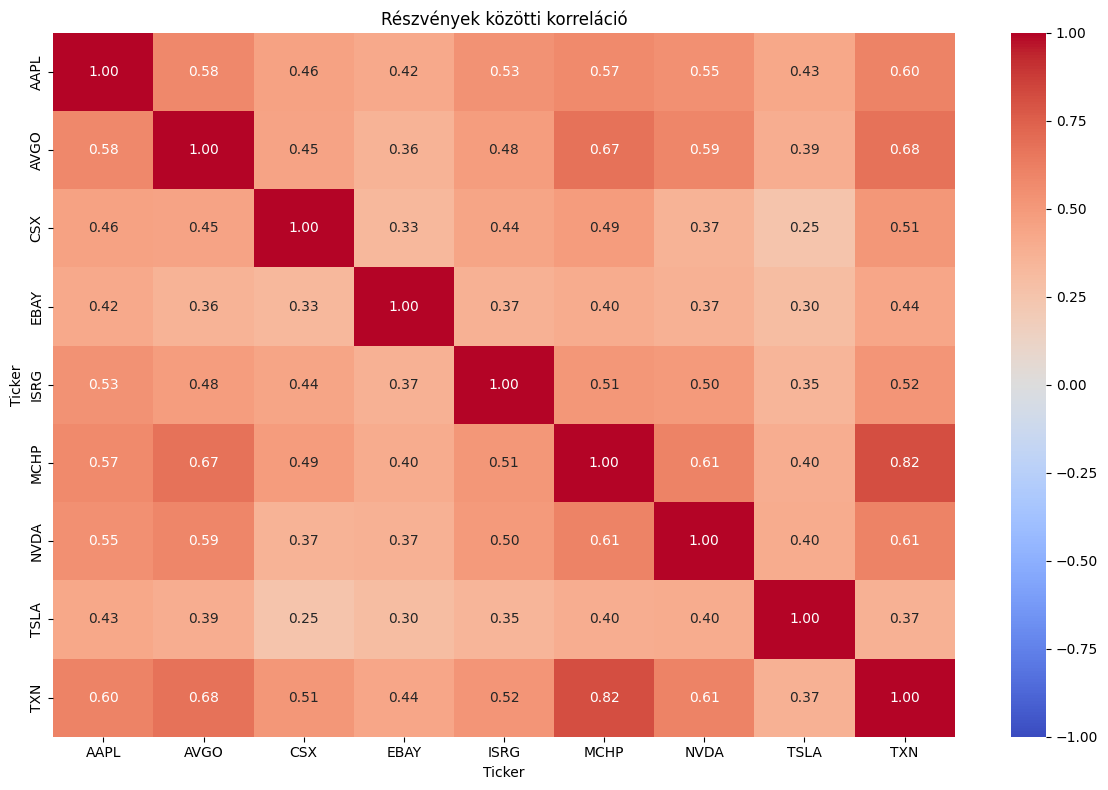

In [ ]:
# Konstansok
START_DATE = '2015-01-01'
END_DATE = '2024-06-30'
TICKERS = ['AAPL', 'TXN', 'NVDA', 'AVGO', 'ISRG', 'CSX', 'EBAY', 'MCHP', 'TSLA']

# Korrelációs mátrix kiszámítása és vizualizáció
def calculate_and_plot_correlation(data):
    # Napi hozamok kiszámítása
    returns = data.pct_change().dropna()

    # Korrelációs mátrix számítása
    correlation_matrix = returns.corr()

    # Korrelációs mátrix megjelenítése
    print("\nKorrelációs mátrix:")
    print(correlation_matrix)

    # Korrelációs mátrix vizualizáció
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
    plt.title("Részvények közötti korreláció")
    plt.tight_layout()
    plt.show()

# Adatok letöltése
print("Adatok letöltése...")
data = yf.download(TICKERS, start=START_DATE, end=END_DATE)['Adj Close']

# Korreláció számítása és vizualizáció
print("Korreláció számítása...")
calculate_and_plot_correlation(data)


[*********************100%***********************]  24 of 24 completed


       Degree  Centrality  Betweenness  Closeness
AAPL       14    0.736842     0.054999   0.760526
ADBE       12    0.631579     0.023949   0.691388
AMZN        8    0.421053     0.094542   0.563353
AVGO        8    0.421053     0.000835   0.563353
CSCO        4    0.210526     0.000000   0.490662
GOOG       11    0.578947     0.016569   0.661327
GOOGL      11    0.578947     0.016569   0.661327
ISRG        9    0.473684     0.000000   0.585020
LRCX       11    0.578947     0.006266   0.633772
MCHP       12    0.631579     0.017962   0.661327
META        6    0.315789     0.000000   0.524501
MSFT       15    0.789474     0.148566   0.800554
NVDA       12    0.631579     0.022835   0.691388
QCOM        7    0.368421     0.000000   0.543233
TXN        13    0.684211     0.111529   0.691388
NFLX        1    0.052632     0.000000   0.353733
CSX         1    0.052632     0.000000   0.400277
JD          1    0.052632     0.000000   0.052632
TCOM        1    0.052632     0.000000   0.052632


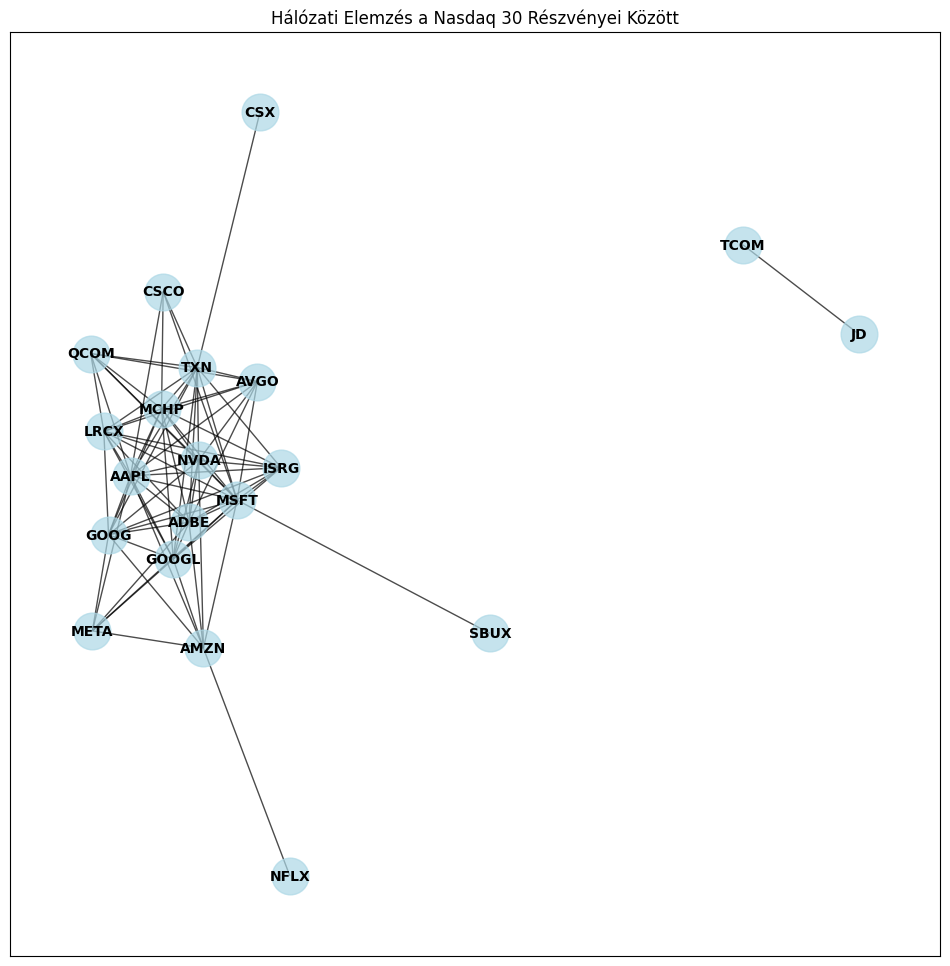

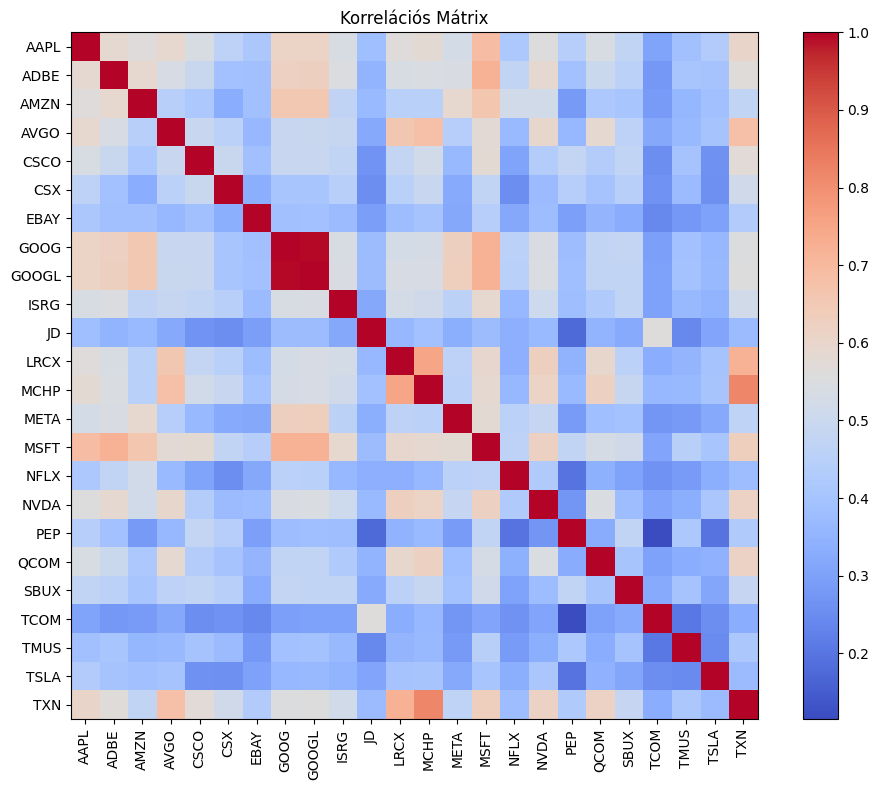

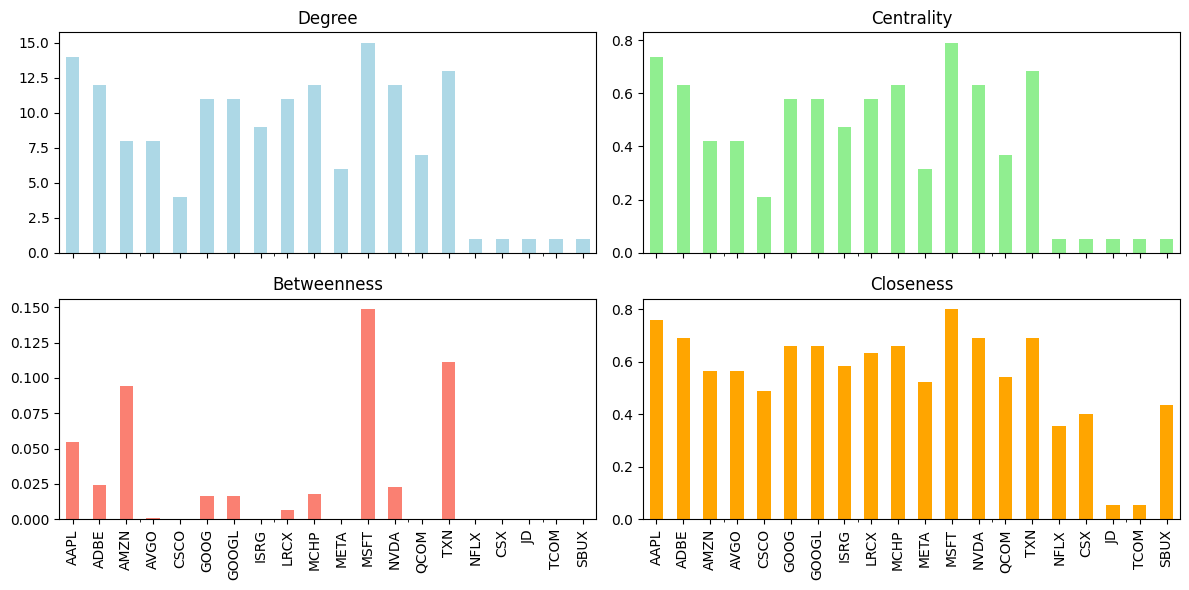

In [ ]:
# A Nasdaq 30 legnagyobb súlyú részvényei és tickerjeik
tickers = [
    'AAPL', 'MSFT', 'AMZN', 'NVDA', 'TSLA', 'GOOGL', 'GOOG', 'META', 'AVGO', 'PEP',
    'TXN', 'LRCX', 'ISRG', 'CSX', 'EBAY', 'MCHP', 'TCOM', 'JD', 'NFLX', 'TMUS',
    'QCOM', 'ADBE', 'CSCO', 'SBUX'
]

# Adatok letöltése
START_DATE = '2015-01-01'
END_DATE = '2024-06-30'

data = yf.download(tickers, start=START_DATE, end=END_DATE)['Adj Close']

# Számoljuk ki a napi hozamokat (logaritmikus hozamok)
log_returns = np.log(data / data.shift(1)).dropna()

# Korrelációs mátrix számítása
correlation_matrix = log_returns.corr()

# Hálózati elemzés
# Készítünk egy gráfot a korrelációk alapján
G = nx.Graph()

# Csatlakoztatjuk a részvényeket a korrelációjuk alapján
threshold = 0.5  # Csak azokat a kapcsolatokat tartjuk, amelyeknek a korrelációja legalább 0.5
for i in correlation_matrix.columns:
    for j in correlation_matrix.columns:
        if i != j and correlation_matrix[i][j] >= threshold:
            G.add_edge(i, j, weight=correlation_matrix[i][j])

# Hálózati metrikák
degree = dict(G.degree())  # Fokszám
centrality = nx.degree_centrality(G)  # Központiság
betweenness = nx.betweenness_centrality(G)  # Közvetítési távolság
closeness = nx.closeness_centrality(G)  # Közvetlen kapcsolat

# Metrikák adatainak táblázatba rendezése
metrics_df = pd.DataFrame({
    'Degree': degree,
    'Centrality': centrality,
    'Betweenness': betweenness,
    'Closeness': closeness
})

# Kiíratjuk a metrikákat
print(metrics_df)

# Hálózat vizualizálása
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5, iterations=50)  # Képletes elrendezés
nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue', alpha=0.7)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
plt.title("Hálózati Elemzés a Nasdaq 30 Részvényei Között")
plt.show()

# Korrelációs mátrix vizualizálása
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title("Korrelációs Mátrix")
plt.tight_layout()
plt.show()

# Hálózati metrikák vizualizálása
metrics_df.plot(kind='bar', figsize=(12, 6), subplots=True, layout=(2, 2), legend=False, color=['lightblue', 'lightgreen', 'salmon', 'orange'])
plt.tight_layout()
plt.show()


[*********************100%***********************]  9 of 9 completed



Hálózati metrikák és szomszédok:

Részvény: AAPL
Szomszédos részvények: ['AVGO', 'ISRG', 'MCHP', 'NVDA', 'TXN']
Kapcsolatok száma: 5
Kapcsolat a AVGO részvénnyel, korreláció: 0.59
Kapcsolat a ISRG részvénnyel, korreláció: 0.54
Kapcsolat a MCHP részvénnyel, korreláció: 0.58
Kapcsolat a NVDA részvénnyel, korreláció: 0.55
Kapcsolat a TXN részvénnyel, korreláció: 0.61

Részvény: AVGO
Szomszédos részvények: ['AAPL', 'MCHP', 'NVDA', 'TXN']
Kapcsolatok száma: 4
Kapcsolat a AAPL részvénnyel, korreláció: 0.59
Kapcsolat a MCHP részvénnyel, korreláció: 0.68
Kapcsolat a NVDA részvénnyel, korreláció: 0.60
Kapcsolat a TXN részvénnyel, korreláció: 0.68

Részvény: ISRG
Szomszédos részvények: ['AAPL', 'MCHP', 'NVDA', 'TXN']
Kapcsolatok száma: 4
Kapcsolat a AAPL részvénnyel, korreláció: 0.54
Kapcsolat a MCHP részvénnyel, korreláció: 0.51
Kapcsolat a NVDA részvénnyel, korreláció: 0.51
Kapcsolat a TXN részvénnyel, korreláció: 0.52

Részvény: MCHP
Szomszédos részvények: ['AAPL', 'AVGO', 'ISRG', 'NVDA', 'T

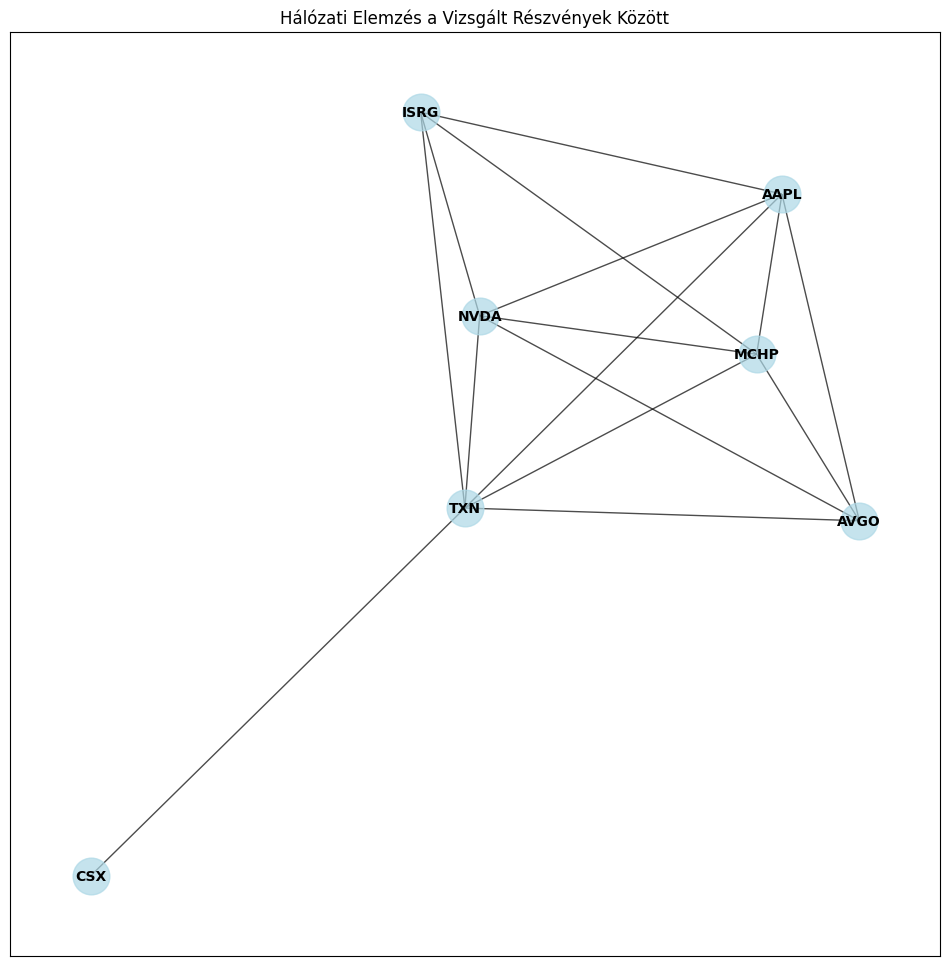

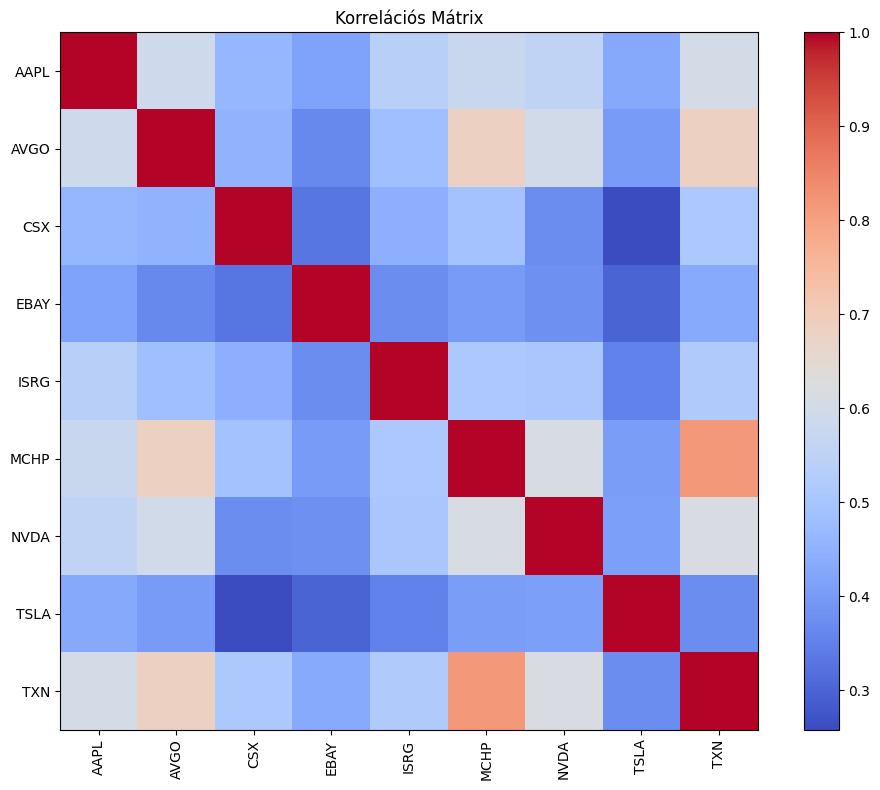

In [ ]:
# Az általunk vizsgált részvények
tickers = ['AAPL', 'TXN', 'NVDA', 'AVGO', 'ISRG', 'CSX', 'EBAY', 'MCHP', 'TSLA']

# Adatok letöltése
START_DATE = '2015-01-01'
END_DATE = '2024-06-30'

data = yf.download(tickers, start=START_DATE, end=END_DATE)['Adj Close']

# Számoljuk ki a napi hozamokat (logaritmikus hozamok)
log_returns = np.log(data / data.shift(1)).dropna()

# Korrelációs mátrix számítása
correlation_matrix = log_returns.corr()

# Hálózati elemzés
# Készítünk egy gráfot a korrelációk alapján
G = nx.Graph()

# Csatlakoztatjuk a részvényeket a korrelációjuk alapján
threshold = 0.5  # Csak azokat a kapcsolatokat tartjuk, amelyeknek a korrelációja legalább 0.5
for i in correlation_matrix.columns:
    for j in correlation_matrix.columns:
        if i != j and correlation_matrix[i][j] >= threshold:
            G.add_edge(i, j, weight=correlation_matrix[i][j])

# Kinyomtatjuk a hálózati metrikákat és éleket
print("\nHálózati metrikák és szomszédok:")
for node in G.nodes():
    neighbors = list(G.neighbors(node))  # A csomópont szomszédai
    print(f"\nRészvény: {node}")
    print(f"Szomszédos részvények: {neighbors}")
    print(f"Kapcsolatok száma: {len(neighbors)}")

    # Részletes információk az élekről
    for neighbor in neighbors:
        edge_data = G.get_edge_data(node, neighbor)
        print(f"Kapcsolat a {neighbor} részvénnyel, korreláció: {edge_data['weight']:.2f}")

# Hálózati vizualizálás csak a megadott részvényekre
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5, iterations=50)  # Képletes elrendezés
nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue', alpha=0.7)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
plt.title("Hálózati Elemzés a Vizsgált Részvények Között")
plt.show()

# Korrelációs mátrix vizualizálása
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title("Korrelációs Mátrix")
plt.tight_layout()
plt.show()


[*********************100%***********************]  1 of 1 completed

Epoch 1/50



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0228 - mae: 0.1212 - val_loss: 0.1068 - val_mae: 0.3122
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0055 - mae: 0.0660 - val_loss: 0.0317 - val_mae: 0.1707
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - mae: 0.0313 - val_loss: 0.0039 - val_mae: 0.0548
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.3940e-04 - mae: 0.0083 - val_loss: 0.0021 - val_mae: 0.0388
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3439e-04 - mae: 0.0083 - val_loss: 0.0024 - val_mae: 0.0419
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4348e-04 - mae: 0.0085 - val_loss: 0.0017 - val_mae: 0.0340
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.4216e-04 - mae: 0.0085 - val_loss: 0.0017 - val_mae: 0.0345
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5698e-04 - mae: 0.0084 - val_loss: 0.0018 - val_mae: 0.0355
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.18

Model saved as 'best_stock_model.h5'.
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


[*********************100%***********************]  1 of 1 completed


=== Model Evaluation Metrics ===
Test MSE: 0.000218
Test MAE: 0.155888
Test R²: 0.988415
Minimum Validation Loss: 0.000129
Processing AAPL...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


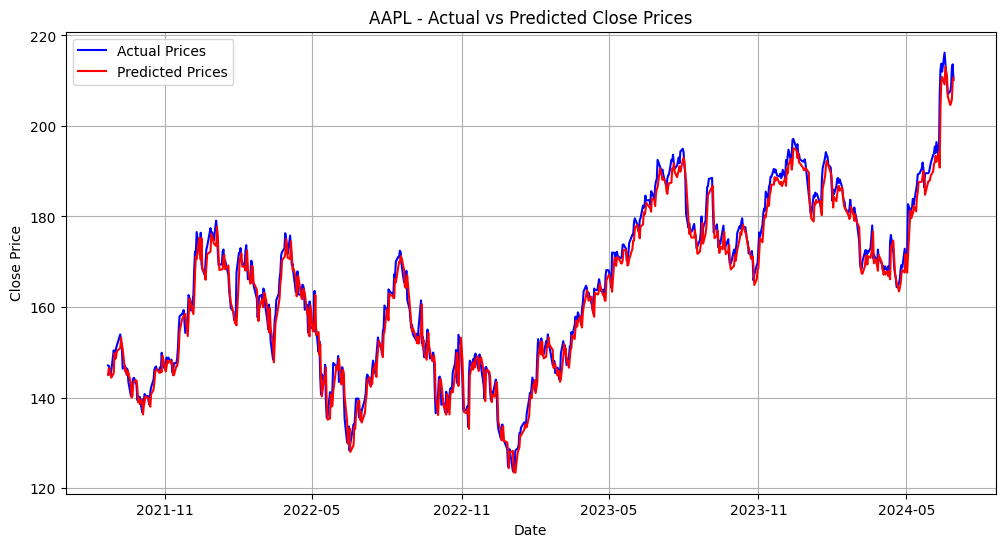

[*********************100%***********************]  1 of 1 completed

Processing TXN...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


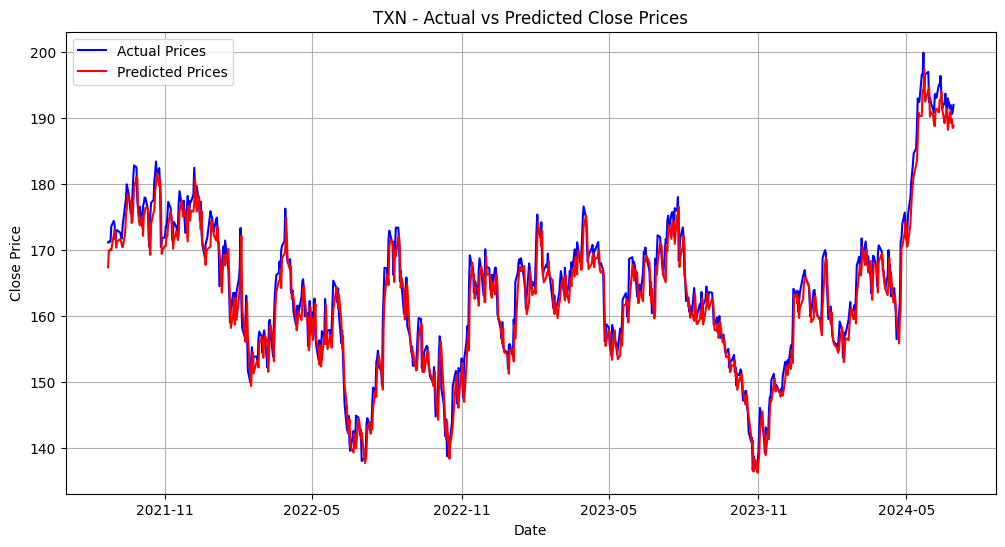

[*********************100%***********************]  1 of 1 completed

Processing NVDA...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


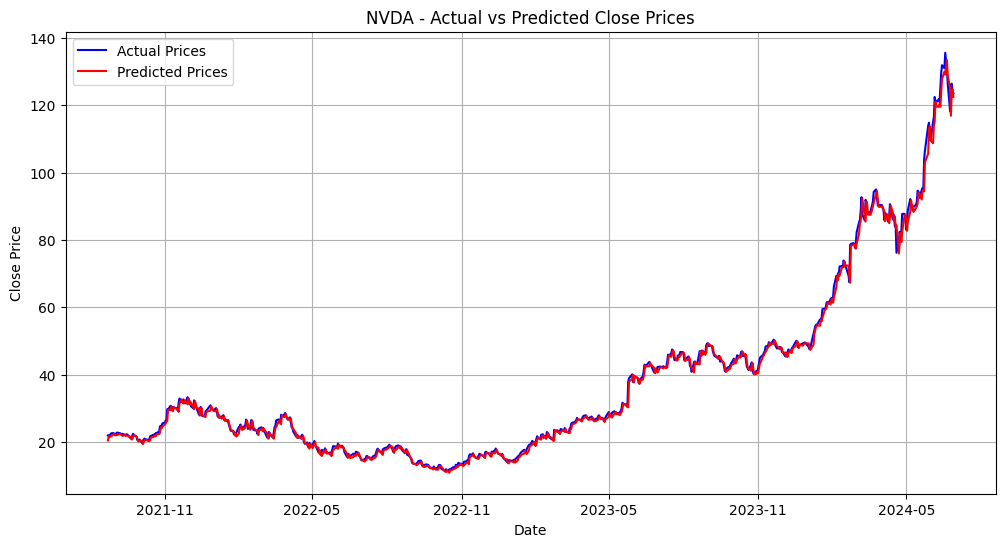

[*********************100%***********************]  1 of 1 completed

Processing AVGO...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


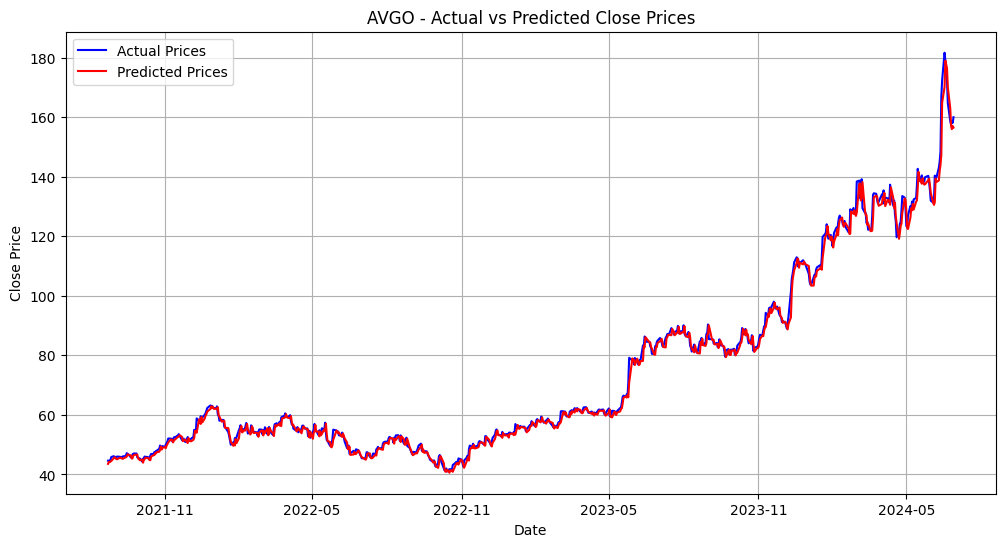

[*********************100%***********************]  1 of 1 completed

Processing ISRG...


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


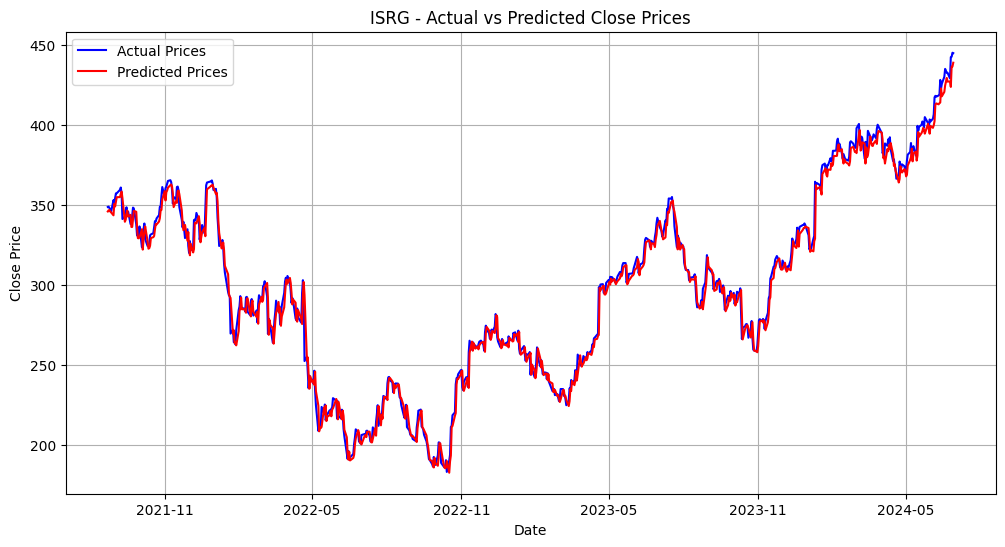

[*********************100%***********************]  1 of 1 completed

Processing CSX...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


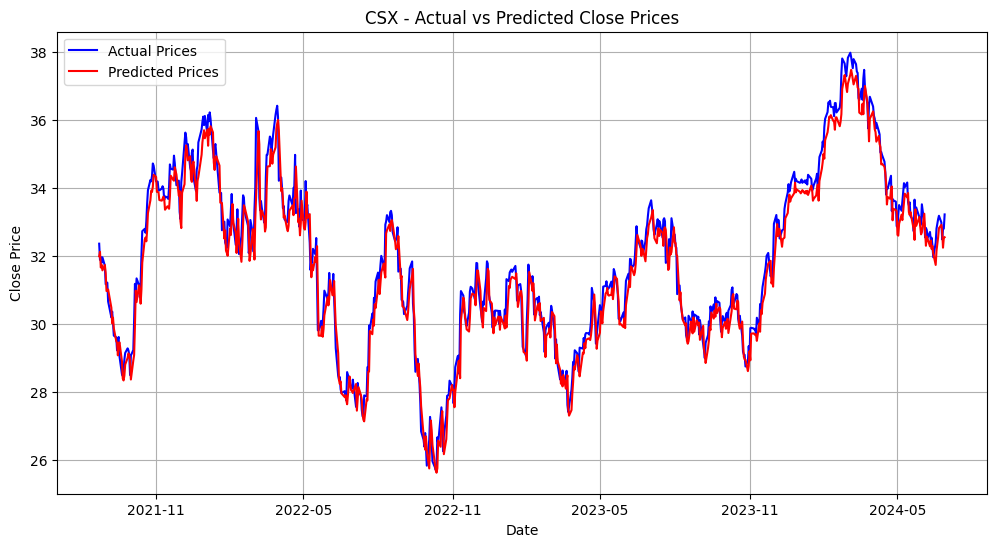

[*********************100%***********************]  1 of 1 completed

Processing EBAY...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


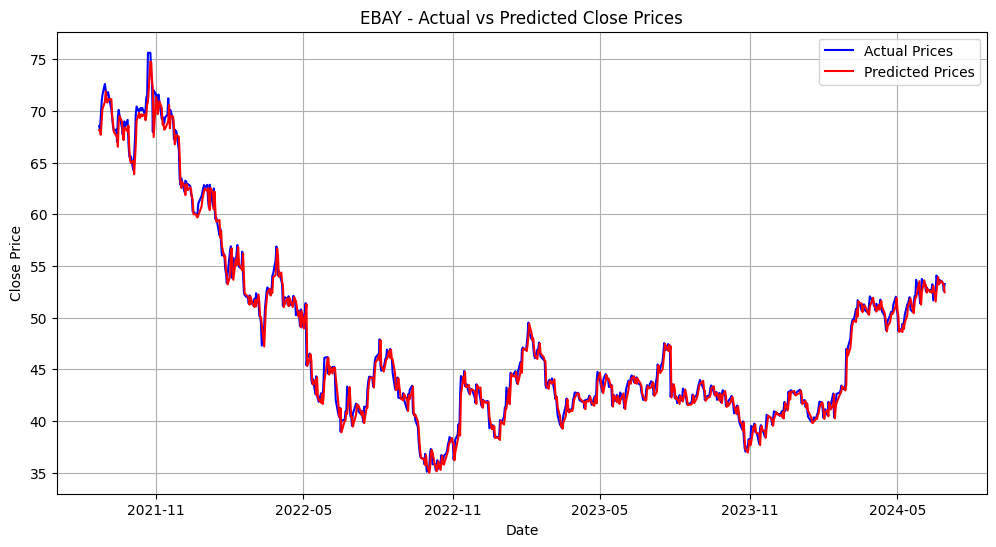

[*********************100%***********************]  1 of 1 completed

Processing MCHP...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


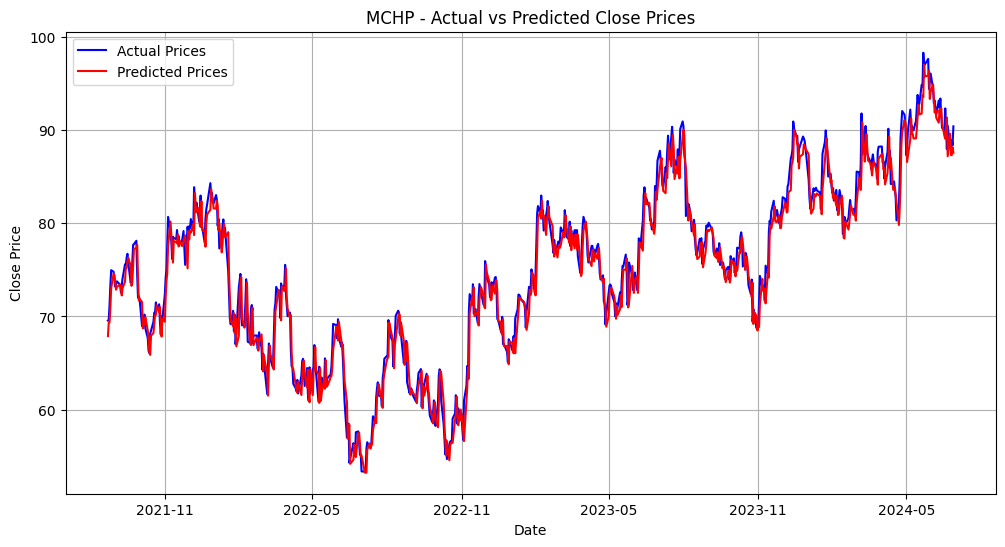

[*********************100%***********************]  1 of 1 completed

Processing TSLA...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


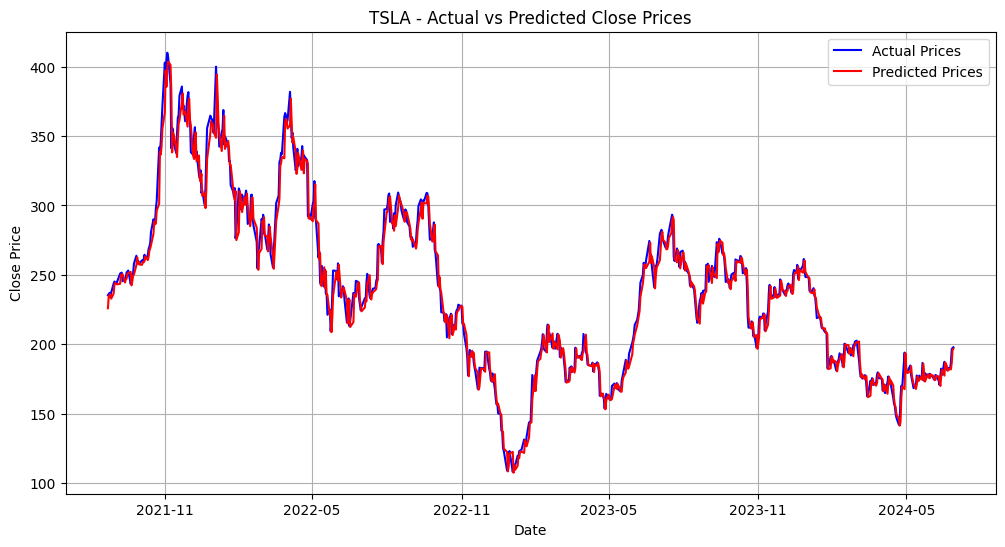

In [ ]:
# Konstansok
TICKERS = ['AAPL', 'TXN', 'NVDA', 'AVGO', 'ISRG', 'CSX', 'EBAY', 'MCHP', 'TSLA']
START_DATE = '2015-01-01'

# A legközelebbi hétfő dátuma
def get_next_monday(today):
    days_until_monday = 0 - today.weekday()  # Hétfő: 0
    if days_until_monday <= 0:  # Ha már hétfő van, akkor a következő hétfő
        days_until_monday += 7
    return today + timedelta(days=days_until_monday)

# Mai dátum
today = datetime.today()

# Következő péntek dátuma
END_DATE = get_next_monday(today).strftime('%Y-%m-%d')

# Adatok letöltése
def download_data(ticker, start=START_DATE, end='2024-06-30'):
    try:
        data = yf.download(ticker, start=start, end=end)[['Adj Close', 'Volume']].dropna()
        data.index = pd.to_datetime(data.index)  # Győződj meg róla, hogy az index datetime formátumú
        return data
    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")
        return None

# Adatok előkészítése
def prepare_data(data, time_steps=1, train_ratio=0.7):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data[['Adj Close', 'Volume']])

    X, y, dates = [], [], []
    for i in range(len(data_scaled) - time_steps):
        X.append(data_scaled[i:i+time_steps])
        y.append(data_scaled[i+time_steps, 0])  # Csak a Close célváltozóként
        dates.append(data.index[i+time_steps])

    X, y = np.array(X), np.array(y)
    split = int(len(X) * train_ratio)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    dates_train, dates_test = dates[:split], dates[split:]

    return X_train, X_test, y_train, y_test, scaler, dates_train, dates_test


# LSTM modell építése a megadott hiperparaméterekkel
def build_model(units1=32, units2=64, learning_rate=0.001):
    model = Sequential([
        LSTM(units=units1, return_sequences=True, input_shape=(1, 2)),
        Dropout(0.1),
        LSTM(units=units2),
        Dropout(0.1),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model

# NASDAQ adatok letöltése és modell építése
ndx_data = download_data('^IXIC')
if ndx_data is not None:
    X_train, X_test, y_train, y_test, scaler, dates_train, dates_test = prepare_data(ndx_data)

    # Modell felépítése a megadott hiperparaméterekkel
    model = build_model(units1=64, units2=128, learning_rate=0.001)

    # NASDAQ modellen való edzés
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

    # Modell mentése
    model.save('best_stock_model.h5')
    print("Model saved as 'best_stock_model.h5'.")

    # Modell kiértékelése
    y_pred = model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred)
    test_mae = np.mean(np.abs(y_test - y_pred))  # MAE számítása
    test_r2 = r2_score(y_test, y_pred)
    val_loss = min(history.history['val_loss'])

    print("\n=== Model Evaluation Metrics ===")
    print(f"Test MSE: {test_mse:.6f}")
    print(f"Test MAE: {test_mae:.6f}")
    print(f"Test R²: {test_r2:.6f}")
    print(f"Minimum Validation Loss: {val_loss:.6f}")

else:
    print("Failed to download NASDAQ data. Exiting.")

# Az optimalizált modell alkalmazása az összes részvényre
for ticker in TICKERS:
    print(f"Processing {ticker}...")
    stock_data = download_data(ticker)
    if stock_data is not None:
        # Adatok előkészítése
        _, X_test, _, y_test, scaler, _, dates_test = prepare_data(stock_data)

        # Teszt predikciók
        y_pred = model.predict(X_test)

        # Visszaskálázás az eredeti értékekre
        y_test_rescaled = scaler.inverse_transform(np.column_stack((y_test, np.zeros_like(y_test))))[:, 0]
        y_pred_rescaled = scaler.inverse_transform(np.column_stack((y_pred, np.zeros_like(y_pred.flatten()))))[:, 0]

        # Grafikon rajzolása dátumokkal
        plt.figure(figsize=(12, 6))
        plt.plot(dates_test, y_test_rescaled, label='Actual Prices', color='blue')
        plt.plot(dates_test, y_pred_rescaled, label='Predicted Prices', color='red')
        plt.title(f"{ticker} - Actual vs Predicted Close Prices")
        plt.xlabel("Date")
        plt.ylabel("Close Price")

        # Dátumformátum beállítása a vízszintes tengelyen
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Év-hónap formátum
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # 2 havonta jelenjen meg

        plt.legend()
        plt.grid()
        plt.show()

    else:
        print(f"No data for {ticker}, skipping...")


In [ ]:
# Pénteki záróárfolyamok és forgalom letöltése
def download_friday_closes_and_volume(tickers, start_date='2024-06-28', end_date=END_DATE):
    # Pénteki dátumok generálása
    friday_dates = pd.date_range(start=start_date, end=end_date, freq='W-FRI')
    data_dict = {}

    for ticker in tickers:
        print(f"Letöltés: {ticker}...")
        closes, volumes = [], []
        for date in friday_dates:
            try:
                # Adatok letöltése az adott péntekhez
                data = yf.download(ticker, start=date.strftime('%Y-%m-%d'),
                                   end=(date + pd.Timedelta(days=1)).strftime('%Y-%m-%d'), progress=False)
                if not data.empty:
                    closes.append(float(data['Adj Close'].iloc[-1]))
                    volumes.append(float(data['Volume'].iloc[-1]))
                else:
                    closes.append(None)
                    volumes.append(None)
            except Exception as e:
                print(f"Hiba {ticker} letöltésekor ({date}): {e}")
                closes.append(None)
                volumes.append(None)

        # Adatok mentése DataFrame-be
        data_dict[ticker] = pd.DataFrame({
            'Date': friday_dates.strftime('%Y-%m-%d'),
            'Close': closes,
            'Volume': volumes
        })

    return data_dict

# Tickers lista
tickers = ['AAPL', 'TXN', 'NVDA', 'AVGO', 'ISRG', 'CSX', 'EBAY', 'MCHP', 'TSLA']

# Adatok letöltése
data_dict = download_friday_closes_and_volume(tickers)

# Mentés Excel fájlba
output_file = 'close_2024.xlsx'
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    for ticker, df in data_dict.items():
        df.to_excel(writer, sheet_name=ticker, index=False)

print(f"Pénteki záróárfolyamok elmentve: {output_file}")



Letöltés: AAPL...


<ipython-input-29-481e3e02cdf4>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-29-481e3e02cdf4>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-29-481e3e02cdf4>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-29-481e3e02cdf4>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-29-481e3e02cdf4>:16: FutureWarning: Calling float on a single element

Letöltés: TXN...


<ipython-input-29-481e3e02cdf4>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-29-481e3e02cdf4>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-29-481e3e02cdf4>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-29-481e3e02cdf4>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-29-481e3e02cdf4>:16: FutureWarning: Calling float on a single element

Letöltés: NVDA...


<ipython-input-29-481e3e02cdf4>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-29-481e3e02cdf4>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-29-481e3e02cdf4>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-29-481e3e02cdf4>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-29-481e3e02cdf4>:16: FutureWarning: Calling float on a single element

Letöltés: AVGO...


<ipython-input-29-481e3e02cdf4>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-29-481e3e02cdf4>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-29-481e3e02cdf4>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-29-481e3e02cdf4>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-29-481e3e02cdf4>:16: FutureWarning: Calling float on a single element

Letöltés: ISRG...


<ipython-input-29-481e3e02cdf4>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-29-481e3e02cdf4>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-29-481e3e02cdf4>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-29-481e3e02cdf4>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-29-481e3e02cdf4>:16: FutureWarning: Calling float on a single element

Letöltés: CSX...


<ipython-input-29-481e3e02cdf4>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-29-481e3e02cdf4>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-29-481e3e02cdf4>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-29-481e3e02cdf4>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-29-481e3e02cdf4>:16: FutureWarning: Calling float on a single element

Letöltés: EBAY...


<ipython-input-29-481e3e02cdf4>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-29-481e3e02cdf4>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-29-481e3e02cdf4>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-29-481e3e02cdf4>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-29-481e3e02cdf4>:16: FutureWarning: Calling float on a single element

Letöltés: MCHP...


<ipython-input-29-481e3e02cdf4>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-29-481e3e02cdf4>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-29-481e3e02cdf4>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-29-481e3e02cdf4>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-29-481e3e02cdf4>:16: FutureWarning: Calling float on a single element

Letöltés: TSLA...


<ipython-input-29-481e3e02cdf4>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-29-481e3e02cdf4>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-29-481e3e02cdf4>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-29-481e3e02cdf4>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-29-481e3e02cdf4>:16: FutureWarning: Calling float on a single element

Pénteki záróárfolyamok elmentve: close_2024.xlsx


<ipython-input-29-481e3e02cdf4>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-29-481e3e02cdf4>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-29-481e3e02cdf4>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-29-481e3e02cdf4>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-29-481e3e02cdf4>:16: FutureWarning: Calling float on a single element

In [ ]:
# Pénteki záróárfolyamok és forgalom letöltése IXIC-re
def download_ixic_friday_closes_and_volume(start_date='2024-06-28', end_date=END_DATE):
    # Pénteki dátumok generálása
    friday_dates = pd.date_range(start=start_date, end=end_date, freq='W-FRI')
    closes, volumes = [], []

    for date in friday_dates:
        try:
            # Adatok letöltése az adott péntekhez
            data = yf.download('^IXIC', start=date.strftime('%Y-%m-%d'),
                               end=(date + pd.Timedelta(days=1)).strftime('%Y-%m-%d'), progress=False)
            if not data.empty:
                closes.append(float(data['Adj Close'].iloc[-1]))
                volumes.append(float(data['Volume'].iloc[-1]))
            else:
                closes.append(None)
                volumes.append(None)
        except Exception as e:
            print(f"Hiba IXIC letöltésekor ({date}): {e}")
            closes.append(None)
            volumes.append(None)

    # Adatok DataFrame-be rendezése
    ixic_df = pd.DataFrame({
        'Date': friday_dates.strftime('%Y-%m-%d'),
        'Close': closes,
        'Volume': volumes
    })

    return ixic_df

# IXIC adatok letöltése
ixic_data = download_ixic_friday_closes_and_volume()

# Mentés Excel fájlba
output_file = 'ixic_friday_closes_2024.xlsx'
ixic_data.to_excel(output_file, index=False, engine='openpyxl')

print(f"IXIC pénteki záróárfolyamok elmentve: {output_file}")


<ipython-input-30-6adee821a307>:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-30-6adee821a307>:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-30-6adee821a307>:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-30-6adee821a307>:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-30-6adee821a307>:13: FutureWarning: Calling float on a single element

IXIC pénteki záróárfolyamok elmentve: ixic_friday_closes_2024.xlsx


<ipython-input-30-6adee821a307>:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-30-6adee821a307>:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-30-6adee821a307>:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-30-6adee821a307>:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))


In [ ]:
# Hétfői záróárfolyamok és forgalom letöltése
def download_monday_closes_and_volume(tickers, start_date='2024-06-28', end_date=END_DATE):
    # Hétfői dátumok generálása
    monday_dates = pd.date_range(start=start_date, end=end_date, freq='W-MON')
    data_dict = {}

    for ticker in tickers:
        print(f"Letöltés: {ticker}... (Hétfői adatok)")
        closes, volumes = [], []
        for date in monday_dates:
            try:
                # Adatok letöltése az adott hétfőhöz
                data = yf.download(ticker, start=date.strftime('%Y-%m-%d'),
                                   end=(date + pd.Timedelta(days=1)).strftime('%Y-%m-%d'), progress=False)
                if not data.empty:
                    closes.append(float(data['Adj Close'].iloc[-1]))
                    volumes.append(float(data['Volume'].iloc[-1]))
                else:
                    closes.append(None)
                    volumes.append(None)
            except Exception as e:
                print(f"Hiba {ticker} letöltésekor ({date}): {e}")
                closes.append(None)
                volumes.append(None)

        # Adatok mentése DataFrame-be
        data_dict[ticker] = pd.DataFrame({
            'Date': monday_dates.strftime('%Y-%m-%d'),
            'Close': closes,
            'Volume': volumes
        })

    return data_dict

# Tickers lista
tickers = ['AAPL', 'TXN', 'NVDA', 'AVGO', 'ISRG', 'CSX', 'EBAY', 'MCHP', 'TSLA']

# Adatok letöltése hétfői dátumokra
data_dict = download_monday_closes_and_volume(tickers)

# Mentés Excel fájlba
output_file = 'close_mondays_2024.xlsx'
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    for ticker, df in data_dict.items():
        df.to_excel(writer, sheet_name=ticker, index=False)

print(f"Hétfői záróárfolyamok elmentve: {output_file}")


Letöltés: AAPL... (Hétfői adatok)


<ipython-input-31-ba6c823c68b7>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-31-ba6c823c68b7>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-31-ba6c823c68b7>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-31-ba6c823c68b7>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-31-ba6c823c68b7>:16: FutureWarning: Calling float on a single element

Letöltés: TXN... (Hétfői adatok)


<ipython-input-31-ba6c823c68b7>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-31-ba6c823c68b7>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-31-ba6c823c68b7>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-31-ba6c823c68b7>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-31-ba6c823c68b7>:16: FutureWarning: Calling float on a single element

Letöltés: NVDA... (Hétfői adatok)


<ipython-input-31-ba6c823c68b7>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-31-ba6c823c68b7>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-31-ba6c823c68b7>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-31-ba6c823c68b7>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-31-ba6c823c68b7>:16: FutureWarning: Calling float on a single element

Letöltés: AVGO... (Hétfői adatok)


<ipython-input-31-ba6c823c68b7>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-31-ba6c823c68b7>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-31-ba6c823c68b7>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-31-ba6c823c68b7>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-31-ba6c823c68b7>:16: FutureWarning: Calling float on a single element

Letöltés: ISRG... (Hétfői adatok)


<ipython-input-31-ba6c823c68b7>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-31-ba6c823c68b7>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-31-ba6c823c68b7>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-31-ba6c823c68b7>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-31-ba6c823c68b7>:16: FutureWarning: Calling float on a single element

Letöltés: CSX... (Hétfői adatok)


<ipython-input-31-ba6c823c68b7>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-31-ba6c823c68b7>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-31-ba6c823c68b7>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-31-ba6c823c68b7>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-31-ba6c823c68b7>:16: FutureWarning: Calling float on a single element

Letöltés: EBAY... (Hétfői adatok)


<ipython-input-31-ba6c823c68b7>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-31-ba6c823c68b7>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-31-ba6c823c68b7>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-31-ba6c823c68b7>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-31-ba6c823c68b7>:16: FutureWarning: Calling float on a single element

Letöltés: MCHP... (Hétfői adatok)


<ipython-input-31-ba6c823c68b7>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-31-ba6c823c68b7>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-31-ba6c823c68b7>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-31-ba6c823c68b7>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-31-ba6c823c68b7>:16: FutureWarning: Calling float on a single element

Letöltés: TSLA... (Hétfői adatok)


<ipython-input-31-ba6c823c68b7>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-31-ba6c823c68b7>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-31-ba6c823c68b7>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-31-ba6c823c68b7>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-31-ba6c823c68b7>:16: FutureWarning: Calling float on a single element

Hétfői záróárfolyamok elmentve: close_mondays_2024.xlsx


In [ ]:
def download_monday_closes_and_volume(tickers, start_date='2023-01-01', end_date='2024-12-31'):
    # Hétfői dátumok generálása
    monday_dates = pd.date_range(start=start_date, end=end_date, freq='W-MON')
    data_dict = {}

    for ticker in tickers:
        print(f"Letöltés: {ticker}... (Hétfői adatok, ha elérhető)")
        closes, volumes, dates = [], [], []
        for date in monday_dates:
            try:
                # Próbálja lekérni hétfői adatokat
                data = yf.download(ticker, start=date.strftime('%Y-%m-%d'),
                                   end=(date + pd.Timedelta(days=1)).strftime('%Y-%m-%d'), progress=False)
                if not data.empty:
                    closes.append(float(data['Adj Close'].iloc[-1]))
                    volumes.append(float(data['Volume'].iloc[-1]))
                    dates.append(date)
                else:
                    # Ha hétfői adat nincs, próbálja keddit
                    tuesday = date + pd.Timedelta(days=1)
                    data_tuesday = yf.download(ticker, start=tuesday.strftime('%Y-%m-%d'),
                                               end=(tuesday + pd.Timedelta(days=1)).strftime('%Y-%m-%d'), progress=False)
                    if not data_tuesday.empty:
                        closes.append(float(data_tuesday['Adj Close'].iloc[-1]))
                        volumes.append(float(data_tuesday['Volume'].iloc[-1]))
                        dates.append(tuesday)
                    else:
                        # Ha keddi sincs, None értékeket ad
                        closes.append(None)
                        volumes.append(None)
                        dates.append(date)
            except Exception as e:
                print(f"Hiba {ticker} letöltésekor ({date}): {e}")
                closes.append(None)
                volumes.append(None)
                dates.append(date)

        # Adatok mentése DataFrame-be
        data_dict[ticker] = pd.DataFrame({
            'Date': [d.strftime('%Y-%m-%d') for d in dates],
            'Close': closes,
            'Volume': volumes
        })

    return data_dict

# Tickers lista
tickers = ['AAPL', 'TXN', 'NVDA', 'AVGO', 'ISRG', 'CSX', 'EBAY', 'MCHP', 'TSLA']

# Adatok letöltése hétfői (vagy keddi) dátumokra
data_dict = download_monday_closes_and_volume(tickers)

# Mentés Excel fájlba
output_file = 'close_mondays_2023-2024.xlsx'
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    for ticker, df in data_dict.items():
        df.to_excel(writer, sheet_name=ticker, index=False)

print(f"Hétfői és szükség esetén keddi záróárfolyamok elmentve: {output_file}")


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2023-01-02 -> 2023-01-03)')


Letöltés: AAPL... (Hétfői adatok, ha elérhető)


<ipython-input-32-721ed9ccf5b4>:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data_tuesday['Adj Close'].iloc[-1]))
<ipython-input-32-721ed9ccf5b4>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data_tuesday['Volume'].iloc[-1]))
<ipython-input-32-721ed9ccf5b4>:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-32-721ed9ccf5b4>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPrices

Letöltés: TXN... (Hétfői adatok, ha elérhető)


<ipython-input-32-721ed9ccf5b4>:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data_tuesday['Adj Close'].iloc[-1]))
<ipython-input-32-721ed9ccf5b4>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data_tuesday['Volume'].iloc[-1]))
<ipython-input-32-721ed9ccf5b4>:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-32-721ed9ccf5b4>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TXN']: YFPricesM

Letöltés: NVDA... (Hétfői adatok, ha elérhető)


<ipython-input-32-721ed9ccf5b4>:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data_tuesday['Adj Close'].iloc[-1]))
<ipython-input-32-721ed9ccf5b4>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data_tuesday['Volume'].iloc[-1]))
<ipython-input-32-721ed9ccf5b4>:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-32-721ed9ccf5b4>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NVDA']: YFPrices

Letöltés: AVGO... (Hétfői adatok, ha elérhető)


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AVGO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2023-01-16 -> 2023-01-17)')
<ipython-input-32-721ed9ccf5b4>:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data_tuesday['Adj Close'].iloc[-1]))
<ipython-input-32-721ed9ccf5b4>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data_tuesday['Volume'].iloc[-1]))
<ipython-input-32-721ed9ccf5b4>:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-32-721ed9ccf5b4>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeErro

Letöltés: ISRG... (Hétfői adatok, ha elérhető)


<ipython-input-32-721ed9ccf5b4>:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data_tuesday['Adj Close'].iloc[-1]))
<ipython-input-32-721ed9ccf5b4>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data_tuesday['Volume'].iloc[-1]))
<ipython-input-32-721ed9ccf5b4>:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-32-721ed9ccf5b4>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-32-721ed9ccf5b4>:15: FutureWarning: Calling float on 

Letöltés: CSX... (Hétfői adatok, ha elérhető)


<ipython-input-32-721ed9ccf5b4>:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data_tuesday['Adj Close'].iloc[-1]))
<ipython-input-32-721ed9ccf5b4>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data_tuesday['Volume'].iloc[-1]))
<ipython-input-32-721ed9ccf5b4>:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-32-721ed9ccf5b4>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CSX']: YFPricesM

Letöltés: EBAY... (Hétfői adatok, ha elérhető)


<ipython-input-32-721ed9ccf5b4>:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-32-721ed9ccf5b4>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['EBAY']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2023-01-16 -> 2023-01-17)')
<ipython-input-32-721ed9ccf5b4>:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data_tuesday['Adj Close'].iloc[-1]))
<ipython-input-32-721ed9ccf5b4>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the

Letöltés: MCHP... (Hétfői adatok, ha elérhető)


<ipython-input-32-721ed9ccf5b4>:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-32-721ed9ccf5b4>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MCHP']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2023-01-16 -> 2023-01-17)')
<ipython-input-32-721ed9ccf5b4>:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data_tuesday['Adj Close'].iloc[-1]))
<ipython-input-32-721ed9ccf5b4>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the

Letöltés: TSLA... (Hétfői adatok, ha elérhető)


<ipython-input-32-721ed9ccf5b4>:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data_tuesday['Adj Close'].iloc[-1]))
<ipython-input-32-721ed9ccf5b4>:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data_tuesday['Volume'].iloc[-1]))
<ipython-input-32-721ed9ccf5b4>:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-32-721ed9ccf5b4>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-32-721ed9ccf5b4>:15: FutureWarning: Calling float on 

Hétfői és szükség esetén keddi záróárfolyamok elmentve: close_mondays_2023-2024.xlsx


In [ ]:
# Hétfői záróárfolyamok és forgalom letöltése IXIC-re
def download_ixic_monday_closes_and_volume(start_date='2024-06-28', end_date=END_DATE):
    # Hétfői dátumok generálása
    monday_dates = pd.date_range(start=start_date, end=end_date, freq='W-MON')
    closes, volumes = [], []

    for date in monday_dates:
        try:
            # Adatok letöltése az adott hétfőhöz
            data = yf.download('^IXIC', start=date.strftime('%Y-%m-%d'),
                               end=(date + pd.Timedelta(days=1)).strftime('%Y-%m-%d'), progress=False)
            if not data.empty:
                closes.append(float(data['Adj Close'].iloc[-1]))
                volumes.append(float(data['Volume'].iloc[-1]))
            else:
                closes.append(None)
                volumes.append(None)
        except Exception as e:
            print(f"Hiba IXIC letöltésekor ({date}): {e}")
            closes.append(None)
            volumes.append(None)

    # Adatok DataFrame-be rendezése
    ixic_df = pd.DataFrame({
        'Date': monday_dates.strftime('%Y-%m-%d'),
        'Close': closes,
        'Volume': volumes
    })

    return ixic_df

# IXIC adatok letöltése hétfői dátumokra
ixic_data = download_ixic_monday_closes_and_volume()

# Mentés Excel fájlba
output_file = 'ixic_monday_closes_2024.xlsx'
ixic_data.to_excel(output_file, index=False, engine='openpyxl')

print(f"IXIC hétfői záróárfolyamok elmentve: {output_file}")


<ipython-input-33-e6e92b325c14>:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-33-e6e92b325c14>:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-33-e6e92b325c14>:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  closes.append(float(data['Adj Close'].iloc[-1]))
<ipython-input-33-e6e92b325c14>:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volumes.append(float(data['Volume'].iloc[-1]))
<ipython-input-33-e6e92b325c14>:13: FutureWarning: Calling float on a single element

IXIC hétfői záróárfolyamok elmentve: ixic_monday_closes_2024.xlsx


In [ ]:
# Adatok előkészítése
def prepare_data(data, train_ratio=0.7):
    if 'Volume' not in data.columns:
        data['Volume'] = 0  # Alapértelmezett Volume, ha hiányzik

    # Adatok skálázása
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data[['Close', 'Volume']])

    X = data_scaled[:-1]
    y = data_scaled[1:, 0]  # Csak a Close célváltozóként

    split = int(len(X) * train_ratio)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
    return X_train, X_test, y_train, y_test, scaler


In [ ]:
# Hetes predikció Excel adatból
def predict_weekly_from_excel(model, scaler, excel_data, start_date, end_date=END_DATE):
    date_range = pd.date_range(start=start_date, end=end_date, freq='W-FRI').date  # Heti péntekek (csak dátum)
    all_weekly_predictions = []

    for ticker, data in excel_data.items():
        print(f"Processing weekly predictions for {ticker}...")
        # Konvertáljuk a Date oszlopot dátummá
        data['Date'] = pd.to_datetime(data['Date']).dt.date

        weekly_predictions = []
        for i, current_date in enumerate(date_range):
            if i == 0:
                # Az első héten az Excelből vesszük a kezdő dátum előtti pénteki záróárfolyamot
                last_close = data.loc[data['Date'] == pd.Timestamp('2024-06-28').date(), 'Close'].values[0]
                print(f"Starting with actual close for {ticker} on 2024-06-28: {last_close:.2f}")
            else:
                # A következő héten az Excelből vesszük az aktuális pénteki záróárfolyamot
                next_date = current_date - pd.Timedelta(days=7)
                if next_date in data['Date'].values:
                    last_close = data.loc[data['Date'] == next_date, 'Close'].values[0]
                    print(f"Using actual close for {ticker} on {next_date}: {last_close:.2f}")
                else:
                    print(f"Missing actual close data for {ticker} on {next_date}. Skipping week.")
                    continue

            # Skálázás
            scaled_last_close = scaler.transform([[last_close, 0]])[0]
            input_data = np.array([[scaled_last_close]]).reshape((1, 1, 2))

            # Heti napi predikciók
            daily_predictions = []
            for day in range(5):  # 5 munkanap (hétfő-péntek)
                pred = model.predict(input_data, verbose=0)[0, 0]
                daily_predictions.append(pred)
                input_data = np.array([[[pred, 0]]])

            # Napi predikciók visszaskálázása
            daily_predictions_rescaled = scaler.inverse_transform(
                np.column_stack((daily_predictions, np.zeros_like(daily_predictions)))
            )[:, 0]

            print(f"Daily predictions for {ticker} from {current_date - pd.Timedelta(days=4)} to {current_date}: {daily_predictions_rescaled}")

            # Heti átlag számítása
            weekly_average = np.mean(daily_predictions_rescaled)
            weekly_predictions.append(weekly_average)

            print(f"Weekly average prediction for {ticker} on week ending {current_date}: {weekly_average:.2f}")

        ticker_predictions_df = pd.DataFrame({
            'Week_Starting': [date - pd.Timedelta(days=4) for date in date_range[:len(weekly_predictions)]],  # Monday
            'Week_Ending': date_range[:len(weekly_predictions)],  # Friday
            'Predicted_Close': weekly_predictions
        })
        all_weekly_predictions.append((ticker, ticker_predictions_df))

    return all_weekly_predictions

 # Fő modul futtatása
if __name__ == "__main__":
    # Korábban tanított modell betöltése
    try:
        model = load_model('best_stock_model.h5', custom_objects={'mse': tf.keras.losses.MeanSquaredError()})
    except Exception as e:
        print(f"Error loading model: {e}")
        exit()

    # Részvényadatok betöltése Excel fájlból
    friday_closes_df = pd.read_excel('close_2024.xlsx', sheet_name=None)

    # Eredmények tárolására
    with pd.ExcelWriter('weekly_predictions_2024.xlsx', engine='openpyxl') as writer:
        for ticker, stock_data in friday_closes_df.items():
            print(f"Processing {ticker}...")
            if stock_data is not None:
                if 'Date' not in stock_data.columns or 'Close' not in stock_data.columns:
                    print(f"Missing required columns in {ticker} data. Skipping...")
                    continue

                # Adatok előkészítése
                _, X_test, _, _, scaler = prepare_data(stock_data)

                # Heti predikciók generálása
                weekly_predictions = predict_weekly_from_excel(
                    model=model,
                    scaler=scaler,
                    excel_data={ticker: stock_data},
                    start_date='2024-07-01',
                    end_date=END_DATE
                )

                # Predikciók mentése
                ticker_predictions_df = weekly_predictions[0][1]
                ticker_predictions_df.to_excel(writer, sheet_name=ticker, index=False)

    print("All predictions saved to 'weekly_predictions_2024.xlsx'.")


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Processing AAPL...
Processing weekly predictions for AAPL...
Starting with actual close for AAPL on 2024-06-28: 210.15
Daily predictions for AAPL from 2024-07-01 to 2024-07-05: [210.05028 209.95815 209.86575 209.77316 209.68037]
Weekly average prediction for AAPL on week ending 2024-07-05: 209.87
Using actual close for AAPL on 2024-07-05: 225.83


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AAPL from 2024-07-08 to 2024-07-12: [225.7652  225.70352 225.64244 225.58197 225.5221 ]
Weekly average prediction for AAPL on week ending 2024-07-12: 225.64
Using actual close for AAPL on 2024-07-12: 230.02


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AAPL from 2024-07-15 to 2024-07-19: [229.88258 229.75194 229.62442 229.4999  229.37823]
Weekly average prediction for AAPL on week ending 2024-07-19: 229.63
Using actual close for AAPL on 2024-07-19: 223.80


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AAPL from 2024-07-22 to 2024-07-26: [223.7552  223.70808 223.6612  223.6145  223.56801]
Weekly average prediction for AAPL on week ending 2024-07-26: 223.66
Using actual close for AAPL on 2024-07-26: 217.47


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AAPL from 2024-07-29 to 2024-08-02: [217.41304 217.35852 217.30371 217.24861 217.19324]
Weekly average prediction for AAPL on week ending 2024-08-02: 217.30
Using actual close for AAPL on 2024-08-02: 219.36


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AAPL from 2024-08-05 to 2024-08-09: [219.31696 219.2707  219.22432 219.17776 219.13101]
Weekly average prediction for AAPL on week ending 2024-08-09: 219.22
Using actual close for AAPL on 2024-08-09: 215.75


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AAPL from 2024-08-12 to 2024-08-16: [215.6872  215.623   215.55844 215.4935  215.42816]
Weekly average prediction for AAPL on week ending 2024-08-16: 215.56
Using actual close for AAPL on 2024-08-16: 225.80


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AAPL from 2024-08-19 to 2024-08-23: [225.7372  225.6758  225.61504 225.55481 225.49518]
Weekly average prediction for AAPL on week ending 2024-08-23: 225.62
Using actual close for AAPL on 2024-08-23: 226.59


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AAPL from 2024-08-26 to 2024-08-30: [226.51718 226.44713 226.37794 226.30957 226.242  ]
Weekly average prediction for AAPL on week ending 2024-08-30: 226.38
Using actual close for AAPL on 2024-08-30: 228.75


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AAPL from 2024-09-02 to 2024-09-06: [228.63939 228.53584 228.43428 228.33466 228.2369 ]
Weekly average prediction for AAPL on week ending 2024-09-06: 228.44
Using actual close for AAPL on 2024-09-06: 220.58


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AAPL from 2024-09-09 to 2024-09-13: [220.53282 220.48969 220.4465  220.40323 220.35988]
Weekly average prediction for AAPL on week ending 2024-09-13: 220.45
Using actual close for AAPL on 2024-09-13: 222.26


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AAPL from 2024-09-16 to 2024-09-20: [222.21117 222.16852 222.12595 222.0834  222.04091]
Weekly average prediction for AAPL on week ending 2024-09-20: 222.13
Using actual close for AAPL on 2024-09-20: 227.95


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AAPL from 2024-09-23 to 2024-09-27: [227.85524 227.76588 227.67796 227.5915  227.5064 ]
Weekly average prediction for AAPL on week ending 2024-09-27: 227.68
Using actual close for AAPL on 2024-09-27: 227.54


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AAPL from 2024-09-30 to 2024-10-04: [227.45251 227.36958 227.28789 227.20744 227.12816]
Weekly average prediction for AAPL on week ending 2024-10-04: 227.29
Using actual close for AAPL on 2024-10-04: 226.55


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AAPL from 2024-10-07 to 2024-10-11: [226.47775 226.40819 226.33946 226.27155 226.20442]
Weekly average prediction for AAPL on week ending 2024-10-11: 226.34
Using actual close for AAPL on 2024-10-11: 227.30


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AAPL from 2024-10-14 to 2024-10-18: [227.21649 227.13708 227.05882 226.98166 226.90556]
Weekly average prediction for AAPL on week ending 2024-10-18: 227.06
Using actual close for AAPL on 2024-10-18: 234.74


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AAPL from 2024-10-21 to 2024-10-25: [234.4364  234.15102 233.87813 233.61685 233.36633]
Weekly average prediction for AAPL on week ending 2024-10-25: 233.89
Using actual close for AAPL on 2024-10-25: 231.16


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AAPL from 2024-10-28 to 2024-11-01: [230.9867  230.82686 230.6716  230.52063 230.37373]
Weekly average prediction for AAPL on week ending 2024-11-01: 230.68
Using actual close for AAPL on 2024-11-01: 222.67


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AAPL from 2024-11-04 to 2024-11-08: [222.61992 222.5766  222.53336 222.49022 222.44716]
Weekly average prediction for AAPL on week ending 2024-11-08: 222.53
Using actual close for AAPL on 2024-11-08: 226.96


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AAPL from 2024-11-11 to 2024-11-15: [226.88153 226.80682 226.73306 226.6603  226.58846]
Weekly average prediction for AAPL on week ending 2024-11-15: 226.73
Using actual close for AAPL on 2024-11-15: 225.00


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AAPL from 2024-11-18 to 2024-11-22: [224.94302 224.8886  224.8346  224.781   224.72781]
Weekly average prediction for AAPL on week ending 2024-11-22: 224.84
Using actual close for AAPL on 2024-11-22: 229.87


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AAPL from 2024-11-25 to 2024-11-29: [229.73592 229.60878 229.48462 229.3633  229.24469]
Weekly average prediction for AAPL on week ending 2024-11-29: 229.49
Processing TXN...
Processing weekly predictions for TXN...
Starting with actual close for TXN on 2024-06-28: 192.01


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TXN from 2024-07-01 to 2024-07-05: [191.9243  191.83643 191.74806 191.65913 191.5697 ]
Weekly average prediction for TXN on week ending 2024-07-05: 191.75
Using actual close for TXN on 2024-07-05: 196.21


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TXN from 2024-07-08 to 2024-07-12: [196.15236 196.08806 196.02345 195.95854 195.89333]
Weekly average prediction for TXN on week ending 2024-07-12: 196.02
Using actual close for TXN on 2024-07-12: 199.25


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TXN from 2024-07-15 to 2024-07-19: [199.20149 199.1474  199.0932  199.03891 198.98451]
Weekly average prediction for TXN on week ending 2024-07-19: 199.09
Using actual close for TXN on 2024-07-19: 196.52


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TXN from 2024-07-22 to 2024-07-26: [196.45967 196.39676 196.33357 196.27011 196.20636]
Weekly average prediction for TXN on week ending 2024-07-26: 196.33
Using actual close for TXN on 2024-07-26: 199.37


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TXN from 2024-07-29 to 2024-08-02: [199.32008 199.26617 199.21219 199.15811 199.10393]
Weekly average prediction for TXN on week ending 2024-08-02: 199.21
Using actual close for TXN on 2024-08-02: 186.23


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TXN from 2024-08-05 to 2024-08-09: [186.12039 186.00496 185.88927 185.77328 185.65703]
Weekly average prediction for TXN on week ending 2024-08-09: 185.89
Using actual close for TXN on 2024-08-09: 190.95


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TXN from 2024-08-12 to 2024-08-16: [190.86302 190.76892 190.67426 190.57906 190.48332]
Weekly average prediction for TXN on week ending 2024-08-16: 190.67
Using actual close for TXN on 2024-08-16: 199.22


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TXN from 2024-08-19 to 2024-08-23: [199.16736 199.1132  199.05894 199.00458 198.95012]
Weekly average prediction for TXN on week ending 2024-08-23: 199.06
Using actual close for TXN on 2024-08-23: 208.51


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TXN from 2024-08-26 to 2024-08-30: [208.3895  208.27805 208.16843 208.06058 207.95442]
Weekly average prediction for TXN on week ending 2024-08-30: 208.17
Using actual close for TXN on 2024-08-30: 212.94


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TXN from 2024-09-02 to 2024-09-06: [212.71022 212.49925 212.29453 212.09572 211.90251]
Weekly average prediction for TXN on week ending 2024-09-06: 212.30
Using actual close for TXN on 2024-09-06: 196.16


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TXN from 2024-09-09 to 2024-09-13: [196.09825 196.03368 195.96883 195.90366 195.83818]
Weekly average prediction for TXN on week ending 2024-09-13: 195.97
Using actual close for TXN on 2024-09-13: 198.62


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TXN from 2024-09-16 to 2024-09-20: [198.57028 198.51485 198.45926 198.40352 198.34764]
Weekly average prediction for TXN on week ending 2024-09-20: 198.46
Using actual close for TXN on 2024-09-20: 201.97


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TXN from 2024-09-23 to 2024-09-27: [201.91733 201.86295 201.80867 201.75452 201.70045]
Weekly average prediction for TXN on week ending 2024-09-27: 201.81
Using actual close for TXN on 2024-09-27: 207.77


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TXN from 2024-09-30 to 2024-10-04: [207.66687 207.5667  207.46797 207.37067 207.27472]
Weekly average prediction for TXN on week ending 2024-10-04: 207.47
Using actual close for TXN on 2024-10-04: 201.38


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TXN from 2024-10-07 to 2024-10-11: [201.33263 201.2792  201.22588 201.1726  201.1194 ]
Weekly average prediction for TXN on week ending 2024-10-11: 201.23
Using actual close for TXN on 2024-10-11: 203.77


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TXN from 2024-10-14 to 2024-10-18: [203.7072  203.64603 203.58519 203.52469 203.46446]
Weekly average prediction for TXN on week ending 2024-10-18: 203.59
Using actual close for TXN on 2024-10-18: 197.17


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TXN from 2024-10-21 to 2024-10-25: [197.11569 197.05554 196.99515 196.93451 196.87363]
Weekly average prediction for TXN on week ending 2024-10-25: 196.99
Using actual close for TXN on 2024-10-25: 205.58


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TXN from 2024-10-28 to 2024-11-01: [205.50018 205.42583 205.35216 205.27917 205.20682]
Weekly average prediction for TXN on week ending 2024-11-01: 205.35
Using actual close for TXN on 2024-11-01: 204.92


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TXN from 2024-11-04 to 2024-11-08: [204.84996 204.78119 204.71295 204.64525 204.57805]
Weekly average prediction for TXN on week ending 2024-11-08: 204.71
Using actual close for TXN on 2024-11-08: 220.29


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TXN from 2024-11-11 to 2024-11-15: [219.72188 219.209   218.72493 218.26703 217.83296]
Weekly average prediction for TXN on week ending 2024-11-15: 218.75
Using actual close for TXN on 2024-11-15: 201.12


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TXN from 2024-11-18 to 2024-11-22: [201.0689  201.01578 200.96269 200.90965 200.85663]
Weekly average prediction for TXN on week ending 2024-11-22: 200.96
Using actual close for TXN on 2024-11-22: 198.00


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TXN from 2024-11-25 to 2024-11-29: [197.94647 197.88925 197.83185 197.77428 197.7165 ]
Weekly average prediction for TXN on week ending 2024-11-29: 197.83
Processing NVDA...
Processing weekly predictions for NVDA...
Starting with actual close for NVDA on 2024-06-28: 123.53


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for NVDA from 2024-07-01 to 2024-07-05: [123.480385 123.408775 123.33731  123.26601  123.19483 ]
Weekly average prediction for NVDA on week ending 2024-07-05: 123.34
Using actual close for NVDA on 2024-07-05: 125.82


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for NVDA from 2024-07-08 to 2024-07-12: [125.75714  125.676956 125.597206 125.51786  125.43892 ]
Weekly average prediction for NVDA on week ending 2024-07-12: 125.60
Using actual close for NVDA on 2024-07-12: 129.23


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for NVDA from 2024-07-15 to 2024-07-19: [129.13144 129.02385 128.91743 128.81218 128.70801]
Weekly average prediction for NVDA on week ending 2024-07-19: 128.92
Using actual close for NVDA on 2024-07-19: 117.92


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for NVDA from 2024-07-22 to 2024-07-26: [117.87439 117.79794 117.72124 117.64425 117.567  ]
Weekly average prediction for NVDA on week ending 2024-07-26: 117.72
Using actual close for NVDA on 2024-07-26: 113.05


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for NVDA from 2024-07-29 to 2024-08-02: [112.98593 112.88612 112.78576 112.6848  112.58327]
Weekly average prediction for NVDA on week ending 2024-08-02: 112.79
Using actual close for NVDA on 2024-08-02: 107.26


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for NVDA from 2024-08-05 to 2024-08-09: [107.16439 107.03087 106.89664 106.7617  106.62608]
Weekly average prediction for NVDA on week ending 2024-08-09: 106.90
Using actual close for NVDA on 2024-08-09: 104.74


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for NVDA from 2024-08-12 to 2024-08-16: [104.63215  104.48675  104.340775 104.19423  104.04714 ]
Weekly average prediction for NVDA on week ending 2024-08-16: 104.34
Using actual close for NVDA on 2024-08-16: 124.57


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for NVDA from 2024-08-19 to 2024-08-23: [124.51534  124.440735 124.36638  124.29228  124.21842 ]
Weekly average prediction for NVDA on week ending 2024-08-23: 124.37
Using actual close for NVDA on 2024-08-23: 129.36


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for NVDA from 2024-08-26 to 2024-08-30: [129.25964 129.15062 129.04282 128.9362  128.83072]
Weekly average prediction for NVDA on week ending 2024-08-30: 129.04
Using actual close for NVDA on 2024-08-30: 119.36


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for NVDA from 2024-09-02 to 2024-09-06: [119.316574 119.24426  119.171776 119.099106 119.02627 ]
Weekly average prediction for NVDA on week ending 2024-09-06: 119.17
Using actual close for NVDA on 2024-09-06: 102.82


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for NVDA from 2024-09-09 to 2024-09-13: [102.70489  102.5531   102.40094  102.248405 102.09554 ]
Weekly average prediction for NVDA on week ending 2024-09-13: 102.40
Using actual close for NVDA on 2024-09-13: 119.10


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for NVDA from 2024-09-16 to 2024-09-20: [119.05651 118.98357 118.91044 118.83712 118.76361]
Weekly average prediction for NVDA on week ending 2024-09-20: 118.91
Using actual close for NVDA on 2024-09-20: 116.00


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for NVDA from 2024-09-23 to 2024-09-27: [115.94875  115.86451  115.77988  115.69484  115.609406]
Weekly average prediction for NVDA on week ending 2024-09-27: 115.78
Using actual close for NVDA on 2024-09-27: 121.40


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for NVDA from 2024-09-30 to 2024-10-04: [121.35652  121.286865 121.2172   121.147514 121.07778 ]
Weekly average prediction for NVDA on week ending 2024-10-04: 121.22
Using actual close for NVDA on 2024-10-04: 124.92


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for NVDA from 2024-10-07 to 2024-10-11: [124.86397  124.78802  124.712364 124.63701  124.56194 ]
Weekly average prediction for NVDA on week ending 2024-10-11: 124.71
Using actual close for NVDA on 2024-10-11: 134.80


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for NVDA from 2024-10-14 to 2024-10-18: [134.59464 134.39699 134.20372 134.01465 133.8296 ]
Weekly average prediction for NVDA on week ending 2024-10-18: 134.21
Using actual close for NVDA on 2024-10-18: 138.00


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for NVDA from 2024-10-21 to 2024-10-25: [137.69957 137.42072 137.15016 136.88742 136.63214]
Weekly average prediction for NVDA on week ending 2024-10-25: 137.16
Using actual close for NVDA on 2024-10-25: 141.54


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for NVDA from 2024-10-28 to 2024-11-01: [141.10208 140.70541 140.32413 139.95723 139.60378]
Weekly average prediction for NVDA on week ending 2024-11-01: 140.34
Using actual close for NVDA on 2024-11-01: 135.40


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for NVDA from 2024-11-04 to 2024-11-08: [135.17877 134.96764 134.76147 134.56004 134.36317]
Weekly average prediction for NVDA on week ending 2024-11-08: 134.77
Using actual close for NVDA on 2024-11-08: 147.63


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for NVDA from 2024-11-11 to 2024-11-15: [146.86624 146.19235 145.55627 144.95456 144.38412]
Weekly average prediction for NVDA on week ending 2024-11-15: 145.59
Using actual close for NVDA on 2024-11-15: 141.98


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for NVDA from 2024-11-18 to 2024-11-22: [141.52245 141.10898 140.71207 140.33054 139.9634 ]
Weekly average prediction for NVDA on week ending 2024-11-22: 140.73
Using actual close for NVDA on 2024-11-22: 141.95


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for NVDA from 2024-11-25 to 2024-11-29: [141.49379 141.08148 140.68564 140.30511 139.93892]
Weekly average prediction for NVDA on week ending 2024-11-29: 140.70
Processing AVGO...
Processing weekly predictions for AVGO...
Starting with actual close for AVGO on 2024-06-28: 160.03


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AVGO from 2024-07-01 to 2024-07-05: [159.94237 159.86157 159.78114 159.70107 159.6213 ]
Weekly average prediction for AVGO on week ending 2024-07-05: 159.78
Using actual close for AVGO on 2024-07-05: 169.77


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AVGO from 2024-07-08 to 2024-07-12: [169.56111 169.36176 169.16667 168.97566 168.78856]
Weekly average prediction for AVGO on week ending 2024-07-12: 169.17
Using actual close for AVGO on 2024-07-12: 169.51


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AVGO from 2024-07-15 to 2024-07-19: [169.30385 169.10997 168.92012 168.73415 168.5519 ]
Weekly average prediction for AVGO on week ending 2024-07-19: 168.92
Using actual close for AVGO on 2024-07-19: 156.83


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AVGO from 2024-07-22 to 2024-07-26: [156.75854 156.68529 156.61208 156.53888 156.4657 ]
Weekly average prediction for AVGO on week ending 2024-07-26: 156.61
Using actual close for AVGO on 2024-07-26: 151.13


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AVGO from 2024-07-29 to 2024-08-02: [151.04616 150.96072 150.87492 150.78876 150.70222]
Weekly average prediction for AVGO on week ending 2024-08-02: 150.87
Using actual close for AVGO on 2024-08-02: 143.35


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AVGO from 2024-08-05 to 2024-08-09: [143.2181  143.08952 142.96019 142.83012 142.6993 ]
Weekly average prediction for AVGO on week ending 2024-08-09: 142.96
Using actual close for AVGO on 2024-08-09: 147.77


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AVGO from 2024-08-12 to 2024-08-16: [147.6703  147.5679  147.46494 147.36139 147.25725]
Weekly average prediction for AVGO on week ending 2024-08-16: 147.46
Using actual close for AVGO on 2024-08-16: 165.18


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AVGO from 2024-08-19 to 2024-08-23: [165.04695 164.9239  164.8024  164.68237 164.5638 ]
Weekly average prediction for AVGO on week ending 2024-08-23: 164.80
Using actual close for AVGO on 2024-08-23: 165.81


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AVGO from 2024-08-26 to 2024-08-30: [165.67604 165.54475 165.41525 165.28748 165.16138]
Weekly average prediction for AVGO on week ending 2024-08-30: 165.42
Using actual close for AVGO on 2024-08-30: 162.29


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AVGO from 2024-09-02 to 2024-09-06: [162.18729 162.09302 161.99947 161.9066  161.81442]
Weekly average prediction for AVGO on week ending 2024-09-06: 162.00
Using actual close for AVGO on 2024-09-06: 136.55


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AVGO from 2024-09-09 to 2024-09-13: [136.38658 136.22696 136.06694 135.90656 135.7458 ]
Weekly average prediction for AVGO on week ending 2024-09-13: 136.07
Using actual close for AVGO on 2024-09-13: 167.14


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AVGO from 2024-09-16 to 2024-09-20: [166.98085 166.83008 166.68175 166.53574 166.39198]
Weekly average prediction for AVGO on week ending 2024-09-20: 166.68
Using actual close for AVGO on 2024-09-20: 171.10


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AVGO from 2024-09-23 to 2024-09-27: [170.8565  170.62735 170.40375 170.18546 169.97221]
Weekly average prediction for AVGO on week ending 2024-09-27: 170.41
Using actual close for AVGO on 2024-09-27: 172.69


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AVGO from 2024-09-30 to 2024-10-04: [172.40273 172.13298 171.87074 171.61559 171.36722]
Weekly average prediction for AVGO on week ending 2024-10-04: 171.88
Using actual close for AVGO on 2024-10-04: 176.64


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AVGO from 2024-10-07 to 2024-10-11: [176.21642 175.8213  175.44095 175.07439 174.72075]
Weekly average prediction for AVGO on week ending 2024-10-11: 175.45
Using actual close for AVGO on 2024-10-11: 181.48


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AVGO from 2024-10-14 to 2024-10-18: [180.83043 180.23085 179.66136 179.11942 178.60283]
Weekly average prediction for AVGO on week ending 2024-10-18: 179.69
Using actual close for AVGO on 2024-10-18: 179.89


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AVGO from 2024-10-21 to 2024-10-25: [179.32228 178.7963  178.2944  177.81474 177.35567]
Weekly average prediction for AVGO on week ending 2024-10-25: 178.32
Using actual close for AVGO on 2024-10-25: 173.00


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AVGO from 2024-10-28 to 2024-11-01: [172.70346 172.42517 172.1548  171.89195 171.63625]
Weekly average prediction for AVGO on week ending 2024-11-01: 172.16
Using actual close for AVGO on 2024-11-01: 168.92


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AVGO from 2024-11-04 to 2024-11-08: [168.72699 168.54488 168.36632 168.19121 168.01938]
Weekly average prediction for AVGO on week ending 2024-11-08: 168.37
Using actual close for AVGO on 2024-11-08: 183.64


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AVGO from 2024-11-11 to 2024-11-15: [182.86668 182.1568  181.48685 180.85312 180.25238]
Weekly average prediction for AVGO on week ending 2024-11-15: 181.52
Using actual close for AVGO on 2024-11-15: 164.84


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AVGO from 2024-11-18 to 2024-11-22: [164.71455 164.5956  164.47803 164.36183 164.24696]
Weekly average prediction for AVGO on week ending 2024-11-22: 164.48
Using actual close for AVGO on 2024-11-22: 164.23


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for AVGO from 2024-11-25 to 2024-11-29: [164.11192 163.99982 163.88893 163.7792  163.67064]
Weekly average prediction for AVGO on week ending 2024-11-29: 163.89
Processing ISRG...
Processing weekly predictions for ISRG...
Starting with actual close for ISRG on 2024-06-28: 444.85


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for ISRG from 2024-07-01 to 2024-07-05: [444.5004  444.1504  443.79904 443.44647 443.09268]
Weekly average prediction for ISRG on week ending 2024-07-05: 443.80
Using actual close for ISRG on 2024-07-05: 443.76


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for ISRG from 2024-07-08 to 2024-07-12: [443.40585 443.05194 442.69687 442.34064 441.98337]
Weekly average prediction for ISRG on week ending 2024-07-12: 442.70
Using actual close for ISRG on 2024-07-12: 444.16


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for ISRG from 2024-07-15 to 2024-07-19: [443.80753 443.45496 443.10123 442.74628 442.39026]
Weekly average prediction for ISRG on week ending 2024-07-19: 443.10
Using actual close for ISRG on 2024-07-19: 455.01


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for ISRG from 2024-07-22 to 2024-07-26: [454.71448 454.41385 454.11154 453.8075  453.50174]
Weekly average prediction for ISRG on week ending 2024-07-26: 454.11
Using actual close for ISRG on 2024-07-26: 441.30


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for ISRG from 2024-07-29 to 2024-08-02: [440.93683 440.5756  440.21353 439.85052 439.4868 ]
Weekly average prediction for ISRG on week ending 2024-08-02: 440.21
Using actual close for ISRG on 2024-08-02: 449.73


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for ISRG from 2024-08-05 to 2024-08-09: [449.40424 449.07532 448.74484 448.41278 448.07916]
Weekly average prediction for ISRG on week ending 2024-08-09: 448.74
Using actual close for ISRG on 2024-08-09: 463.43


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for ISRG from 2024-08-12 to 2024-08-16: [463.18588 462.9352  462.68307 462.42938 462.17426]
Weekly average prediction for ISRG on week ending 2024-08-16: 462.68
Using actual close for ISRG on 2024-08-16: 478.98


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for ISRG from 2024-08-19 to 2024-08-23: [478.8081  478.63162 478.45468 478.2772  478.09918]
Weekly average prediction for ISRG on week ending 2024-08-23: 478.45
Using actual close for ISRG on 2024-08-23: 486.55


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for ISRG from 2024-08-26 to 2024-08-30: [486.38593 486.22034 486.05475 485.88925 485.7237 ]
Weekly average prediction for ISRG on week ending 2024-08-30: 486.05
Using actual close for ISRG on 2024-08-30: 492.63


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for ISRG from 2024-09-02 to 2024-09-06: [492.45215 492.27625 492.10086 491.92612 491.75186]
Weekly average prediction for ISRG on week ending 2024-09-06: 492.10
Using actual close for ISRG on 2024-09-06: 471.82


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for ISRG from 2024-09-09 to 2024-09-13: [471.62158 471.41696 471.21136 471.0048  470.79715]
Weekly average prediction for ISRG on week ending 2024-09-13: 471.21
Using actual close for ISRG on 2024-09-13: 489.86


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for ISRG from 2024-09-16 to 2024-09-20: [489.69095 489.52213 489.35358 489.18536 489.01736]
Weekly average prediction for ISRG on week ending 2024-09-20: 489.35
Using actual close for ISRG on 2024-09-20: 486.20


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for ISRG from 2024-09-23 to 2024-09-27: [486.03616 485.8706  485.70505 485.53952 485.37393]
Weekly average prediction for ISRG on week ending 2024-09-27: 485.71
Using actual close for ISRG on 2024-09-27: 479.18


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for ISRG from 2024-09-30 to 2024-10-04: [479.0086  478.8327  478.65634 478.47943 478.30203]
Weekly average prediction for ISRG on week ending 2024-10-04: 478.66
Using actual close for ISRG on 2024-10-04: 481.95


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for ISRG from 2024-10-07 to 2024-10-11: [481.7841  481.61462 481.44482 481.27475 481.1043 ]
Weekly average prediction for ISRG on week ending 2024-10-11: 481.44
Using actual close for ISRG on 2024-10-11: 484.78


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for ISRG from 2024-10-14 to 2024-10-18: [484.61636 484.45038 484.28427 484.11798 483.95166]
Weekly average prediction for ISRG on week ending 2024-10-18: 484.28
Using actual close for ISRG on 2024-10-18: 521.15


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for ISRG from 2024-10-21 to 2024-10-25: [520.5499  519.9906  519.44574 518.9146  518.39667]
Weekly average prediction for ISRG on week ending 2024-10-25: 519.46
Using actual close for ISRG on 2024-10-25: 511.27


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for ISRG from 2024-10-28 to 2024-11-01: [510.89542 510.54224 510.19492 509.85327 509.51715]
Weekly average prediction for ISRG on week ending 2024-11-01: 510.20
Using actual close for ISRG on 2024-11-01: 506.34


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for ISRG from 2024-11-04 to 2024-11-08: [506.04385 505.76224 505.4841  505.2095  504.9382 ]
Weekly average prediction for ISRG on week ending 2024-11-08: 505.49
Using actual close for ISRG on 2024-11-08: 536.45


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for ISRG from 2024-11-11 to 2024-11-15: [535.291   534.2263  533.20667 532.2289  531.29004]
Weekly average prediction for ISRG on week ending 2024-11-15: 533.25
Using actual close for ISRG on 2024-11-15: 527.61


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for ISRG from 2024-11-18 to 2024-11-22: [526.8073  526.0637  525.34436 524.6477  523.97253]
Weekly average prediction for ISRG on week ending 2024-11-22: 525.37
Using actual close for ISRG on 2024-11-22: 547.87


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for ISRG from 2024-11-25 to 2024-11-29: [546.1011  544.49554 542.98035 541.54706 540.1883 ]
Weekly average prediction for ISRG on week ending 2024-11-29: 543.06
Processing CSX...
Processing weekly predictions for CSX...
Starting with actual close for CSX on 2024-06-28: 33.22


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for CSX from 2024-07-01 to 2024-07-05: [33.211075 33.199783 33.188446 33.177067 33.16564 ]
Weekly average prediction for CSX on week ending 2024-07-05: 33.19
Using actual close for CSX on 2024-07-05: 33.07


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for CSX from 2024-07-08 to 2024-07-12: [33.061504 33.049717 33.037907 33.026066 33.0142  ]
Weekly average prediction for CSX on week ending 2024-07-12: 33.04
Using actual close for CSX on 2024-07-12: 33.56


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for CSX from 2024-07-15 to 2024-07-19: [33.550613 33.541035 33.5314   33.52171  33.51196 ]
Weekly average prediction for CSX on week ending 2024-07-19: 33.53
Using actual close for CSX on 2024-07-19: 34.45


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for CSX from 2024-07-22 to 2024-07-26: [34.448547 34.4431   34.437645 34.432182 34.426716]
Weekly average prediction for CSX on week ending 2024-07-26: 34.44
Using actual close for CSX on 2024-07-26: 34.09


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for CSX from 2024-07-29 to 2024-08-02: [34.08002  34.073425 34.066807 34.06015  34.053463]
Weekly average prediction for CSX on week ending 2024-08-02: 34.07
Using actual close for CSX on 2024-08-02: 33.85


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for CSX from 2024-08-05 to 2024-08-09: [33.840393 33.832527 33.82461  33.81665  33.808643]
Weekly average prediction for CSX on week ending 2024-08-09: 33.82
Using actual close for CSX on 2024-08-09: 33.77


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for CSX from 2024-08-12 to 2024-08-16: [33.760464 33.752125 33.74374  33.735302 33.726818]
Weekly average prediction for CSX on week ending 2024-08-16: 33.74
Using actual close for CSX on 2024-08-16: 33.19


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for CSX from 2024-08-19 to 2024-08-23: [33.181145 33.169735 33.158287 33.146793 33.135265]
Weekly average prediction for CSX on week ending 2024-08-23: 33.16
Using actual close for CSX on 2024-08-23: 33.46


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for CSX from 2024-08-26 to 2024-08-30: [33.450695 33.440556 33.430355 33.4201   33.409794]
Weekly average prediction for CSX on week ending 2024-08-30: 33.43
Using actual close for CSX on 2024-08-30: 34.16


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for CSX from 2024-09-02 to 2024-09-06: [34.151436 34.14516  34.138863 34.132534 34.12618 ]
Weekly average prediction for CSX on week ending 2024-09-06: 34.14
Using actual close for CSX on 2024-09-06: 33.26


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for CSX from 2024-09-09 to 2024-09-13: [33.24939  33.23826  33.227074 33.215847 33.204575]
Weekly average prediction for CSX on week ending 2024-09-13: 33.23
Using actual close for CSX on 2024-09-13: 33.41


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for CSX from 2024-09-16 to 2024-09-20: [33.39969  33.38927  33.378803 33.36828  33.3577  ]
Weekly average prediction for CSX on week ending 2024-09-20: 33.38
Using actual close for CSX on 2024-09-20: 34.82


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for CSX from 2024-09-23 to 2024-09-27: [34.80927  34.803265 34.797287 34.791336 34.78541 ]
Weekly average prediction for CSX on week ending 2024-09-27: 34.80
Using actual close for CSX on 2024-09-27: 34.42


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for CSX from 2024-09-30 to 2024-10-04: [34.411285 34.40579  34.40028  34.394764 34.389236]
Weekly average prediction for CSX on week ending 2024-10-04: 34.40
Using actual close for CSX on 2024-10-04: 34.38


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for CSX from 2024-10-07 to 2024-10-11: [34.37136  34.36579  34.360203 34.35461  34.349   ]
Weekly average prediction for CSX on week ending 2024-10-11: 34.36
Using actual close for CSX on 2024-10-11: 34.85


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for CSX from 2024-10-14 to 2024-10-18: [34.839005 34.832855 34.82674  34.820652 34.814594]
Weekly average prediction for CSX on week ending 2024-10-18: 34.83
Using actual close for CSX on 2024-10-18: 34.01


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for CSX from 2024-10-21 to 2024-10-25: [34.00124  33.99426  33.987244 33.980186 33.973095]
Weekly average prediction for CSX on week ending 2024-10-25: 33.99
Using actual close for CSX on 2024-10-25: 33.16


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for CSX from 2024-10-28 to 2024-11-01: [33.149273 33.137753 33.126194 33.114594 33.10296 ]
Weekly average prediction for CSX on week ending 2024-11-01: 33.13
Using actual close for CSX on 2024-11-01: 33.28


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for CSX from 2024-11-04 to 2024-11-08: [33.26942  33.258373 33.24728  33.236137 33.224945]
Weekly average prediction for CSX on week ending 2024-11-08: 33.25
Using actual close for CSX on 2024-11-08: 35.88


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for CSX from 2024-11-11 to 2024-11-15: [35.856    35.83197  35.808712 35.786186 35.764347]
Weekly average prediction for CSX on week ending 2024-11-15: 35.81
Using actual close for CSX on 2024-11-15: 35.01


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for CSX from 2024-11-18 to 2024-11-22: [35.007168 34.99987  34.992638 34.985466 34.97835 ]
Weekly average prediction for CSX on week ending 2024-11-22: 34.99
Using actual close for CSX on 2024-11-22: 35.66


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for CSX from 2024-11-25 to 2024-11-29: [35.643494 35.625645 35.608242 35.591278 35.57472 ]
Weekly average prediction for CSX on week ending 2024-11-29: 35.61
Processing EBAY...
Processing weekly predictions for EBAY...
Starting with actual close for EBAY on 2024-06-28: 53.25


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for EBAY from 2024-07-01 to 2024-07-05: [53.204063 53.16083  53.117405 53.07379  53.02999 ]
Weekly average prediction for EBAY on week ending 2024-07-05: 53.12
Using actual close for EBAY on 2024-07-05: 52.41


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for EBAY from 2024-07-08 to 2024-07-12: [52.358036 52.31178  52.265408 52.218933 52.172348]
Weekly average prediction for EBAY on week ending 2024-07-12: 52.27
Using actual close for EBAY on 2024-07-12: 53.71


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for EBAY from 2024-07-15 to 2024-07-19: [53.672405 53.63145  53.590282 53.5489   53.507313]
Weekly average prediction for EBAY on week ending 2024-07-19: 53.59
Using actual close for EBAY on 2024-07-19: 53.13


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for EBAY from 2024-07-22 to 2024-07-26: [53.084538 53.04078  52.99684  52.95272  52.908424]
Weekly average prediction for EBAY on week ending 2024-07-26: 53.00
Using actual close for EBAY on 2024-07-26: 53.70


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for EBAY from 2024-07-29 to 2024-08-02: [53.66244  53.621433 53.58021  53.538784 53.497143]
Weekly average prediction for EBAY on week ending 2024-08-02: 53.58
Using actual close for EBAY on 2024-08-02: 55.71


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for EBAY from 2024-08-05 to 2024-08-09: [55.67669 55.64729 55.61772 55.58799 55.55809]
Weekly average prediction for EBAY on week ending 2024-08-09: 55.62
Using actual close for EBAY on 2024-08-09: 56.02


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for EBAY from 2024-08-12 to 2024-08-16: [55.9956   55.967926 55.94011  55.912148 55.884033]
Weekly average prediction for EBAY on week ending 2024-08-16: 55.94
Using actual close for EBAY on 2024-08-16: 55.01


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for EBAY from 2024-08-19 to 2024-08-23: [54.978718 54.94526  54.911606 54.877743 54.843685]
Weekly average prediction for EBAY on week ending 2024-08-23: 54.91
Using actual close for EBAY on 2024-08-23: 58.36


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for EBAY from 2024-08-26 to 2024-08-30: [58.340824 58.31954  58.298275 58.277023 58.25579 ]
Weekly average prediction for EBAY on week ending 2024-08-30: 58.30
Using actual close for EBAY on 2024-08-30: 58.85


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for EBAY from 2024-09-02 to 2024-09-06: [58.828987 58.80685  58.78477  58.762745 58.740784]
Weekly average prediction for EBAY on week ending 2024-09-06: 58.78
Using actual close for EBAY on 2024-09-06: 58.95


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for EBAY from 2024-09-09 to 2024-09-13: [58.928226 58.90579  58.883423 58.861126 58.83889 ]
Weekly average prediction for EBAY on week ending 2024-09-13: 58.88
Using actual close for EBAY on 2024-09-13: 63.17


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for EBAY from 2024-09-16 to 2024-09-20: [63.08102  62.994476 62.910538 62.82907  62.74994 ]
Weekly average prediction for EBAY on week ending 2024-09-20: 62.91
Using actual close for EBAY on 2024-09-20: 62.46


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for EBAY from 2024-09-23 to 2024-09-27: [62.384888 62.317547 62.251865 62.187744 62.12514 ]
Weekly average prediction for EBAY on week ending 2024-09-27: 62.25
Using actual close for EBAY on 2024-09-27: 63.73


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for EBAY from 2024-09-30 to 2024-10-04: [63.619366 63.515125 63.414516 63.317314 63.22332 ]
Weekly average prediction for EBAY on week ending 2024-10-04: 63.42
Using actual close for EBAY on 2024-10-04: 66.01


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for EBAY from 2024-10-07 to 2024-10-11: [65.789276 65.58573  65.39356  65.21171  65.03926 ]
Weekly average prediction for EBAY on week ending 2024-10-11: 65.40
Using actual close for EBAY on 2024-10-11: 66.05


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for EBAY from 2024-10-14 to 2024-10-18: [65.82669  65.621025 65.42691  65.24329  65.069244]
Weekly average prediction for EBAY on week ending 2024-10-18: 65.44
Using actual close for EBAY on 2024-10-18: 64.68


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for EBAY from 2024-10-21 to 2024-10-25: [64.52596  64.38593  64.25194  64.12355  64.000374]
Weekly average prediction for EBAY on week ending 2024-10-25: 64.26
Using actual close for EBAY on 2024-10-25: 62.84


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for EBAY from 2024-10-28 to 2024-11-01: [62.75283  62.67584  62.600956 62.528084 62.45712 ]
Weekly average prediction for EBAY on week ending 2024-11-01: 62.60
Using actual close for EBAY on 2024-11-01: 57.87


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for EBAY from 2024-11-04 to 2024-11-08: [57.84429  57.82295  57.801586 57.780197 57.75878 ]
Weekly average prediction for EBAY on week ending 2024-11-08: 57.80
Using actual close for EBAY on 2024-11-08: 61.63


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for EBAY from 2024-11-11 to 2024-11-15: [61.577244 61.5274   61.478474 61.43044  61.38326 ]
Weekly average prediction for EBAY on week ending 2024-11-15: 61.48
Using actual close for EBAY on 2024-11-15: 61.17


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for EBAY from 2024-11-18 to 2024-11-22: [61.127453 61.085293 61.043785 61.002903 60.96263 ]
Weekly average prediction for EBAY on week ending 2024-11-22: 61.04
Using actual close for EBAY on 2024-11-22: 62.97


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for EBAY from 2024-11-25 to 2024-11-29: [62.88809  62.807274 62.72876  62.652435 62.57819 ]
Weekly average prediction for EBAY on week ending 2024-11-29: 62.73
Processing MCHP...
Processing weekly predictions for MCHP...
Starting with actual close for MCHP on 2024-06-28: 90.38


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for MCHP from 2024-07-01 to 2024-07-05: [89.95912 89.578   89.2164  88.87265 88.54529]
Weekly average prediction for MCHP on week ending 2024-07-05: 89.23
Using actual close for MCHP on 2024-07-05: 91.01


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for MCHP from 2024-07-08 to 2024-07-12: [90.555176 90.142105 89.75138  89.380974 89.02918 ]
Weekly average prediction for MCHP on week ending 2024-07-12: 89.77
Using actual close for MCHP on 2024-07-12: 91.47


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for MCHP from 2024-07-15 to 2024-07-19: [90.99157 90.55397 90.14097 89.75029 89.37995]
Weekly average prediction for MCHP on week ending 2024-07-19: 90.16
Using actual close for MCHP on 2024-07-19: 87.68


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for MCHP from 2024-07-22 to 2024-07-26: [87.39443 87.13126 86.87846 86.63536 86.40132]
Weekly average prediction for MCHP on week ending 2024-07-26: 86.89
Using actual close for MCHP on 2024-07-26: 85.76


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for MCHP from 2024-07-29 to 2024-08-02: [85.551476 85.35471  85.16421  84.97958  84.80054 ]
Weekly average prediction for MCHP on week ending 2024-08-02: 85.17
Using actual close for MCHP on 2024-08-02: 74.50


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for MCHP from 2024-08-05 to 2024-08-09: [74.45795  74.4128   74.36766  74.322495 74.277306]
Weekly average prediction for MCHP on week ending 2024-08-09: 74.37
Using actual close for MCHP on 2024-08-09: 75.16


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for MCHP from 2024-08-12 to 2024-08-16: [75.10935  75.064026 75.01874  74.97347  74.928246]
Weekly average prediction for MCHP on week ending 2024-08-16: 75.02
Using actual close for MCHP on 2024-08-16: 79.86


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for MCHP from 2024-08-19 to 2024-08-23: [79.7797   79.706566 79.63429  79.56286  79.49223 ]
Weekly average prediction for MCHP on week ending 2024-08-23: 79.64
Using actual close for MCHP on 2024-08-23: 81.23


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for MCHP from 2024-08-26 to 2024-08-30: [81.133026 81.04109  80.95061  80.86153  80.7738  ]
Weekly average prediction for MCHP on week ending 2024-08-30: 80.95
Using actual close for MCHP on 2024-08-30: 81.60


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for MCHP from 2024-09-02 to 2024-09-06: [81.494   81.39608 81.29983 81.20517 81.11207]
Weekly average prediction for MCHP on week ending 2024-09-06: 81.30
Using actual close for MCHP on 2024-09-06: 73.58


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for MCHP from 2024-09-09 to 2024-09-13: [73.53723 73.49119 73.44506 73.39884 73.35255]
Weekly average prediction for MCHP on week ending 2024-09-13: 73.44
Using actual close for MCHP on 2024-09-13: 77.09


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for MCHP from 2024-09-16 to 2024-09-20: [77.03682  76.986176 76.93575  76.885574 76.835625]
Weekly average prediction for MCHP on week ending 2024-09-20: 76.94
Using actual close for MCHP on 2024-09-20: 76.48


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for MCHP from 2024-09-23 to 2024-09-27: [76.43386  76.385704 76.337715 76.28988  76.242195]
Weekly average prediction for MCHP on week ending 2024-09-27: 76.34
Using actual close for MCHP on 2024-09-27: 80.04


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for MCHP from 2024-09-30 to 2024-10-04: [79.95932 79.88401 79.80962 79.73613 79.66351]
Weekly average prediction for MCHP on week ending 2024-10-04: 79.81
Using actual close for MCHP on 2024-10-04: 77.15


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for MCHP from 2024-10-07 to 2024-10-11: [77.096085 77.04514  76.99445  76.944    76.89378 ]
Weekly average prediction for MCHP on week ending 2024-10-11: 76.99
Using actual close for MCHP on 2024-10-11: 77.45


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for MCHP from 2024-10-14 to 2024-10-18: [77.39228  77.339775 77.28756  77.235634 77.18398 ]
Weekly average prediction for MCHP on week ending 2024-10-18: 77.29
Using actual close for MCHP on 2024-10-18: 76.81


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for MCHP from 2024-10-21 to 2024-10-25: [76.760155 76.71074  76.66154  76.612526 76.56371 ]
Weekly average prediction for MCHP on week ending 2024-10-25: 76.66
Using actual close for MCHP on 2024-10-25: 75.77


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for MCHP from 2024-10-28 to 2024-11-01: [75.72112 75.67492 75.62881 75.58277 75.53683]
Weekly average prediction for MCHP on week ending 2024-11-01: 75.63
Using actual close for MCHP on 2024-11-01: 74.30


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for MCHP from 2024-11-04 to 2024-11-08: [74.252884 74.207664 74.16241  74.11712  74.0718  ]
Weekly average prediction for MCHP on week ending 2024-11-08: 74.16
Using actual close for MCHP on 2024-11-08: 72.37


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for MCHP from 2024-11-11 to 2024-11-15: [72.322876 72.27379  72.22453  72.17512  72.12553 ]
Weekly average prediction for MCHP on week ending 2024-11-15: 72.22
Using actual close for MCHP on 2024-11-15: 62.43


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for MCHP from 2024-11-18 to 2024-11-22: [62.330032 62.23159  62.132908 62.03399  61.934853]
Weekly average prediction for MCHP on week ending 2024-11-22: 62.13
Using actual close for MCHP on 2024-11-22: 66.69


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for MCHP from 2024-11-25 to 2024-11-29: [66.61162  66.53273  66.45337  66.37355  66.293274]
Weekly average prediction for MCHP on week ending 2024-11-29: 66.45
Processing TSLA...
Processing weekly predictions for TSLA...
Starting with actual close for TSLA on 2024-06-28: 197.88


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TSLA from 2024-07-01 to 2024-07-05: [197.35762 196.83334 196.30777 195.78096 195.25298]
Weekly average prediction for TSLA on week ending 2024-07-05: 196.31
Using actual close for TSLA on 2024-07-05: 251.52


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TSLA from 2024-07-08 to 2024-07-12: [251.2717  251.01248 250.75241 250.49152 250.22978]
Weekly average prediction for TSLA on week ending 2024-07-12: 250.75
Using actual close for TSLA on 2024-07-12: 248.23


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TSLA from 2024-07-15 to 2024-07-19: [247.97128 247.70064 247.42896 247.15622 246.88243]
Weekly average prediction for TSLA on week ending 2024-07-19: 247.43
Using actual close for TSLA on 2024-07-19: 239.20


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TSLA from 2024-07-22 to 2024-07-26: [238.90187 238.5899  238.27634 237.9611  237.64421]
Weekly average prediction for TSLA on week ending 2024-07-26: 238.27
Using actual close for TSLA on 2024-07-26: 219.80


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TSLA from 2024-07-29 to 2024-08-02: [219.38817 218.96353 218.53644 218.10687 217.67485]
Weekly average prediction for TSLA on week ending 2024-08-02: 218.53
Using actual close for TSLA on 2024-08-02: 207.67


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TSLA from 2024-08-05 to 2024-08-09: [207.18925 206.70035 206.20926 205.716   205.22064]
Weekly average prediction for TSLA on week ending 2024-08-09: 206.21
Using actual close for TSLA on 2024-08-09: 200.00


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TSLA from 2024-08-12 to 2024-08-16: [199.4851  198.96678 198.4469  197.92554 197.40274]
Weekly average prediction for TSLA on week ending 2024-08-16: 198.45
Using actual close for TSLA on 2024-08-16: 216.12


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TSLA from 2024-08-19 to 2024-08-23: [215.68604 215.24034 214.79219 214.34158 213.88849]
Weekly average prediction for TSLA on week ending 2024-08-23: 214.79
Using actual close for TSLA on 2024-08-23: 220.32


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TSLA from 2024-08-26 to 2024-08-30: [219.91135 219.48975 219.0657  218.6392  218.21024]
Weekly average prediction for TSLA on week ending 2024-08-30: 219.06
Using actual close for TSLA on 2024-08-30: 214.11


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TSLA from 2024-09-02 to 2024-09-06: [213.6643  213.20758 212.7484  212.28682 211.8228 ]
Weekly average prediction for TSLA on week ending 2024-09-06: 212.75
Using actual close for TSLA on 2024-09-06: 210.73


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TSLA from 2024-09-09 to 2024-09-13: [210.26534 209.79103 209.31439 208.83543 208.35417]
Weekly average prediction for TSLA on week ending 2024-09-13: 209.31
Using actual close for TSLA on 2024-09-13: 230.29


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TSLA from 2024-09-16 to 2024-09-20: [229.94215 229.58006 229.21584 228.84944 228.4809 ]
Weekly average prediction for TSLA on week ending 2024-09-20: 229.21
Using actual close for TSLA on 2024-09-20: 238.25


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TSLA from 2024-09-23 to 2024-09-27: [237.94699 237.63002 237.31137 236.99101 236.66895]
Weekly average prediction for TSLA on week ending 2024-09-27: 237.31
Using actual close for TSLA on 2024-09-27: 260.46


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TSLA from 2024-09-30 to 2024-10-04: [260.22592 259.98462 259.74316 259.50143 259.25952]
Weekly average prediction for TSLA on week ending 2024-10-04: 259.74
Using actual close for TSLA on 2024-10-04: 250.08


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TSLA from 2024-10-07 to 2024-10-11: [249.82745 249.5635  249.29865 249.03285 248.76611]
Weekly average prediction for TSLA on week ending 2024-10-11: 249.30
Using actual close for TSLA on 2024-10-11: 217.80


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TSLA from 2024-10-14 to 2024-10-18: [217.37607 216.93988 216.50119 216.06004 215.61642]
Weekly average prediction for TSLA on week ending 2024-10-18: 216.50
Using actual close for TSLA on 2024-10-18: 220.70


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TSLA from 2024-10-21 to 2024-10-25: [220.29366 219.8743  219.45248 219.02823 218.60152]
Weekly average prediction for TSLA on week ending 2024-10-25: 219.45
Using actual close for TSLA on 2024-10-25: 269.19


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TSLA from 2024-10-28 to 2024-11-01: [268.9456  268.69888 268.45276 268.2071  267.96188]
Weekly average prediction for TSLA on week ending 2024-11-01: 268.45
Using actual close for TSLA on 2024-11-01: 248.98


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TSLA from 2024-11-04 to 2024-11-08: [248.72389 248.45602 248.18718 247.91731 247.64645]
Weekly average prediction for TSLA on week ending 2024-11-08: 248.19
Using actual close for TSLA on 2024-11-08: 321.22


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TSLA from 2024-11-11 to 2024-11-15: [320.11935 319.10025 318.11276 317.15518 316.22592]
Weekly average prediction for TSLA on week ending 2024-11-15: 318.14
Using actual close for TSLA on 2024-11-15: 320.72


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TSLA from 2024-11-18 to 2024-11-22: [319.63614 318.63214 317.65894 316.71487 315.7984 ]
Weekly average prediction for TSLA on week ending 2024-11-22: 317.69
Using actual close for TSLA on 2024-11-22: 352.56


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for TSLA from 2024-11-25 to 2024-11-29: [349.98672 347.6568  345.45786 343.37772 341.40585]
Weekly average prediction for TSLA on week ending 2024-11-29: 345.58
All predictions saved to 'weekly_predictions_2024.xlsx'.


In [ ]:
# Hetes predikció Excel adatból
def predict_weekly_from_excel(model, scaler, excel_data, start_date, end_date=END_DATE):
    date_range = pd.date_range(start=start_date, end=end_date, freq='W-FRI').date  # Heti péntekek (csak dátum)
    all_weekly_predictions = []

    for ticker, data in excel_data.items():
        print(f"Processing weekly predictions for {ticker}...")
        # Konvertáljuk a Date oszlopot dátummá
        data['Date'] = pd.to_datetime(data['Date']).dt.date

        weekly_predictions = []
        for i, current_date in enumerate(date_range):
            if i == 0:
                # Az első héten az Excelből vesszük a kezdő dátum előtti pénteki záróárfolyamot
                last_close = data.loc[data['Date'] == pd.Timestamp('2024-06-28').date(), 'Close'].values[0]
                print(f"Starting with actual close for {ticker} on 2024-06-28: {last_close:.2f}")
            else:
                # A következő héten az Excelből vesszük az aktuális pénteki záróárfolyamot
                next_date = current_date - pd.Timedelta(days=7)
                if next_date in data['Date'].values:
                    last_close = data.loc[data['Date'] == next_date, 'Close'].values[0]
                    print(f"Using actual close for {ticker} on {next_date}: {last_close:.2f}")
                else:
                    print(f"Missing actual close data for {ticker} on {next_date}. Skipping week.")
                    continue

            # Skálázás
            scaled_last_close = scaler.transform([[last_close, 0]])[0]
            input_data = np.array([[scaled_last_close]]).reshape((1, 1, 2))

            # Heti napi predikciók
            daily_predictions = []
            for day in range(5):  # 5 munkanap (hétfő-péntek)
                pred = model.predict(input_data, verbose=0)[0, 0]
                daily_predictions.append(pred)
                input_data = np.array([[[pred, 0]]])

            # Napi predikciók visszaskálázása
            daily_predictions_rescaled = scaler.inverse_transform(
                np.column_stack((daily_predictions, np.zeros_like(daily_predictions)))
            )[:, 0]

            print(f"Daily predictions for {ticker} from {current_date - pd.Timedelta(days=4)} to {current_date}: {daily_predictions_rescaled}")

            # Heti átlag számítása
            weekly_average = np.mean(daily_predictions_rescaled)
            weekly_predictions.append(weekly_average)

            print(f"Weekly average prediction for {ticker} on week ending {current_date}: {weekly_average:.2f}")

        ticker_predictions_df = pd.DataFrame({
            'Week_Starting': [date - pd.Timedelta(days=4) for date in date_range[:len(weekly_predictions)]],  # Monday
            'Week_Ending': date_range[:len(weekly_predictions)],  # Friday
            'Predicted_Close': weekly_predictions
        })
        all_weekly_predictions.append((ticker, ticker_predictions_df))

    return all_weekly_predictions

 # Fő modul futtatása
if __name__ == "__main__":
    # Korábban tanított modell betöltése
    try:
        model = load_model('best_stock_model.h5', custom_objects={'mse': tf.keras.losses.MeanSquaredError()})
    except Exception as e:
        print(f"Error loading model: {e}")
        exit()

    # Részvényadatok betöltése Excel fájlból
    friday_closes_df = pd.read_excel('ixic_friday_closes_2024.xlsx', sheet_name=None)

    # Eredmények tárolására
    with pd.ExcelWriter('weekly_predictions_ixic.xlsx', engine='openpyxl') as writer:
        for ticker, stock_data in friday_closes_df.items():
            print(f"Processing {ticker}...")
            if stock_data is not None:
                if 'Date' not in stock_data.columns or 'Close' not in stock_data.columns:
                    print(f"Missing required columns in {ticker} data. Skipping...")
                    continue

                # Adatok előkészítése
                _, X_test, _, _, scaler = prepare_data(stock_data)

                # Heti predikciók generálása
                weekly_predictions = predict_weekly_from_excel(
                    model=model,
                    scaler=scaler,
                    excel_data={ticker: stock_data},
                    start_date='2024-07-01',
                    end_date=END_DATE
                )

                # Predikciók mentése
                ticker_predictions_df = weekly_predictions[0][1]
                ticker_predictions_df.to_excel(writer, sheet_name=ticker, index=False)

    print("All predictions saved to 'weekly_predictions_ixic.xlsx'.")


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Processing Sheet1...
Processing weekly predictions for Sheet1...
Starting with actual close for Sheet1 on 2024-06-28: 17732.60
Daily predictions for Sheet1 from 2024-07-01 to 2024-07-05: [17734.238 17730.186 17726.13  17722.072 17718.008]
Weekly average prediction for Sheet1 on week ending 2024-07-05: 17726.13
Using actual close for Sheet1 on 2024-07-05: 18352.76


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for Sheet1 from 2024-07-08 to 2024-07-12: [18347.389 18339.41  18331.553 18323.814 18316.19 ]
Weekly average prediction for Sheet1 on week ending 2024-07-12: 18331.67
Using actual close for Sheet1 on 2024-07-12: 18398.45


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for Sheet1 from 2024-07-15 to 2024-07-19: [18392.064 18383.361 18374.803 18366.387 18358.11 ]
Weekly average prediction for Sheet1 on week ending 2024-07-19: 18374.94
Using actual close for Sheet1 on 2024-07-19: 17726.94


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for Sheet1 from 2024-07-22 to 2024-07-26: [17728.596 17724.54  17720.477 17716.412 17712.342]
Weekly average prediction for Sheet1 on week ending 2024-07-26: 17720.47
Using actual close for Sheet1 on 2024-07-26: 17357.88


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for Sheet1 from 2024-07-29 to 2024-08-02: [17359.482 17354.143 17348.775 17343.377 17337.953]
Weekly average prediction for Sheet1 on week ending 2024-08-02: 17348.75
Using actual close for Sheet1 on 2024-08-02: 16776.16


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for Sheet1 from 2024-08-05 to 2024-08-09: [16775.643 16767.14  16758.607 16750.043 16741.45 ]
Weekly average prediction for Sheet1 on week ending 2024-08-09: 16758.58
Using actual close for Sheet1 on 2024-08-09: 16745.30


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for Sheet1 from 2024-08-12 to 2024-08-16: [16744.693 16736.082 16727.441 16718.771 16710.076]
Weekly average prediction for Sheet1 on week ending 2024-08-16: 16727.41
Using actual close for Sheet1 on 2024-08-16: 17631.72


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for Sheet1 from 2024-08-19 to 2024-08-23: [17633.57  17629.35  17625.12  17620.877 17616.625]
Weekly average prediction for Sheet1 on week ending 2024-08-23: 17625.11
Using actual close for Sheet1 on 2024-08-23: 17877.79


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for Sheet1 from 2024-08-26 to 2024-08-30: [17878.748 17874.617 17870.496 17866.383 17862.275]
Weekly average prediction for Sheet1 on week ending 2024-08-30: 17870.50
Using actual close for Sheet1 on 2024-08-30: 17713.62


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for Sheet1 from 2024-09-02 to 2024-09-06: [17715.312 17711.242 17707.166 17703.084 17698.998]
Weekly average prediction for Sheet1 on week ending 2024-09-06: 17707.16
Using actual close for Sheet1 on 2024-09-06: 16690.83


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for Sheet1 from 2024-09-09 to 2024-09-13: [16690.088 16681.31  16672.51  16663.688 16654.846]
Weekly average prediction for Sheet1 on week ending 2024-09-13: 16672.49
Using actual close for Sheet1 on 2024-09-13: 17683.98


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for Sheet1 from 2024-09-16 to 2024-09-20: [17685.744 17681.633 17677.514 17673.387 17669.252]
Weekly average prediction for Sheet1 on week ending 2024-09-20: 17677.51
Using actual close for Sheet1 on 2024-09-20: 17948.32


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for Sheet1 from 2024-09-23 to 2024-09-27: [17948.768 17944.44  17940.127 17935.832 17931.549]
Weekly average prediction for Sheet1 on week ending 2024-09-27: 17940.14
Using actual close for Sheet1 on 2024-09-27: 18119.59


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for Sheet1 from 2024-09-30 to 2024-10-04: [18118.215 18112.906 18107.64  18102.416 18097.232]
Weekly average prediction for Sheet1 on week ending 2024-10-04: 18107.68
Using actual close for Sheet1 on 2024-10-04: 18137.85


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for Sheet1 from 2024-10-07 to 2024-10-11: [18136.227 18130.768 18125.357 18119.988 18114.666]
Weekly average prediction for Sheet1 on week ending 2024-10-11: 18125.40
Using actual close for Sheet1 on 2024-10-11: 18342.94


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for Sheet1 from 2024-10-14 to 2024-10-18: [18337.775 18329.943 18322.229 18314.627 18307.137]
Weekly average prediction for Sheet1 on week ending 2024-10-18: 18322.34
Using actual close for Sheet1 on 2024-10-18: 18489.55


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for Sheet1 from 2024-10-21 to 2024-10-25: [18480.898 18470.533 18460.375 18450.42  18440.658]
Weekly average prediction for Sheet1 on week ending 2024-10-25: 18460.58
Using actual close for Sheet1 on 2024-10-25: 18518.61


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for Sheet1 from 2024-10-28 to 2024-11-01: [18509.162 18498.205 18487.479 18476.979 18466.691]
Weekly average prediction for Sheet1 on week ending 2024-11-01: 18487.70
Using actual close for Sheet1 on 2024-11-01: 18239.92


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for Sheet1 from 2024-11-04 to 2024-11-08: [18236.719 18230.238 18223.836 18217.506 18211.246]
Weekly average prediction for Sheet1 on week ending 2024-11-08: 18223.91
Using actual close for Sheet1 on 2024-11-08: 19286.78


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for Sheet1 from 2024-11-11 to 2024-11-15: [19241.596 19202.607 19165.807 19130.99  19097.982]
Weekly average prediction for Sheet1 on week ending 2024-11-15: 19167.80
Using actual close for Sheet1 on 2024-11-15: 18680.12


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for Sheet1 from 2024-11-18 to 2024-11-22: [18665.59  18650.768 18636.355 18622.332 18608.68 ]
Weekly average prediction for Sheet1 on week ending 2024-11-22: 18636.75
Using actual close for Sheet1 on 2024-11-22: 19003.65


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Daily predictions for Sheet1 from 2024-11-25 to 2024-11-29: [18975.217 18949.502 18924.871 18901.242 18878.549]
Weekly average prediction for Sheet1 on week ending 2024-11-29: 18925.88
All predictions saved to 'weekly_predictions_ixic.xlsx'.


In [ ]:
# Betöltjük a heti predikciós Excel fájlt
file_path = 'weekly_predictions_2024.xlsx'
predictions_df = pd.read_excel(file_path, sheet_name=None)

# Funkció a heti hozamok kiszámítására
def calculate_weekly_returns(predicted_prices):
    weekly_returns = []

    for i in range(1, len(predicted_prices)):
        # Egyszerű hozam (Simple Return) kiszámítása
        simple_return = (predicted_prices[i] - predicted_prices[i-1]) / predicted_prices[i-1]
        # Logaritmikus hozam (Log Return) kiszámítása
        log_return = np.log(predicted_prices[i] / predicted_prices[i-1])

        weekly_returns.append({
            'Simple Return': simple_return,
            'Log Return': log_return
        })

    return weekly_returns

# Az Excel írás egyszeri megnyitása a ciklusban történő többszöri megnyitás helyett
with pd.ExcelWriter('weekly_predictions_with_returns.xlsx', engine='openpyxl', mode='w') as writer:
    # Minden részvényre (munkalap) iterálunk és kiszámítjuk a heti hozamokat
    for ticker, data in predictions_df.items():
        # Kinyerjük a predikált záróárfolyamokat
        predicted_prices = data['Predicted_Close'].values

        # Heti hozamok számítása
        weekly_returns = calculate_weekly_returns(predicted_prices)

        # A heti hozamok hozzáigazítása a megfelelő dátumhoz
        simple_returns = [None] + [item['Simple Return'] for item in weekly_returns]  # Az első hétre None értéket adunk
        log_returns = [None] + [item['Log Return'] for item in weekly_returns]  # Az első hétre None értéket adunk

        # Week_Starting oszlop létrehozása
        data['Week_Starting'] = pd.to_datetime(data['Week_Ending']) - pd.Timedelta(days=4)

        # Adatok hozzáadása az adatkerethez
        data['Simple Return'] = simple_returns
        data['Log Return'] = log_returns

        # Az első dátum eltávolítása, mert nincs előző hét, amelyből hozamot számolhatnánk
        data = data.iloc[1:].reset_index(drop=True)

        # Az eredmények kiírása (pl. az első néhány sor megjelenítése minden részvényhez)
        print(f"Heti hozamok a(z) {ticker} részvényre:")
        print(data[['Week_Starting', 'Week_Ending', 'Predicted_Close', 'Simple Return', 'Log Return']].head())

        # Adatok mentése az Excel fájlba
        data.to_excel(writer, sheet_name=ticker, index=False)


Heti hozamok a(z) AAPL részvényre:
  Week_Starting Week_Ending  Predicted_Close  Simple Return  Log Return
0    2024-07-08  2024-07-12       225.643036       0.075179    0.072487
1    2024-07-15  2024-07-19       229.627396       0.017658    0.017504
2    2024-07-22  2024-07-26       223.661407      -0.025981   -0.026325
3    2024-07-29  2024-08-02       217.303421      -0.028427   -0.028839
4    2024-08-05  2024-08-09       219.224152       0.008839    0.008800
Heti hozamok a(z) TXN részvényre:
  Week_Starting Week_Ending  Predicted_Close  Simple Return  Log Return
0    2024-07-08  2024-07-12       196.023148       0.022298    0.022053
1    2024-07-15  2024-07-19       199.093094       0.015661    0.015540
2    2024-07-22  2024-07-26       196.333282      -0.013862   -0.013959
3    2024-07-29  2024-08-02       199.212097       0.014663    0.014556
4    2024-08-05  2024-08-09       185.889008      -0.066879   -0.069220
Heti hozamok a(z) NVDA részvényre:
  Week_Starting Week_Ending  Pre

In [ ]:
# Betöltjük a heti predikciós Excel fájlt
file_path = 'weekly_predictions_ixic.xlsx'
predictions_df = pd.read_excel(file_path, sheet_name=None)

# Funkció a heti hozamok kiszámítására
def calculate_weekly_returns(predicted_prices):
    weekly_returns = []

    for i in range(1, len(predicted_prices)):
        # Egyszerű hozam (Simple Return) kiszámítása
        simple_return = (predicted_prices[i] - predicted_prices[i-1]) / predicted_prices[i-1]
        # Logaritmikus hozam (Log Return) kiszámítása
        log_return = np.log(predicted_prices[i] / predicted_prices[i-1])

        weekly_returns.append({
            'Simple Return': simple_return,
            'Log Return': log_return
        })

    return weekly_returns

# Az Excel írás egyszeri megnyitása a ciklusban történő többszöri megnyitás helyett
with pd.ExcelWriter('weekly_predictions_with_returns_ixic.xlsx', engine='openpyxl', mode='w') as writer:
    # Minden részvényre (munkalap) iterálunk és kiszámítjuk a heti hozamokat
    for ticker, data in predictions_df.items():
        # Kinyerjük a predikált záróárfolyamokat
        predicted_prices = data['Predicted_Close'].values

        # Heti hozamok számítása
        weekly_returns = calculate_weekly_returns(predicted_prices)

        # A heti hozamok hozzáigazítása a megfelelő dátumhoz
        simple_returns = [None] + [item['Simple Return'] for item in weekly_returns]  # Az első hétre None értéket adunk
        log_returns = [None] + [item['Log Return'] for item in weekly_returns]  # Az első hétre None értéket adunk

        # Week_Starting oszlop létrehozása
        data['Week_Starting'] = pd.to_datetime(data['Week_Ending']) - pd.Timedelta(days=4)

        # Adatok hozzáadása az adatkerethez
        data['Simple Return'] = simple_returns
        data['Log Return'] = log_returns

        # Az első dátum eltávolítása, mert nincs előző hét, amelyből hozamot számolhatnánk
        data = data.iloc[1:].reset_index(drop=True)

        # Az eredmények kiírása (pl. az első néhány sor megjelenítése minden részvényhez)
        print(f"Heti hozamok a(z) {ticker} részvényre:")
        print(data[['Week_Starting', 'Week_Ending', 'Predicted_Close', 'Simple Return', 'Log Return']].head())

        # Adatok mentése az Excel fájlba
        data.to_excel(writer, sheet_name=ticker, index=False)


Heti hozamok a(z) Sheet1 részvényre:
  Week_Starting Week_Ending  Predicted_Close  Simple Return  Log Return
0    2024-07-08  2024-07-12     18331.669922       0.034161    0.033591
1    2024-07-15  2024-07-19     18374.943359       0.002361    0.002358
2    2024-07-22  2024-07-26     17720.472656      -0.035618   -0.036267
3    2024-07-29  2024-08-02     17348.746094      -0.020977   -0.021200
4    2024-08-05  2024-08-09     16758.578125      -0.034018   -0.034610


In [ ]:
# Betöltjük a heti predikciós Excel fájlt
file_path = 'weekly_predictions_2024.xlsx'
predictions_df = pd.read_excel(file_path, sheet_name=None)

# Funkció a heti hozamok kiszámítására
def calculate_weekly_returns(predicted_prices):
    weekly_returns = []

    for i in range(1, len(predicted_prices)):
        # Egyszerű hozam (Simple Return) kiszámítása
        simple_return = (predicted_prices[i] - predicted_prices[i-1]) / predicted_prices[i-1]
        # Logaritmikus hozam (Log Return) kiszámítása
        log_return = np.log(predicted_prices[i] / predicted_prices[i-1])

        weekly_returns.append({
            'Simple Return': simple_return,
            'Log Return': log_return
        })

    return weekly_returns

# Minden részvényre (munkalap) iterálunk és kiszámítjuk a heti hozamokat
output_data = {}
for ticker, data in predictions_df.items():
    # Kinyerjük a predikált záróárfolyamokat
    predicted_prices = data['Predicted_Close'].values

    # Heti hozamok számítása
    weekly_returns = calculate_weekly_returns(predicted_prices)

    # Dátumokat eltoljuk, hogy a hozamok a következő hét dátumához tartozzanak
    week_ending = pd.to_datetime(data['Week_Ending'].values[1:])  # Az első dátumot kihagyjuk
    week_starting = week_ending - pd.Timedelta(days=4)  # Week starting date (Monday)

    # Hozamok külön-külön
    simple_returns = [item['Simple Return'] for item in weekly_returns]
    log_returns = [item['Log Return'] for item in weekly_returns]

    # Új adatkeret az aktuális részvényhez
    updated_data = pd.DataFrame({
        'Week_Starting': week_starting,
        'Week_Ending': week_ending,
        'Predicted_Close': predicted_prices[1:],  # Az első árfolyamot kihagyjuk
        'Simple Return': simple_returns,
        'Log Return': log_returns
    })

    # Eredmények hozzáadása a szótárhoz
    output_data[ticker] = updated_data

# Eredmények mentése egy új Excel fájlba
output_file = 'weekly_predictions_with_returns.xlsx'
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    for ticker, df in output_data.items():
        df.to_excel(writer, index=False, sheet_name=ticker)

print(f"Eredmények mentve: {output_file}")


Eredmények mentve: weekly_predictions_with_returns.xlsx


In [ ]:
# Betöltjük a heti predikciós Excel fájlt
file_path = 'weekly_predictions_ixic.xlsx'
predictions_df = pd.read_excel(file_path, sheet_name=None)

# Funkció a heti hozamok kiszámítására
def calculate_weekly_returns(predicted_prices):
    weekly_returns = []

    for i in range(1, len(predicted_prices)):
        # Egyszerű hozam (Simple Return) kiszámítása
        simple_return = (predicted_prices[i] - predicted_prices[i-1]) / predicted_prices[i-1]
        # Logaritmikus hozam (Log Return) kiszámítása
        log_return = np.log(predicted_prices[i] / predicted_prices[i-1])

        weekly_returns.append({
            'Simple Return': simple_return,
            'Log Return': log_return
        })

    return weekly_returns

# Minden részvényre (munkalap) iterálunk és kiszámítjuk a heti hozamokat
output_data = {}
for ticker, data in predictions_df.items():
    # Kinyerjük a predikált záróárfolyamokat
    predicted_prices = data['Predicted_Close'].values

    # Heti hozamok számítása
    weekly_returns = calculate_weekly_returns(predicted_prices)

    # Dátumokat eltoljuk, hogy a hozamok a következő hét dátumához tartozzanak
    week_ending = pd.to_datetime(data['Week_Ending'].values[1:])  # Az első dátumot kihagyjuk
    week_starting = week_ending - pd.Timedelta(days=4)  # Week starting date (Monday)

    # Hozamok külön-külön
    simple_returns = [item['Simple Return'] for item in weekly_returns]
    log_returns = [item['Log Return'] for item in weekly_returns]

    # Új adatkeret az aktuális részvényhez
    updated_data = pd.DataFrame({
        'Week_Starting': week_starting,
        'Week_Ending': week_ending,
        'Predicted_Close': predicted_prices[1:],  # Az első árfolyamot kihagyjuk
        'Simple Return': simple_returns,
        'Log Return': log_returns
    })

    # Eredmények hozzáadása a szótárhoz
    output_data[ticker] = updated_data

# Eredmények mentése egy új Excel fájlba
output_file = 'weekly_predictions_with_returns_ixic.xlsx'
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    for ticker, df in output_data.items():
        df.to_excel(writer, index=False, sheet_name=ticker)

print(f"Eredmények mentve: {output_file}")


Eredmények mentve: weekly_predictions_with_returns_ixic.xlsx


Diagram mentve: AAPL_actual_vs_predicted.png


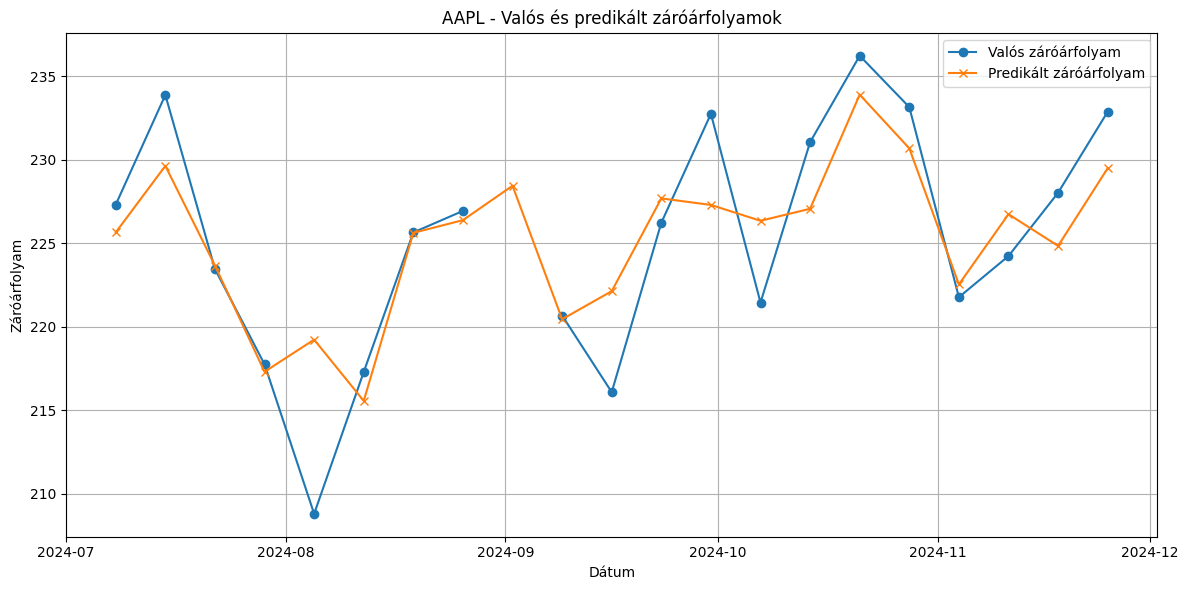

Diagram mentve: TXN_actual_vs_predicted.png


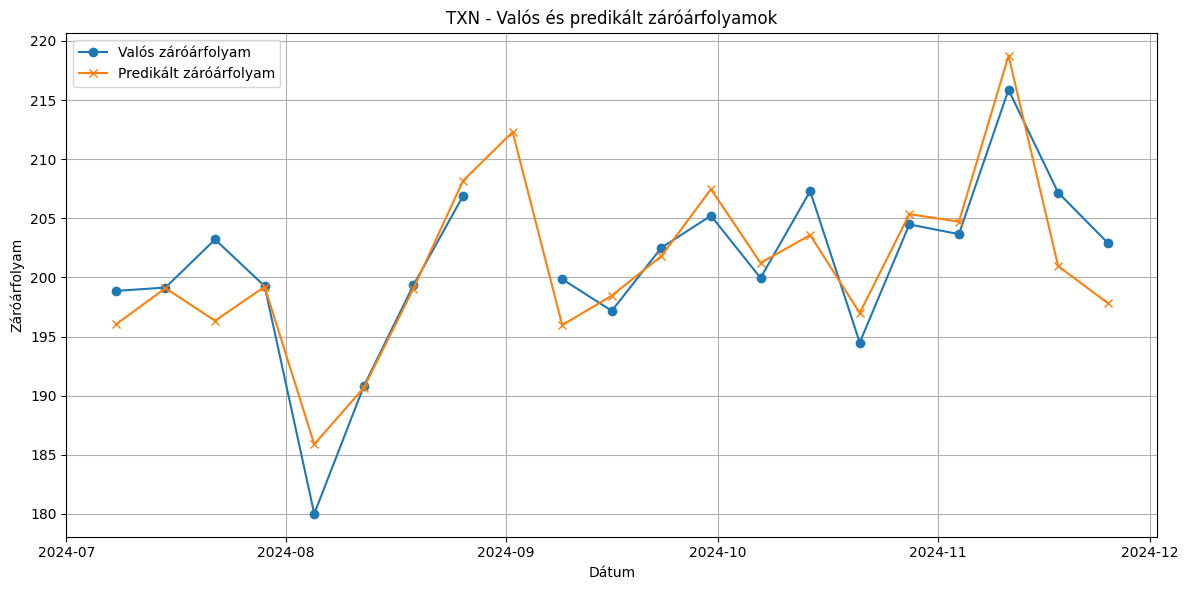

Diagram mentve: NVDA_actual_vs_predicted.png


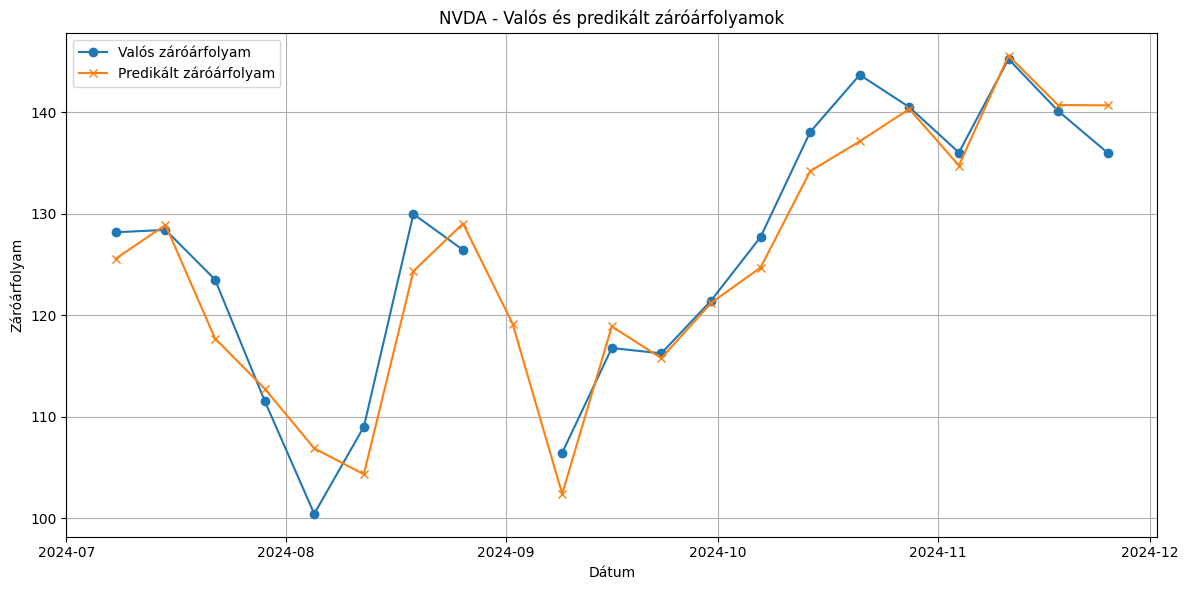

Diagram mentve: AVGO_actual_vs_predicted.png


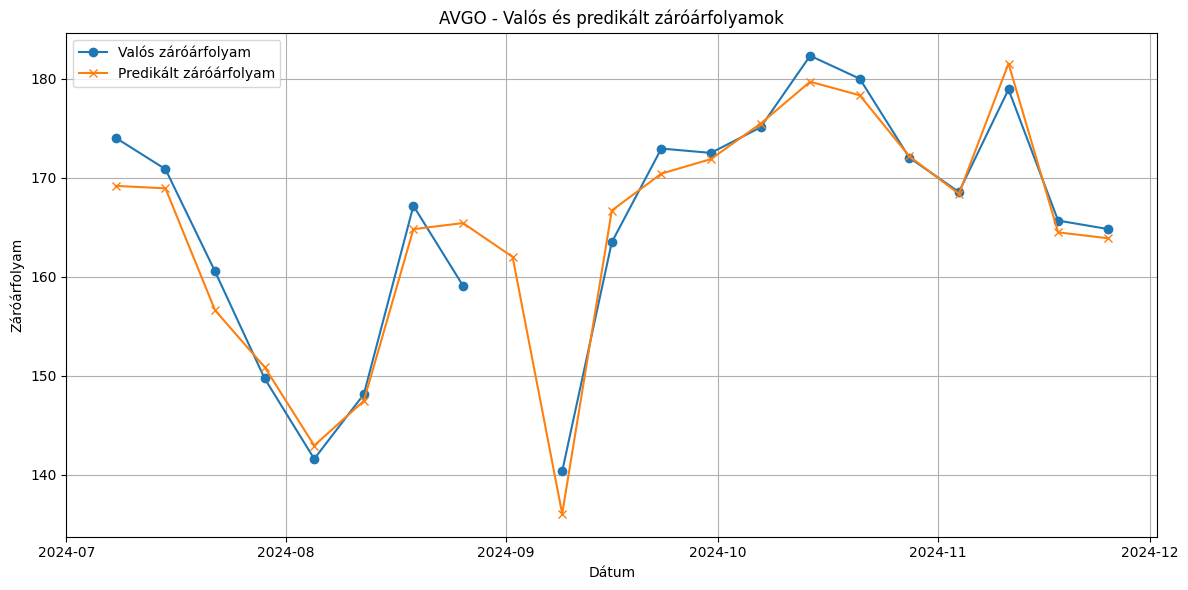

Diagram mentve: ISRG_actual_vs_predicted.png


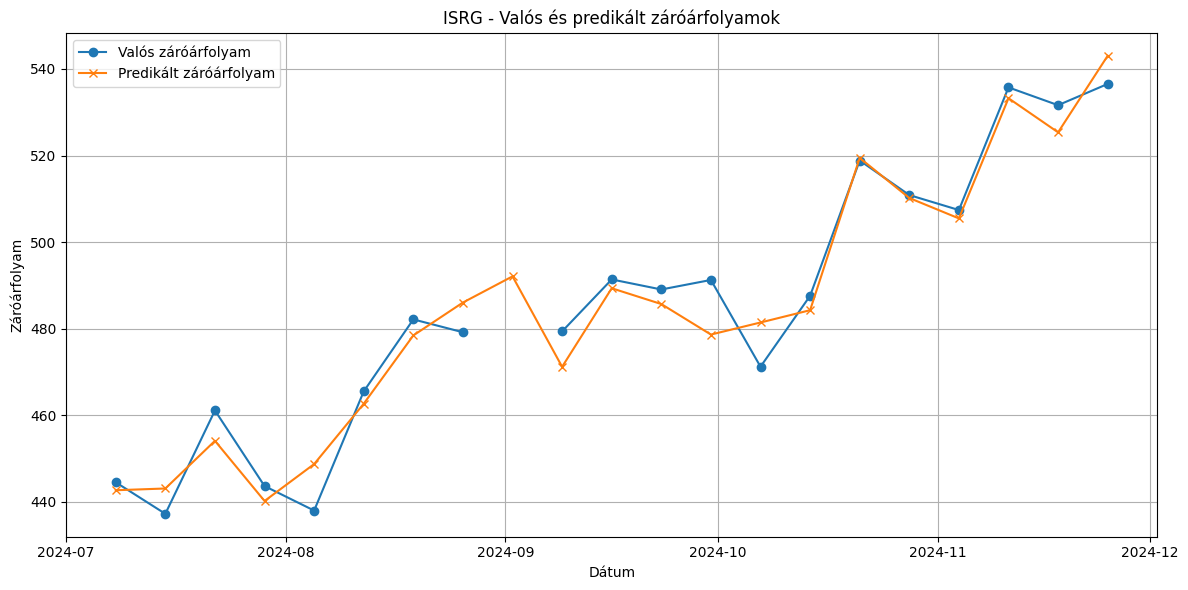

Diagram mentve: CSX_actual_vs_predicted.png


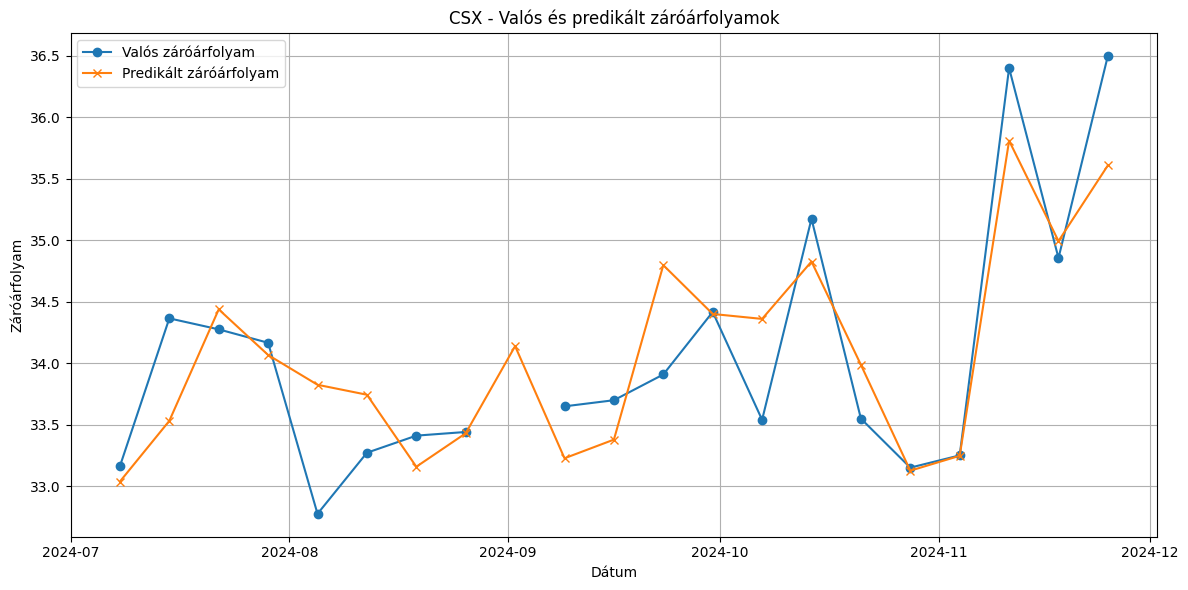

Diagram mentve: EBAY_actual_vs_predicted.png


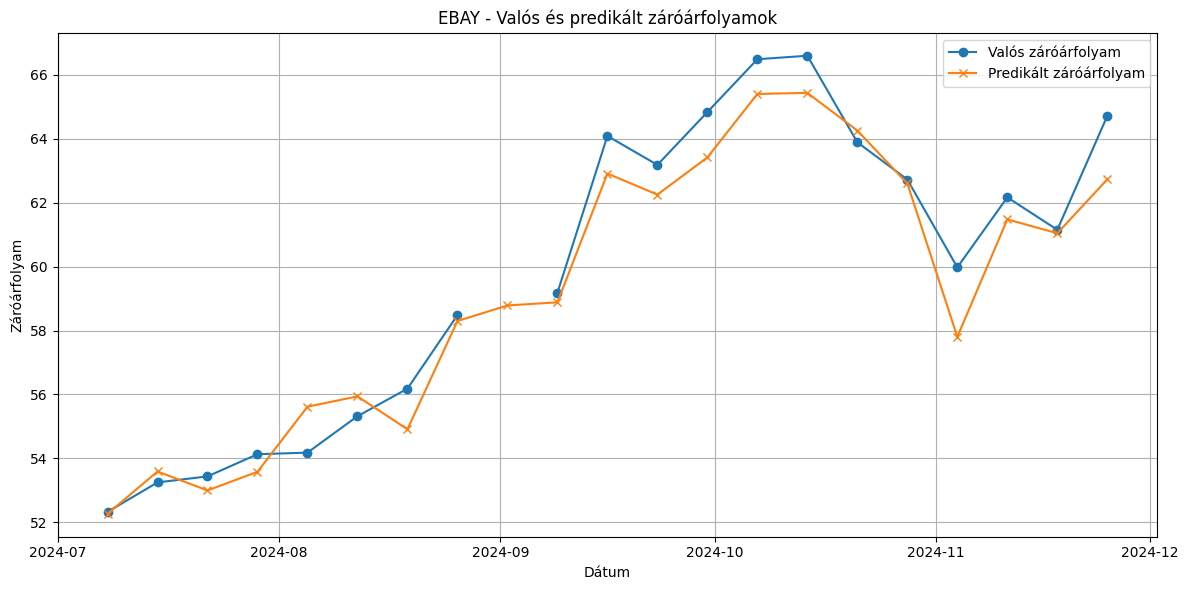

Diagram mentve: MCHP_actual_vs_predicted.png


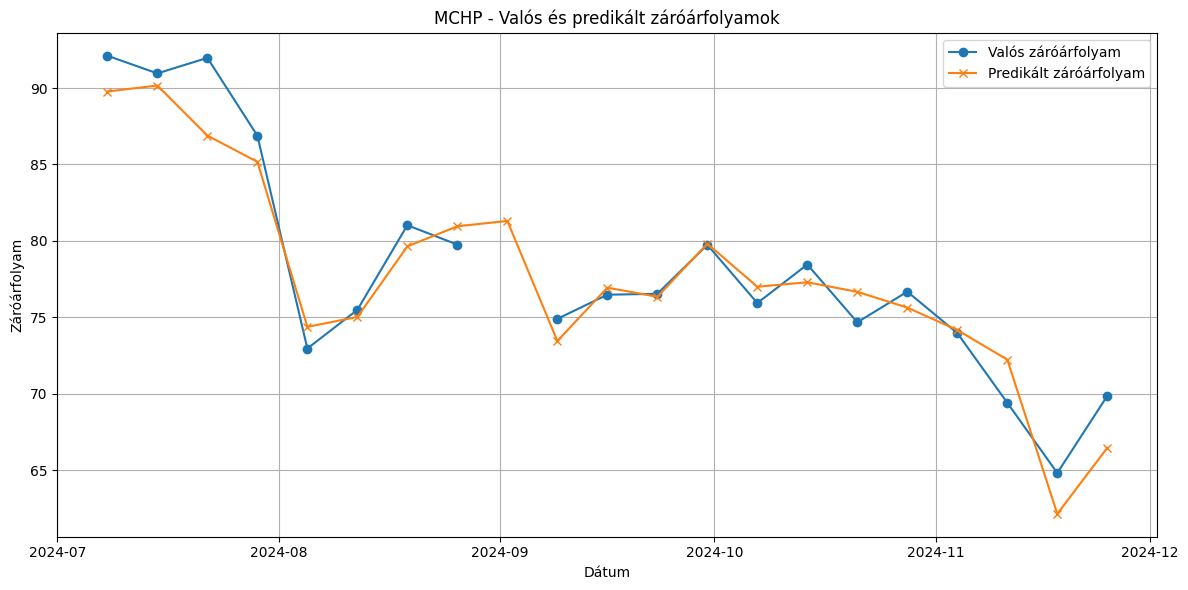

Diagram mentve: TSLA_actual_vs_predicted.png


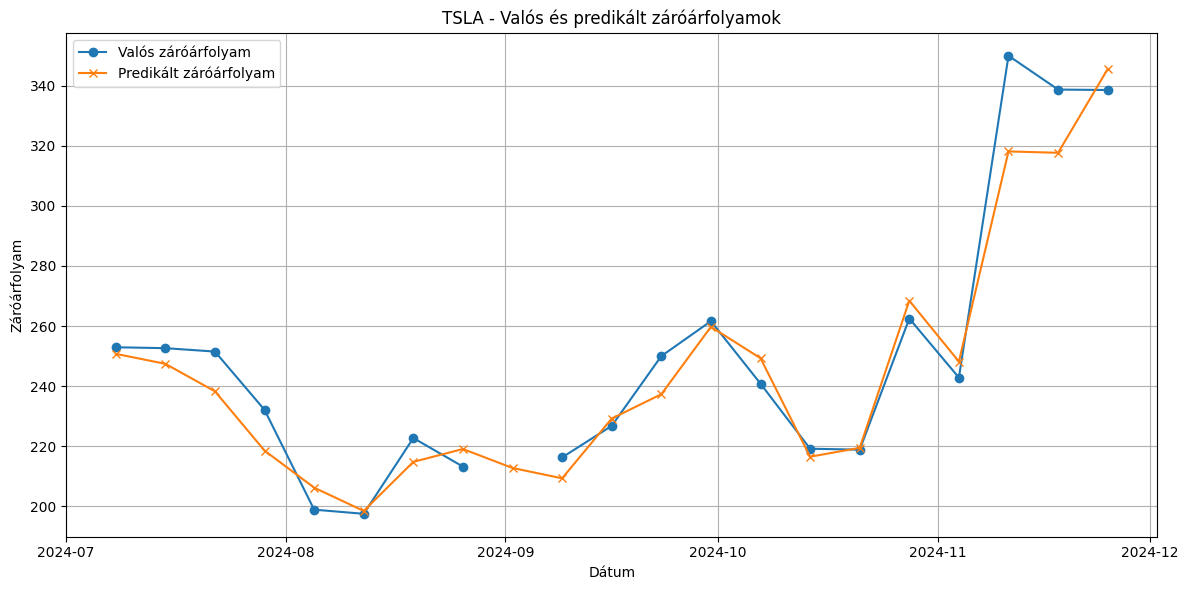

In [ ]:
# A legközelebbi péntek dátuma
def get_next_friday(today):
    days_until_friday = 4 - today.weekday()  # Péntek: 4
    if days_until_friday <= 0:  # Ha már péntek van, akkor a következő péntek
        days_until_friday += 7
    return today + timedelta(days=days_until_friday)

# Mai dátum
today = datetime.today()

# Következő péntek dátuma
END_DATE = get_next_friday(today).strftime('%Y-%m-%d')

# Diagram készítése minden részvényhez
def plot_actual_vs_predicted(excel_data, predictions_file):
    # Betöltjük az összes predikciót
    predictions_df = pd.read_excel(predictions_file, sheet_name=None)  # Minden munkalapot betölt

    for ticker, actual_data in excel_data.items():
        # Konvertáljuk a `Date` oszlopot dátummá
        actual_data['Date'] = pd.to_datetime(actual_data['Date']).dt.date

        # Predikált adatok betöltése
        if ticker in predictions_df:
            predicted_data = predictions_df[ticker]
            predicted_data['Week_Starting'] = pd.to_datetime(predicted_data['Week_Starting']).dt.date

            # Valós és predikált adatok összeillesztése
            merged_data = pd.merge(
                actual_data[['Date', 'Close']],
                predicted_data[['Week_Starting', 'Predicted_Close']],
                left_on='Date',
                right_on='Week_Starting',
                how='inner'
            )

            # Diagram készítése
            plt.figure(figsize=(12, 6))
            plt.plot(merged_data['Date'], merged_data['Close'], label='Valós záróárfolyam', marker='o')
            plt.plot(merged_data['Date'], merged_data['Predicted_Close'], label='Predikált záróárfolyam', marker='x')

            plt.title(f"{ticker} - Valós és predikált záróárfolyamok")
            plt.xlabel("Dátum")
            plt.ylabel("Záróárfolyam")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()

            # Mentés fájlba
            output_plot_file = f"{ticker}_actual_vs_predicted.png"
            plt.savefig(output_plot_file)
            print(f"Diagram mentve: {output_plot_file}")

            plt.show()
        else:
            print(f"Nincs predikált adat a(z) {ticker} részvényhez.")

# Fő modul futtatása
if __name__ == "__main__":
    # Az eredeti Excel adatokat tartalmazó fájl
    original_data_file = 'close_mondays_2024.xlsx'
    predictions_file = 'weekly_predictions_with_returns.xlsx'

    # Betöltjük az eredeti adatokat és a predikciókat
    original_data = pd.read_excel(original_data_file, sheet_name=None)
    plot_actual_vs_predicted(original_data, predictions_file)

[*********************100%***********************]  9 of 9 completed


     pcost       dcost       gap    pres   dres
 0:  8.6256e-04 -9.9994e-01  1e+00  1e-16  3e+00
 1:  8.6146e-04 -9.9386e-03  1e-02  8e-17  4e-02
 2:  7.8725e-04  3.5506e-05  8e-04  7e-17  2e-03
 3:  5.4944e-04  3.1155e-04  2e-04  1e-16  1e-18
 4:  5.0911e-04  4.8434e-04  2e-05  1e-16  8e-19
 5:  4.9734e-04  4.9632e-04  1e-06  1e-16  7e-19
 6:  4.9685e-04  4.9680e-04  5e-08  1e-16  3e-19
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  8.6968e-04 -9.9995e-01  1e+00  1e-16  3e+00
 1:  8.6858e-04 -9.9492e-03  1e-02  1e-16  4e-02
 2:  7.9366e-04  2.4904e-05  8e-04  5e-17  3e-03
 3:  5.4526e-04  2.9761e-04  2e-04  4e-16  9e-19
 4:  5.0637e-04  4.7627e-04  3e-05  1e-16  5e-19
 5:  4.9408e-04  4.9250e-04  2e-06  1e-16  7e-19
 6:  4.9303e-04  4.9295e-04  7e-08  1e-16  5e-19
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  8.4837e-04 -9.9991e-01  1e+00  3e-16  3e+00
 1:  8.4742e-04 -9.9110e-03  1e-02  2e-16  4e-02
 2:  7.8106e-04  5.1935e

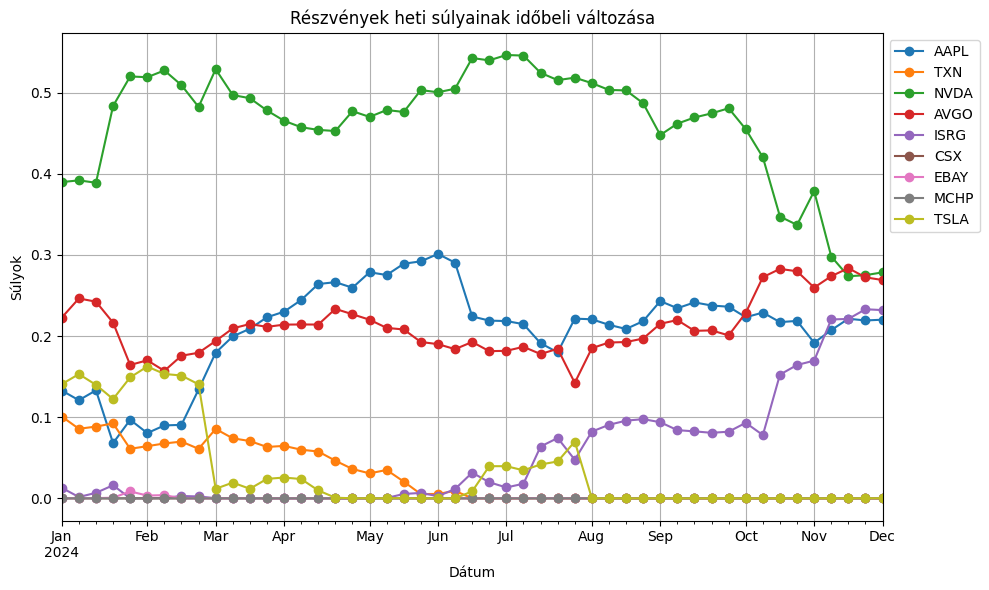


Évesített összesített hozam: 14.36%


In [ ]:
# A legközelebbi hétfő dátuma
def get_next_monday(today):
    days_until_monday = (0 - today.weekday()) % 7  # Hétfő: 0
    if days_until_monday <= 0:  # Ha már hétfő van, akkor a következő hétfő
        days_until_monday += 7
    return today + timedelta(days=days_until_monday)

# Mai dátum
today = datetime.today()
END_DATE = get_next_monday(today).strftime('%Y-%m-%d')

# Heti súlyok kiszámítása és mentése
def calculate_and_save_weekly_weights(data, tickers, output_file):
    weekly_data = data.resample('W-MON').last()  # Heti záró árfolyamok (hétfői zárás)
    weekly_data.index = weekly_data.index.tz_localize(None)

    weekly_weights = []  # Heti súlyok tárolása
    weekly_performance = []  # Heti teljesítmény tárolása

    for week in pd.date_range("2024-01-01", END_DATE, freq="W-MON"):
        current_data = weekly_data.loc[:week].iloc[-52:]  # Az utolsó 52 hét adatai

        if current_data.shape[0] < 52:  # Ha kevesebb, mint 52 hét adat, kihagyás
            print(f"Nincs elég adat az {week.strftime('%Y-%m-%d')} hétre. Kihagyás.")
            continue

        # Heti logaritmikus hozamok
        log_returns = np.log(current_data / current_data.shift(1)).dropna()

        # Várható hozamok (mu) és kovariancia mátrix (S)
        mu = log_returns.mean().values
        cov_matrix = log_returns.cov().values

        # Kvadratikus programozás beállítása
        n = len(mu)
        P = 2 * matrix(cov_matrix)
        q = matrix(np.zeros(n))
        G = matrix(-np.identity(n))
        h = matrix(np.zeros(n))
        A = matrix(np.ones((1, n)))
        b = matrix([1.0])

        # Kvadratikus programozás megoldása
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
        weights = np.array(solution['x']).flatten()
        weekly_weights.append(weights)

        # Portfólió teljesítmény
        expected_return = np.dot(weights, mu)
        expected_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        weekly_performance.append((expected_return, expected_volatility))

    # Heti súlyok mentése Excel fájlba
    dates = pd.date_range("2024-01-01", END_DATE, freq="W-MON")
    weights_df = pd.DataFrame(weekly_weights, index=dates, columns=tickers)
    weights_df.to_excel(output_file, index_label="Date")

    # Heti teljesítmény mentése Excel fájlba
    performance_df = pd.DataFrame(
        weekly_performance,
        index=dates,
        columns=["Expected Return", "Volatility"]
    )
    performance_df.to_excel("weekly_performance.xlsx", index_label="Date")

    print("\nHeti teljesítmény metrikák mentve a 'weekly_performance.xlsx' fájlba.")

    # Súlyok ábrázolása
    weights_df.plot(figsize=(10, 6), marker='o')
    plt.title("Részvények heti súlyainak időbeli változása")
    plt.xlabel("Dátum")
    plt.ylabel("Súlyok")
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.grid()
    plt.tight_layout()
    plt.savefig("weekly_weights_chart.png")
    plt.show()

    return weights_df

# Évesített összesített hozam kiszámítása
def calculate_annualized_return(weekly_returns):
    actual_weekly_returns = np.exp(weekly_returns) - 1
    cumulative_return = (actual_weekly_returns + 1).prod() - 1
    annualized_return = (1 + cumulative_return) ** (52 / len(weekly_returns)) - 1
    return annualized_return

# Adatok letöltése
tickers = ['AAPL', 'TXN', 'NVDA', 'AVGO', 'ISRG', 'CSX', 'EBAY', 'MCHP', 'TSLA']
data = yf.download(tickers, start="2023-01-01", end=END_DATE)["Adj Close"]

# Heti portfólió súlyok és teljesítmény számítása
weights_df = calculate_and_save_weekly_weights(data, tickers, "weekly_weights_52weeks_monday.xlsx")

# Heti logaritmikus hozamok számítása
log_returns = np.log(data / data.shift(1)).dropna()
portfolio_weekly_returns = (weights_df.iloc[-1].values * log_returns[tickers]).sum(axis=1)

# Évesített összesített hozam számítása
annualized_return = calculate_annualized_return(portfolio_weekly_returns)
print(f"\nÉvesített összesített hozam: {annualized_return * 100:.2f}%")


In [ ]:
# Konstansok
START_DATE = '2023-12-20'
END_DATE = '2024-11-29'  # Aktualizálni kell a kívánt dátumra
TICKERS = ['AAPL', 'TXN', 'NVDA', 'AVGO', 'ISRG', 'CSX', 'EBAY', 'MCHP', 'TSLA']

# Heti súlyok betöltése Excel fájlból
weights_file = "weekly_weights_52weeks_monday.xlsx"
weights_df = pd.read_excel(weights_file, index_col="Date", parse_dates=True)
weights_df.index = weights_df.index.tz_localize(None)  # Időzóna eltávolítása

# Tény adatok letöltése Yahoo Finance-ről
print("Tény árfolyamadatok letöltése...")
data = yf.download(TICKERS, start=START_DATE, end=END_DATE)['Adj Close']

# Heti záróárfolyamok számítása (hétfői záróárfolyamok)
weekly_data = data.resample('W-MON').last()

# Heti logaritmikus hozamok számítása
log_returns = np.log(weekly_data / weekly_data.shift(1)).dropna()
log_returns.index = log_returns.index.tz_localize(None)  # Időzóna eltávolítása

# A weights_df és log_returns igazítása az átfedő dátumokhoz
common_dates = log_returns.index.intersection(weights_df.index)
print("\nSúlyok dátumtartománya:")
print(weights_df.index.min(), "->", weights_df.index.max())

print("\nTény loghozamok dátumtartománya:")
print(log_returns.index.min(), "->", log_returns.index.max())

print("\nÁtfedő dátumok:")
print(common_dates)

aligned_weights = weights_df.loc[common_dates]
aligned_returns = log_returns.loc[common_dates]

# Ellenőrzés: Van-e átfedés a súlyok és a loghozamok dátumtartománya között?
if aligned_weights.empty or aligned_returns.empty:
    print("Hiba: Az átfedő dátumtartomány üres. Ellenőrizze a súlyokat és az árfolyamadatokat!")
else:
    # Heti portfólió valós hozamok kiszámítása a súlyok alapján
    portfolio_weekly_returns = (aligned_weights.values * aligned_returns.values).sum(axis=1)

    # Évesített összesített hozam kiszámítása
    def calculate_annualized_return(weekly_returns):
        actual_weekly_returns = np.exp(weekly_returns) - 1
        cumulative_return = (actual_weekly_returns + 1).prod() - 1
        annualized_return = (1 + cumulative_return) ** (52 / len(weekly_returns)) - 1
        return annualized_return

    # Évesített hozam kiszámítása
    annualized_return = calculate_annualized_return(portfolio_weekly_returns)

    # Eredmények kiírása
    print(f"\nHeti portfólió hozamok:\n{portfolio_weekly_returns}")
    print(f"\nÉvesített összesített hozam: {annualized_return * 100:.2f}%")

    # Hozamok és súlyok mentése (opcionális)
    output_file = "portfolio_realized_returns.xlsx"
    results_df = pd.DataFrame({
        "Date": aligned_weights.index,
        "Portfolio Weekly Returns": portfolio_weekly_returns
    })
    results_df.to_excel(output_file, index=False)
    print(f"\nEredmények mentve: {output_file}")


[                       0%                       ]

Tény árfolyamadatok letöltése...


[*********************100%***********************]  9 of 9 completed



Súlyok dátumtartománya:
2024-01-01 00:00:00 -> 2024-12-02 00:00:00

Tény loghozamok dátumtartománya:
2024-01-01 00:00:00 -> 2024-12-02 00:00:00

Átfedő dátumok:
DatetimeIndex(['2024-01-01', '2024-01-08', '2024-01-15', '2024-01-22',
               '2024-01-29', '2024-02-05', '2024-02-12', '2024-02-19',
               '2024-02-26', '2024-03-04', '2024-03-11', '2024-03-18',
               '2024-03-25', '2024-04-01', '2024-04-08', '2024-04-15',
               '2024-04-22', '2024-04-29', '2024-05-06', '2024-05-13',
               '2024-05-20', '2024-05-27', '2024-06-03', '2024-06-10',
               '2024-06-17', '2024-06-24', '2024-07-01', '2024-07-08',
               '2024-07-15', '2024-07-22', '2024-07-29', '2024-08-05',
               '2024-08-12', '2024-08-19', '2024-08-26', '2024-09-02',
               '2024-09-09', '2024-09-16', '2024-09-23', '2024-09-30',
               '2024-10-07', '2024-10-14', '2024-10-21', '2024-10-28',
               '2024-11-04', '2024-11-11', '2024-11-18', 

[**********            20%                       ]  2 of 10 completed

Adatok letöltése a Yahoo Finance-től...


[*********************100%***********************]  10 of 10 completed



Predikált adatok betöltése...

Adatok kombinálása...

Az időszak eddigi összesített hozama: 37.69%
Az időszak évesített hozama: 42.46%

Heti eredmények:
                    Week_End      Beta  Expected Return
0  2024-01-08 00:00:00+00:00  1.324097         0.822257
1  2024-01-15 00:00:00+00:00  1.290160         0.723391
2  2024-01-22 00:00:00+00:00  1.206171         0.681951
3  2024-01-29 00:00:00+00:00  1.439579         0.838715
4  2024-02-05 00:00:00+00:00  1.268839         0.640744
5  2024-02-12 00:00:00+00:00  1.226371         0.672763
6  2024-02-19 00:00:00+00:00  1.075850         0.596760
7  2024-02-26 00:00:00+00:00  1.249050         0.776135
8  2024-03-04 00:00:00+00:00  1.183358         0.731282
9  2024-03-11 00:00:00+00:00  1.244483         0.838798
10 2024-03-18 00:00:00+00:00  1.136254         0.691404
11 2024-03-25 00:00:00+00:00  1.383417         0.848791
12 2024-04-01 00:00:00+00:00  1.467293         0.798316
13 2024-04-08 00:00:00+00:00  1.394715         0.762641
14 202

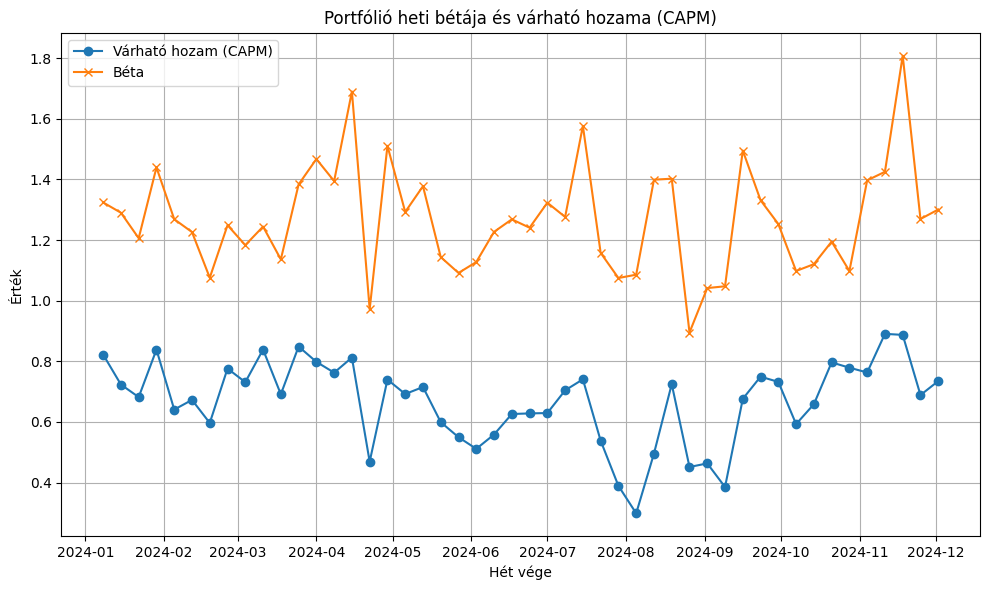

In [ ]:

# Konstansok
START_DATE = '2023-01-01'
END_DATE = datetime.today().strftime('%Y-%m-%d')  # Mai dátum dinamikusan generálva
TICKERS = ['AAPL', 'TXN', 'NVDA', 'AVGO', 'ISRG', 'CSX', 'EBAY', 'MCHP', 'TSLA']
INDEX = '^IXIC'  # Nasdaq index
RISK_FREE_RATE = 0.0427 / 52  # Heti kockázatmentes hozam (évi 4,27%)

# Adatok letöltése
print("Adatok letöltése a Yahoo Finance-től...")
data = yf.download(TICKERS + [INDEX], start=START_DATE, end=END_DATE)['Adj Close']

# Predikált adatok betöltése
print("\nPredikált adatok betöltése...")
predicted_data = pd.read_excel("weekly_predictions_with_returns_ixic.xlsx", index_col="Week_Starting", parse_dates=True)

# Heti záróárfolyamok kiszámítása (tényleges és predikált adatok kombinálása)
print("\nAdatok kombinálása...")
weekly_data = data.resample('W-MON').last()
combined_data = weekly_data.copy()
for ticker in TICKERS:
    if ticker in predicted_data.columns:
        combined_data[ticker].update(predicted_data[ticker])  # A predikált adatokat felülírjuk a ténylegesekkel, ha van adat

# Heti logaritmikus hozamok kiszámítása
log_returns = np.log(combined_data / combined_data.shift(1)).dropna()
index_returns = log_returns[INDEX]

# Béta kiszámítása
def calculate_beta(stock_returns, index_returns):
    covariance = np.cov(stock_returns, index_returns)[0, 1]  # Kovariancia a részvény és az index között
    variance = np.var(index_returns)  # Index varianciája
    beta = covariance / variance  # Béta képlet
    return beta

# CAPM modell alkalmazása
def calculate_capm(portfolio_weights, stock_returns, index_returns, risk_free_rate=RISK_FREE_RATE):
    # Portfólió hozamok kiszámítása
    portfolio_returns = (portfolio_weights * stock_returns).sum(axis=1)

    # Béta kiszámítása a portfólióra
    beta = calculate_beta(portfolio_returns, index_returns)

    # Várható piaci hozam
    expected_market_return = np.mean(index_returns)

    # CAPM képlet alkalmazása
    expected_portfolio_return = risk_free_rate + beta * (expected_market_return - risk_free_rate)
    return beta, expected_portfolio_return * 100

# Heti eredmények tárolása
results = []
cumulative_return = 1  # Összesített hozam kezdeti értéke (1 = 0% kezdeti hozam)

# Dinamikus számítás az előző 52 hét adatával
for week_end in combined_data.index[52:]:  # Csak a 52. hét után kezdünk
    # Az előző 51 hét tényleges és a 1 hét predikált adatai
    relevant_data = log_returns.loc[:week_end].iloc[-52:]  # Az utolsó 52 hét
    if relevant_data.shape[0] < 52:
        continue

    portfolio_weights = np.random.dirichlet(np.ones(len(TICKERS)))  # Példa portfólió súlyok
    stock_returns = relevant_data[TICKERS]

    # CAPM alkalmazása
    beta, expected_return = calculate_capm(portfolio_weights, stock_returns, index_returns.loc[relevant_data.index])
    cumulative_return *= (1 + expected_return / 100)  # Geometriai összesítés
    results.append({
        'Week_End': week_end,
        'Beta': beta,
        'Expected Return': expected_return
    })

# Eredmények táblázatba rendezése
results_df = pd.DataFrame(results)

# Összesített hozam kiszámítása
cumulative_return_percentage = (cumulative_return - 1) * 100

# Az időszak hosszának kiszámítása
start_date = results_df['Week_End'].iloc[0]
end_date = results_df['Week_End'].iloc[-1]
total_weeks = (end_date - start_date).days / 7
total_years = total_weeks / 52

# Évesített hozam kiszámítása
annualized_return = ((cumulative_return) ** (1 / total_years) - 1) * 100

# Kimenet
print(f"\nAz időszak eddigi összesített hozama: {cumulative_return_percentage:.2f}%")
print(f"Az időszak évesített hozama: {annualized_return:.2f}%")

# Eredmények kiírása
print("\nHeti eredmények:")
print(results_df)

# Eredmények ábrázolása
plt.figure(figsize=(10, 6))
plt.plot(results_df['Week_End'], results_df['Expected Return'], label="Várható hozam (CAPM)", marker='o')
plt.plot(results_df['Week_End'], results_df['Beta'], label="Béta", marker='x')
plt.title("Portfólió heti bétája és várható hozama (CAPM)")
plt.xlabel("Hét vége")
plt.ylabel("Érték")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


[                       0%                       ]

Adatok letöltése...


[*********************100%***********************]  10 of 10 completed



Letöltött adatok:
Ticker                          AAPL       AVGO        CSX       EBAY  \
Date                                                                    
2019-01-02 00:00:00+00:00  37.708607  21.249962  19.097321  26.067904   
2019-01-03 00:00:00+00:00  33.952541  19.359751  18.798302  25.589016   
2019-01-04 00:00:00+00:00  35.401958  19.550026  19.356264  26.176327   
2019-01-07 00:00:00+00:00  35.323162  19.948191  19.251459  26.628113   
2019-01-08 00:00:00+00:00  35.996529  19.788088  19.528902  27.107000   

Ticker                           ISRG       MCHP      NVDA       TSLA  \
Date                                                                    
2019-01-02 00:00:00+00:00  155.343338  32.283291  3.378323  20.674667   
2019-01-03 00:00:00+00:00  150.080002  30.007399  3.174214  20.024000   
2019-01-04 00:00:00+00:00  157.226669  31.224529  3.377579  21.179333   
2019-01-07 00:00:00+00:00  159.479996  32.138508  3.556390  22.330667   
2019-01-08 00:00:00+00:00  160.

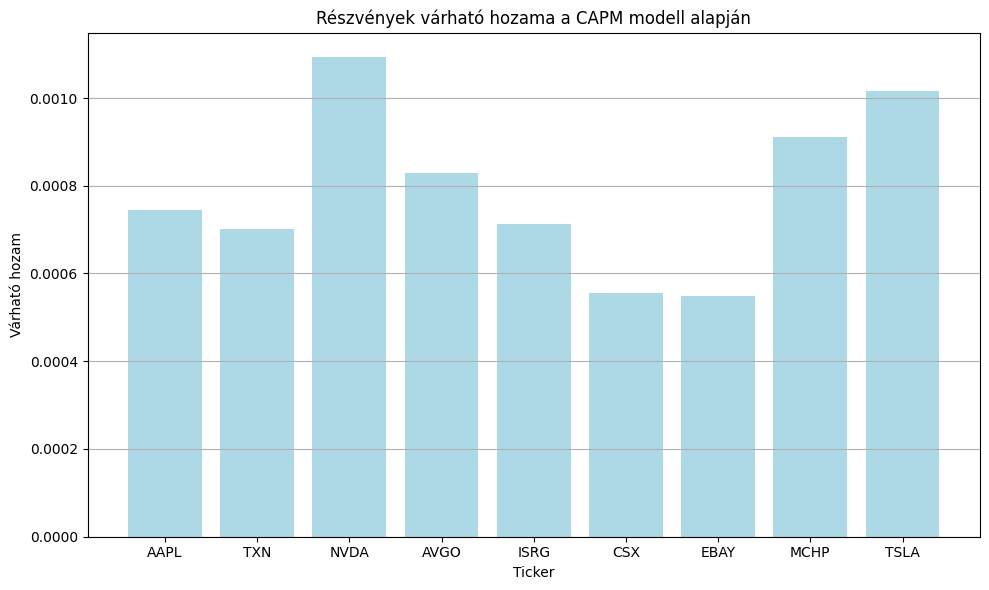

In [ ]:
# Konstansok
START_DATE = '2019-01-01'
END_DATE = datetime.today().strftime('%Y-%m-%d')  # A mai dátum, dinamikusan generálva
TICKERS = ['AAPL', 'TXN', 'NVDA', 'AVGO', 'ISRG', 'CSX', 'EBAY', 'MCHP', 'TSLA']
INDEX = '^IXIC'  # Nasdaq index
RISK_FREE_RATE = 0.0427 / 252  # Napi kockázatmentes hozam (évi 4,27%)

# Adatok letöltése
print("Adatok letöltése...")
data = yf.download(TICKERS + [INDEX], start=START_DATE, end=END_DATE)['Adj Close']

# Ellenőrizzük, hogy milyen adatokat töltöttünk le
print("\nLetöltött adatok:")
print(data.head())  # Kiírjuk az első 5 sort, hogy lássuk, mi jött le

# Napi logaritmikus hozamok kiszámítása
returns = np.log(data / data.shift(1)).dropna()

# Index napi logaritmikus hozamok
index_returns = returns[INDEX]

# Béta kiszámítása
def calculate_beta(stock_returns, index_returns):
    covariance = np.cov(stock_returns, index_returns)[0, 1]
    variance = np.var(index_returns)
    beta = covariance / variance
    return beta

# CAPM modell alkalmazása
def calculate_capm(stock_returns, index_returns, risk_free_rate=RISK_FREE_RATE):
    beta = calculate_beta(stock_returns, index_returns)
    expected_market_return = np.mean(index_returns)  # Várható piaci hozam
    expected_stock_return = risk_free_rate + beta * (expected_market_return - risk_free_rate)  # CAPM képlet
    return expected_stock_return

# Várható hozamok számítása a CAPM segítségével
capm_results = []
for ticker in TICKERS:
    # Logaritmikus hozamok számítása
    stock_returns = np.log(data[ticker] / data[ticker].shift(1)).dropna()  # Logaritmikus hozamok
    # Eltávolítjuk a NaN értékeket, hogy azonos hosszúságúak legyenek
    common_dates = stock_returns.index.intersection(index_returns.index)
    stock_returns = stock_returns[common_dates]
    index_returns_filtered = index_returns[common_dates]

    # CAPM alkalmazása
    if len(stock_returns) > 0 and len(index_returns_filtered) > 0:  # Ellenőrizzük, hogy van-e adat
        expected_return = calculate_capm(stock_returns, index_returns_filtered)
        capm_results.append({
            'Ticker': ticker,
            'Expected Return (CAPM)': expected_return
        })
    else:
        print(f"Nincs elegendő adat a(z) {ticker} részvényhez.")
        capm_results.append({
            'Ticker': ticker,
            'Expected Return (CAPM)': np.nan
        })

# Eredmények táblázata
capm_df = pd.DataFrame(capm_results)

# Táblázat megjelenítése
print("\nCAPM Modell Várható Hozamok:")
print(capm_df)

# Vizualizáció: Várható hozamok (CAPM)
plt.figure(figsize=(10, 6))
plt.bar(capm_df['Ticker'], capm_df['Expected Return (CAPM)'], color='lightblue')
plt.title("Részvények várható hozama a CAPM modell alapján")
plt.xlabel("Ticker")
plt.ylabel("Várható hozam")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


[                       0%                       ]

Adatok letöltése...


[*********************100%***********************]  10 of 10 completed



Letöltött adatok:
Ticker                           AAPL        AVGO        CSX       EBAY  \
Date                                                                      
2024-11-22 00:00:00+00:00  229.869995  164.229996  35.662624  62.974491   
2024-11-25 00:00:00+00:00  232.869995  164.820007  36.499870  64.717140   
2024-11-26 00:00:00+00:00  235.059998  164.740005  36.569637  64.816719   
2024-11-27 00:00:00+00:00  234.929993  159.669998  36.460003  64.039993   
2024-11-29 00:00:00+00:00  237.330002  162.080002  36.549999  63.290001   

Ticker                           ISRG       MCHP        NVDA        TSLA  \
Date                                                                       
2024-11-22 00:00:00+00:00  547.869995  66.690002  141.949997  352.559998   
2024-11-25 00:00:00+00:00  536.549988  69.849998  136.020004  338.589996   
2024-11-26 00:00:00+00:00  542.099976  68.410004  136.919998  338.230011   
2024-11-27 00:00:00+00:00  538.549988  67.870003  135.339996  332.890015   

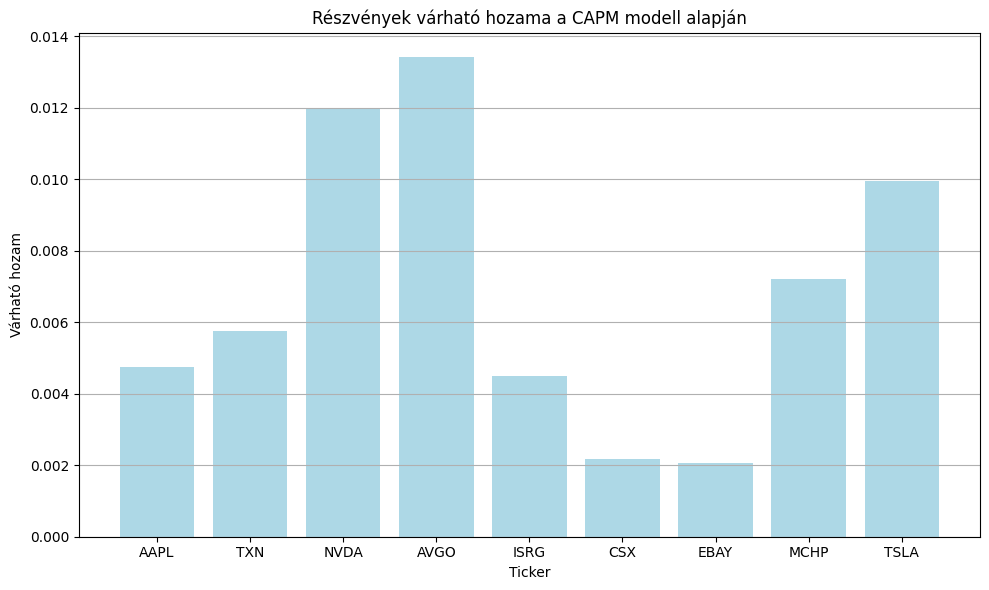

Eredmények mentve: weekly_capm_predictions_2024.xlsx


In [ ]:
# Konstansok
START_DATE = '2015-01-01'
TICKERS = ['AAPL', 'TXN', 'NVDA', 'AVGO', 'ISRG', 'CSX', 'EBAY', 'MCHP', 'TSLA']
INDEX = '^IXIC'  # Nasdaq index
RISK_FREE_RATE = 0.0427 / 52  # Heti kockázatmentes hozam (évi 4,27%)
LOOKBACK_PERIOD = 52  # 52 hét, azaz kb. 1 évnyi adat

# Mai dátum és legközelebbi péntek meghatározása
today = datetime.today()
days_until_friday = 4 - today.weekday()  # Péntek: 4
if days_until_friday <= 0:  # Ha már péntek van, akkor a következő péntek
    days_until_friday += 7
next_friday = today + timedelta(days=days_until_friday)

# Dinamikusan beállítjuk a végdátumot a legközelebbi péntekre
END_DATE = next_friday.strftime('%Y-%m-%d')

# Adatok letöltése
print("Adatok letöltése...")
data = yf.download(TICKERS + [INDEX], start=START_DATE, end=END_DATE)['Adj Close']

# Ellenőrizzük, hogy milyen adatokat töltöttünk le
print("\nLetöltött adatok:")
print(data.tail())  # Kiírjuk az utolsó 5 sort, hogy lássuk, mi jött le

# Napi logaritmikus hozamok kiszámítása
returns = np.log(data / data.shift(1)).dropna()

# Index napi logaritmikus hozamok
index_returns = returns[INDEX]

# Heti logaritmikus hozamok kiszámítása
weekly_returns = np.log(data.resample('W-FRI').last() / data.resample('W-FRI').last().shift(1)).dropna()

# Heti index hozamok
index_weekly_returns = weekly_returns[INDEX]

# Béta kiszámítása
def calculate_beta(stock_returns, index_returns):
    covariance = np.cov(stock_returns, index_returns)[0, 1]
    variance = np.var(index_returns)
    beta = covariance / variance
    return beta

# CAPM modell alkalmazása
def calculate_capm(stock_returns, index_returns, risk_free_rate=RISK_FREE_RATE):
    beta = calculate_beta(stock_returns, index_returns)
    expected_market_return = np.mean(index_returns)  # Várható piaci hozam
    expected_stock_return = risk_free_rate + beta * (expected_market_return - risk_free_rate)  # CAPM képlet
    return expected_stock_return

# Eredmények tárolása
capm_results = []

# A legutolsó 260 hét adatainak kinyerése
for ticker in TICKERS:
    # Részvény heti hozamai
    stock_weekly_returns = weekly_returns[ticker]

    # A megfelelő heti hozamok (előző 260 hét)
    stock_returns_260_weeks = stock_weekly_returns[-LOOKBACK_PERIOD:]
    index_returns_260_weeks = index_weekly_returns[-LOOKBACK_PERIOD:]

    # CAPM alkalmazása
    if len(stock_returns_260_weeks) > 0 and len(index_returns_260_weeks) > 0:  # Ellenőrizzük, hogy van-e adat
        expected_return = calculate_capm(stock_returns_260_weeks, index_returns_260_weeks)
        capm_results.append({
            'Week_Ending': next_friday,  # A legközelebbi péntek dátuma
            'Ticker': ticker,
            'Expected Return (CAPM)': expected_return
        })
    else:
        print(f"Nincs elegendő adat a(z) {ticker} részvényhez.")
        capm_results.append({
            'Ticker': ticker,
            'Expected Return (CAPM)': np.nan
        })

# Eredmények táblázata
capm_df = pd.DataFrame(capm_results)

# Táblázat megjelenítése
print("\nCAPM Modell Várható Hozamok:")
print(capm_df)

# Vizualizáció: Várható hozamok (CAPM)
plt.figure(figsize=(10, 6))
plt.bar(capm_df['Ticker'], capm_df['Expected Return (CAPM)'], color='lightblue')
plt.title("Részvények várható hozama a CAPM modell alapján")
plt.xlabel("Ticker")
plt.ylabel("Várható hozam")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Eredmények mentése Excel fájlba
output_file = 'weekly_capm_predictions_2024.xlsx'
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    capm_df.to_excel(writer, index=False, sheet_name='CAPM_Predictions')

print(f"Eredmények mentve: {output_file}")


In [ ]:
# Konstansok
START_DATE = '2015-01-01'
TICKERS = ['AAPL', 'TXN', 'NVDA', 'AVGO', 'ISRG', 'CSX', 'EBAY', 'MCHP', 'TSLA']
INDEX = '^IXIC'  # Nasdaq index
RISK_FREE_RATE = 0.425 / 252  # Napi kockázatmentes hozam (évi 2%)
LOOKBACK_PERIOD = 52  # 260 hét, azaz kb. 5 évnyi adat

# Mai dátum és legközelebbi hétfő meghatározása
today = datetime.today()
days_until_monday = 0 - today.weekday()  # Hétfő: 0
if days_until_monday <= 0:  # Ha már hétfő van, akkor a következő hétfő
    days_until_monday += 7
next_monday = today + timedelta(days=days_until_monday)

# Dinamikusan beállítjuk a végdátumot a legközelebbi hétfőre
END_DATE = next_monday.strftime('%Y-%m-%d')

# Adatok letöltése
print("Adatok letöltése...")
data = yf.download(TICKERS + [INDEX], start=START_DATE, end=END_DATE)['Adj Close']

# Eltávolítjuk az időzónát az adatokból
data.index = data.index.tz_localize(None)

# Napi logaritmikus hozamok kiszámítása
returns = np.log(data / data.shift(1)).dropna()

# Heti logaritmikus hozamok kiszámítása hétfőkre
weekly_returns = np.log(data.resample('W-MON').last() / data.resample('W-MON').last().shift(1)).dropna()

# Heti index hozamok
index_weekly_returns = weekly_returns[INDEX]

# Béta kiszámítása
def calculate_beta(stock_returns, index_returns):
    covariance = np.cov(stock_returns, index_returns)[0, 1]
    variance = np.var(index_returns)
    beta = covariance / variance
    return beta

# CAPM modell alkalmazása
def calculate_capm(stock_returns, index_returns, risk_free_rate=RISK_FREE_RATE):
    beta = calculate_beta(stock_returns, index_returns)
    expected_market_return = np.mean(index_returns)  # Várható piaci hozam
    expected_stock_return = risk_free_rate + beta * (expected_market_return - risk_free_rate)  # CAPM képlet
    return expected_stock_return

# Heti várható hozamok számítása az első hétfő után folyamatosan
capm_results = []
date_range = pd.date_range(start='2024-07-01', end=END_DATE, freq='W-MON')  # Kezdő dátum: 2024.07.01

# Minden egyes hétfőre kiszámítjuk a várható hozamokat
for current_date in date_range:
    # A dátumot csak dátumként tároljuk (idő nélkül)
    current_date = current_date.date()

    print(f"Current date: {current_date}")

    # Az előző 260 hét adatainak kinyerése
    try:
        stock_returns_260_weeks = weekly_returns[TICKERS].loc[current_date - pd.DateOffset(weeks=LOOKBACK_PERIOD):current_date]
        index_returns_260_weeks = index_weekly_returns.loc[current_date - pd.DateOffset(weeks=LOOKBACK_PERIOD):current_date]

        # Ellenőrizzük, hogy van-e adat
        if stock_returns_260_weeks.empty or index_returns_260_weeks.empty:
            print(f"Nincs elég adat a(z) {current_date} dátumhoz. Skip.")
            continue
    except Exception as e:
        print(f"Error: {e}")
        continue

    # CAPM alkalmazása
    expected_returns = {}
    for ticker in TICKERS:
        stock_returns = stock_returns_260_weeks[ticker]
        if len(stock_returns) > 0 and len(index_returns_260_weeks) > 0:  # Ellenőrizzük, hogy van-e adat
            expected_return = calculate_capm(stock_returns, index_returns_260_weeks)
            expected_returns[ticker] = expected_return
        else:
            expected_returns[ticker] = np.nan

    # Eredmények hozzáadása a táblázathoz
    capm_results.append({
        'Week_Ending': current_date,
        **expected_returns
    })

# Ellenőrizzük, hogy van-e adat
if not capm_results:
    print("Nincsenek elérhető eredmények.")
else:
    # Eredmények táblázata
    capm_df = pd.DataFrame(capm_results)

    # Eredmények táblázatának megjelenítése
    print("\nCAPM Modell Várható Hozamok:")
    print(capm_df)

    # Eredmények mentése Excel fájlba
    output_file = 'weekly_capm_predictions_2024.xlsx'
    with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
        capm_df.to_excel(writer, index=False, sheet_name='CAPM_Predictions')

    print(f"Eredmények mentve: {output_file}")


[                       0%                       ]

Adatok letöltése...


[*********************100%***********************]  10 of 10 completed


Current date: 2024-07-01
Current date: 2024-07-08
Current date: 2024-07-15
Current date: 2024-07-22
Current date: 2024-07-29
Current date: 2024-08-05
Current date: 2024-08-12
Current date: 2024-08-19
Current date: 2024-08-26
Current date: 2024-09-02
Current date: 2024-09-09
Current date: 2024-09-16
Current date: 2024-09-23
Current date: 2024-09-30
Current date: 2024-10-07
Current date: 2024-10-14
Current date: 2024-10-21
Current date: 2024-10-28
Current date: 2024-11-04
Current date: 2024-11-11
Current date: 2024-11-18
Current date: 2024-11-25
Current date: 2024-12-02

CAPM Modell Várható Hozamok:
   Week_Ending      AAPL       TXN      NVDA      AVGO      ISRG       CSX  \
0   2024-07-01  0.006057  0.005433  0.008862  0.009258  0.006341  0.003351   
1   2024-07-08  0.005990  0.005190  0.008669  0.009063  0.006176  0.003115   
2   2024-07-15  0.006252  0.005452  0.009147  0.009617  0.006554  0.003155   
3   2024-07-22  0.004954  0.004162  0.006778  0.007400  0.004744  0.002781   
4   2

[**********            20%                       ]  2 of 10 completed

Legutóbbi hétfő: 2024-11-25
Adatok letöltése...


[*********************100%***********************]  10 of 10 completed



Letöltött adatok:
Ticker                           AAPL        AVGO        CSX       EBAY  \
Date                                                                      
2024-11-18 00:00:00+00:00  228.020004  165.669998  34.855282  61.152176   
2024-11-19 00:00:00+00:00  228.279999  165.350006  34.486496  60.843475   
2024-11-20 00:00:00+00:00  229.000000  163.250000  34.456593  60.564651   
2024-11-21 00:00:00+00:00  228.520004  163.940002  35.224068  61.152176   
2024-11-22 00:00:00+00:00  229.869995  164.229996  35.662624  62.974491   

Ticker                           ISRG       MCHP        NVDA        TSLA  \
Date                                                                       
2024-11-18 00:00:00+00:00  531.640015  64.803619  140.149994  338.739990   
2024-11-19 00:00:00+00:00  538.820007  64.436150  147.009995  346.000000   
2024-11-20 00:00:00+00:00  541.820007  64.674515  145.889999  342.029999   
2024-11-21 00:00:00+00:00  550.619995  66.055000  146.669998  339.640015   

<Figure size 1000x600 with 0 Axes>

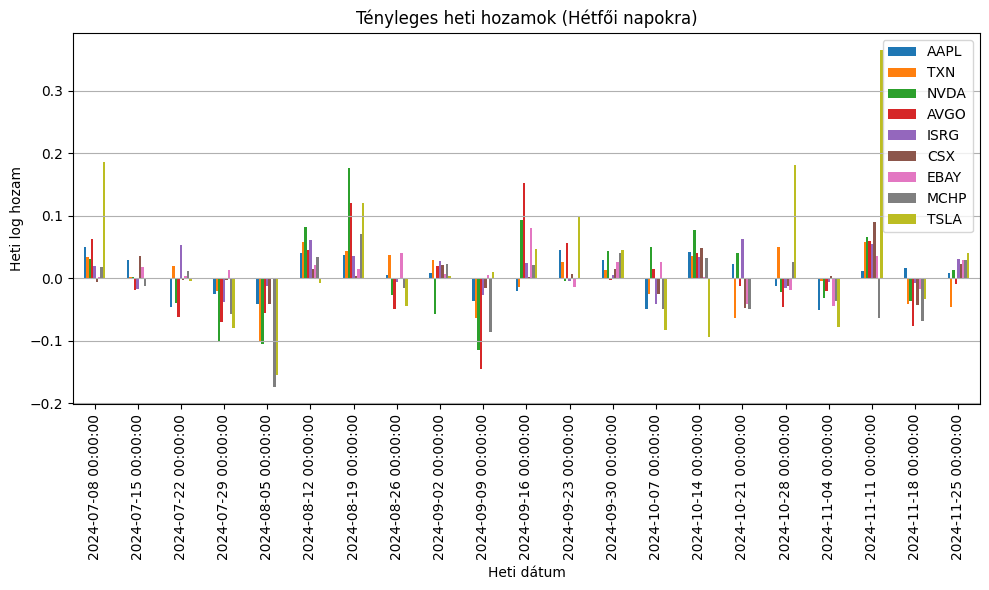

Eredmények mentve: actual_weekly_returns.xlsx


In [ ]:
# Konstansok
START_DATE = '2024-06-30'  # Kezdő dátum
TICKERS = ['AAPL', 'TXN', 'NVDA', 'AVGO', 'ISRG', 'CSX', 'EBAY', 'MCHP', 'TSLA']
INDEX = '^IXIC'  # Nasdaq index

# Mai dátum és legutóbbi hétfő meghatározása
today = datetime.today()
days_until_monday = today.weekday()  # Hétfő: 0
previous_monday = today - timedelta(days=days_until_monday)  # Legutóbbi hétfő

print(f"Legutóbbi hétfő: {previous_monday.strftime('%Y-%m-%d')}")

# Dinamikusan beállítjuk a végdátumot a legutolsó hétfőre
END_DATE = previous_monday.strftime('%Y-%m-%d')

# Adatok letöltése
print("Adatok letöltése...")
data = yf.download(TICKERS + [INDEX], start=START_DATE, end=END_DATE)['Adj Close']

# Ellenőrizzük, hogy milyen adatokat töltöttünk le
print("\nLetöltött adatok:")
print(data.tail())  # Kiírjuk az utolsó 5 sort, hogy lássuk, mi jött le

# Heti hozamok kiszámítása hétfőkre
weekly_returns = np.log(data.resample('W-MON').last() / data.resample('W-MON').last().shift(1)).dropna()

# Heti index hozamok
index_weekly_returns = weekly_returns[INDEX]

# Tényleges heti hozamok kiszámítása
actual_weekly_returns = pd.DataFrame()

for ticker in TICKERS:
    # Részvény heti hozamai
    stock_weekly_returns = weekly_returns[ticker]

    # Eredmények tárolása
    actual_weekly_returns[ticker] = stock_weekly_returns

# Időzónák eltávolítása a dátumokból
actual_weekly_returns.index = actual_weekly_returns.index.tz_localize(None)

# Eredmények táblázata
print("\nTényleges heti hozamok:")
print(actual_weekly_returns)

# Vizualizáció: Heti hozamok
plt.figure(figsize=(10, 6))
actual_weekly_returns.plot(kind='bar', figsize=(10, 6))
plt.title("Tényleges heti hozamok (Hétfői napokra)")
plt.xlabel("Heti dátum")
plt.ylabel("Heti log hozam")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Eredmények mentése Excel fájlba
output_file = 'actual_weekly_returns.xlsx'
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    actual_weekly_returns.to_excel(writer, index=True, sheet_name='Weekly Returns (Monday)')

print(f"Eredmények mentve: {output_file}")


Közös dátumok száma: 21
Közös dátumok: DatetimeIndex(['2024-07-08', '2024-07-15', '2024-07-22', '2024-07-29',
               '2024-08-05', '2024-08-12', '2024-08-19', '2024-08-26',
               '2024-09-02', '2024-09-09', '2024-09-16', '2024-09-23',
               '2024-09-30', '2024-10-07', '2024-10-14', '2024-10-21',
               '2024-10-28', '2024-11-04', '2024-11-11', '2024-11-18',
               '2024-11-25'],
              dtype='datetime64[ns]', freq='W-MON')


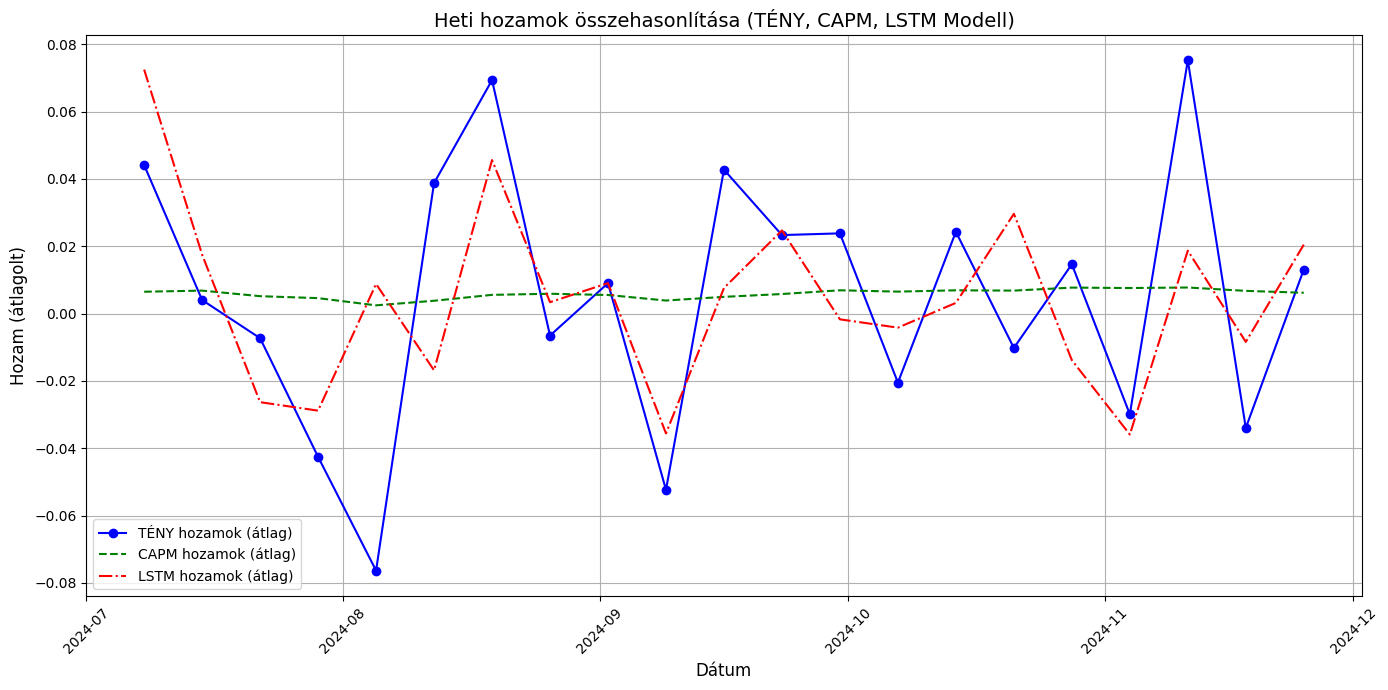

In [ ]:
# Excel fájlok beolvasása
actual_returns = pd.read_excel('actual_weekly_returns.xlsx', index_col=0)
capm_predictions = pd.read_excel('weekly_capm_predictions_2024.xlsx', index_col=0)
lstm_predictions = pd.read_excel('weekly_predictions_with_returns.xlsx', index_col=0)

# Ellenőrizzük, hogy a dátumok indexként szerepelnek-e, és konvertáljuk, ha szükséges
actual_returns.index = pd.to_datetime(actual_returns.index)
capm_predictions.index = pd.to_datetime(capm_predictions.index)

# Ellenőrizzük, hogy az LSTM fájl megfelelően van-e indexelve
if 'Week_Starting' in lstm_predictions.columns:
    lstm_predictions.set_index('Week_Starting', inplace=True)
lstm_predictions.index = pd.to_datetime(lstm_predictions.index)

# Ellenőrizzük a közös dátumokat
common_dates = actual_returns.index.intersection(capm_predictions.index).intersection(lstm_predictions.index)

# Ellenőrzés céljából kiírjuk a közös dátumokat
print("Közös dátumok száma:", len(common_dates))
print("Közös dátumok:", common_dates)

# Csak a közös dátumokhoz tartozó adatokat használjuk
actual_returns_common = actual_returns.loc[common_dates]
capm_predictions_common = capm_predictions.loc[common_dates]
lstm_predictions_common = lstm_predictions.loc[common_dates]

# Részvények átlagának kiszámítása a jobb összehasonlíthatóság érdekében
actual_returns_avg = actual_returns_common.mean(axis=1)
capm_predictions_avg = capm_predictions_common.mean(axis=1)

# Az LSTM esetében ellenőrizzük az oszlopneveket, hogy csak numerikus adatokat tartalmazzanak
if 'Predicted_Close' in lstm_predictions_common.columns:
    lstm_predictions_avg = lstm_predictions_common['Log Return']
else:
    lstm_predictions_avg = lstm_predictions_common.mean(axis=1)

# Grafikon létrehozása
plt.figure(figsize=(14, 7))

# TÉNY hozamok
plt.plot(actual_returns_avg.index, actual_returns_avg, label="TÉNY hozamok (átlag)", color='blue', marker='o')

# CAPM hozamok
plt.plot(capm_predictions_avg.index, capm_predictions_avg, label="CAPM hozamok (átlag)", color='green', linestyle='--')

# LSTM hozamok
plt.plot(lstm_predictions_avg.index, lstm_predictions_avg, label="LSTM hozamok (átlag)", color='red', linestyle='-.')

# Beállítások a grafikonhoz
plt.title("Heti hozamok összehasonlítása (TÉNY, CAPM, LSTM Modell)", fontsize=14)
plt.xlabel("Dátum", fontsize=12)
plt.ylabel("Hozam (átlagolt)", fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Grafikon megjelenítése
plt.tight_layout()
plt.show()


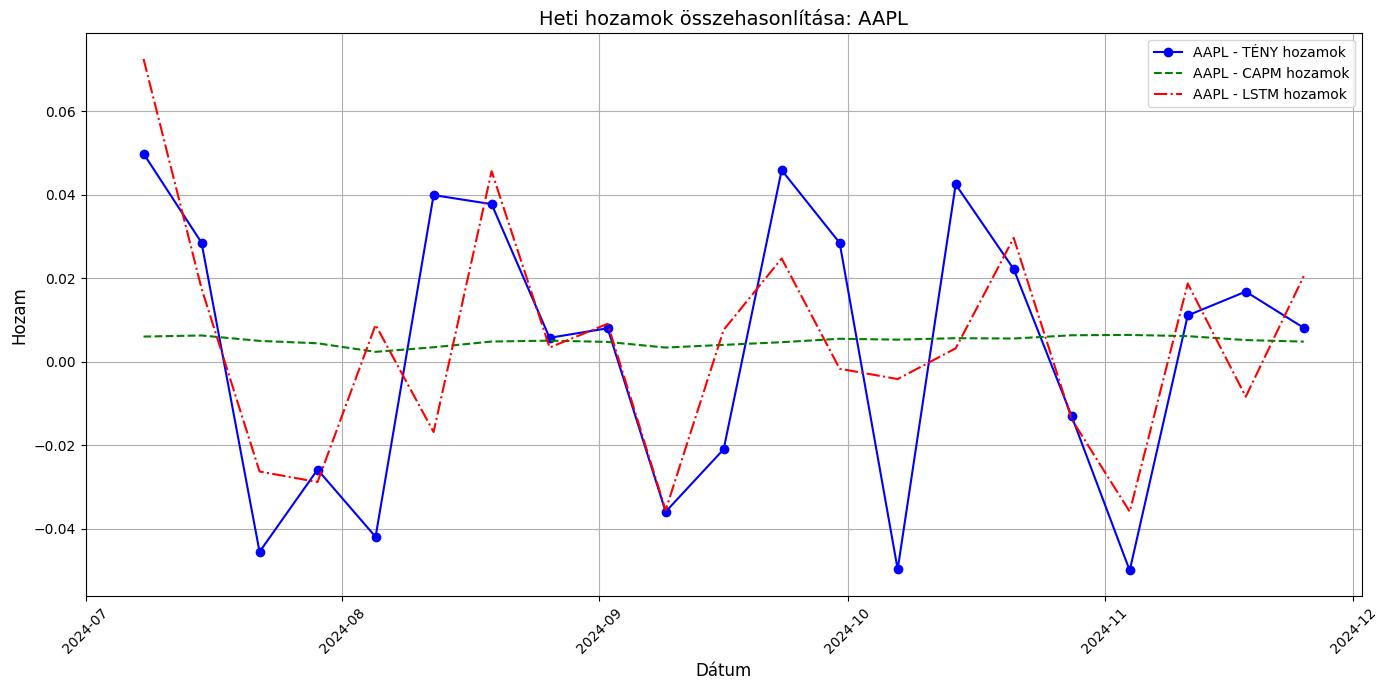

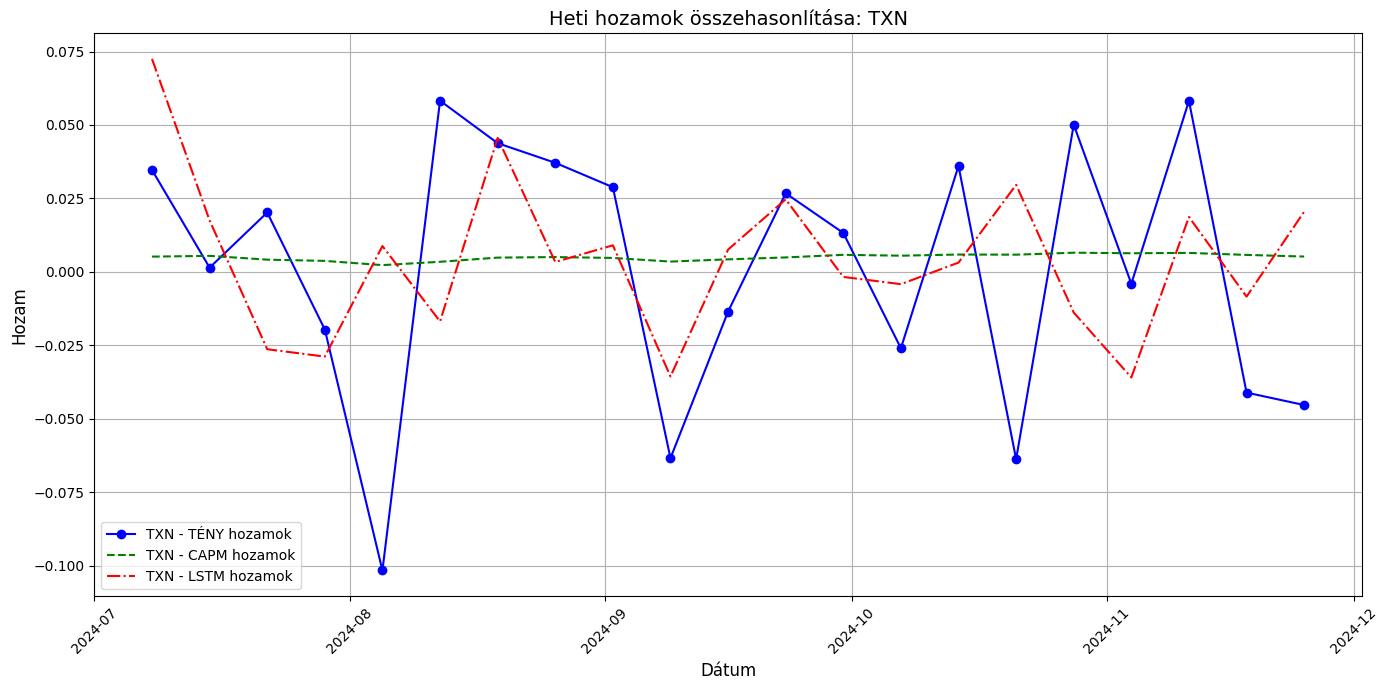

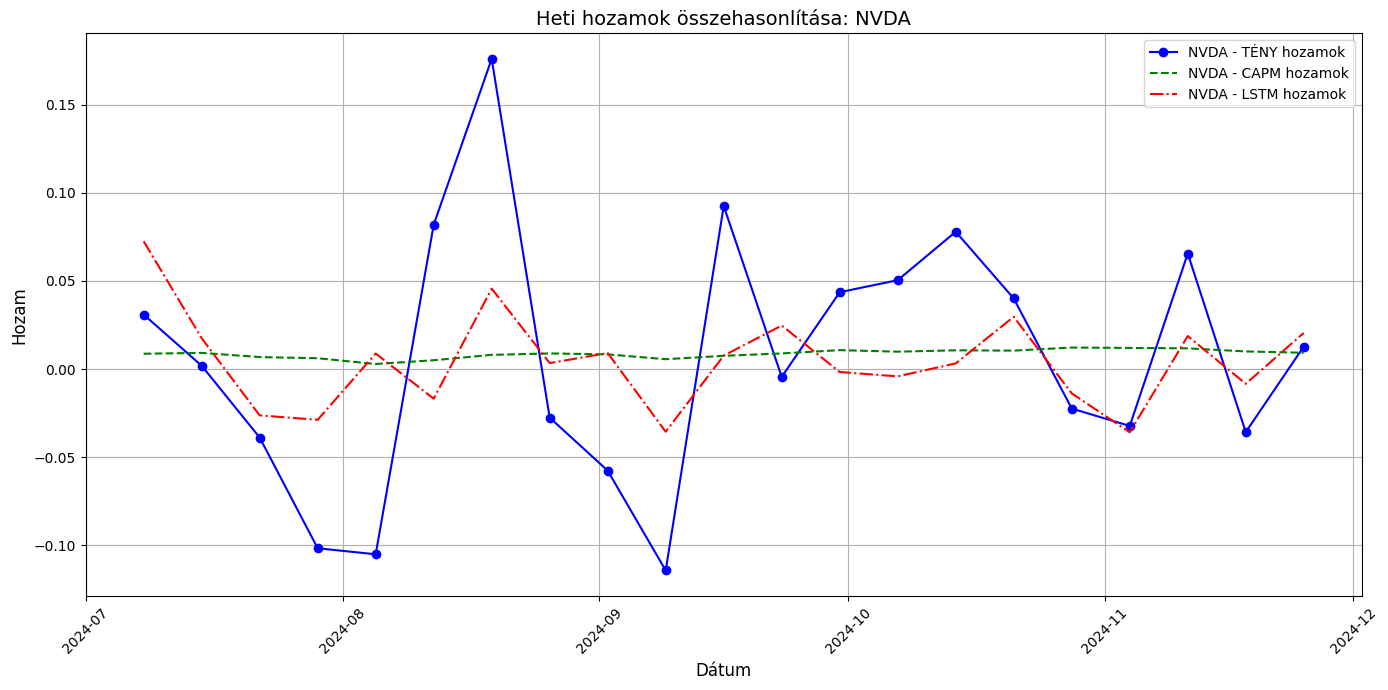

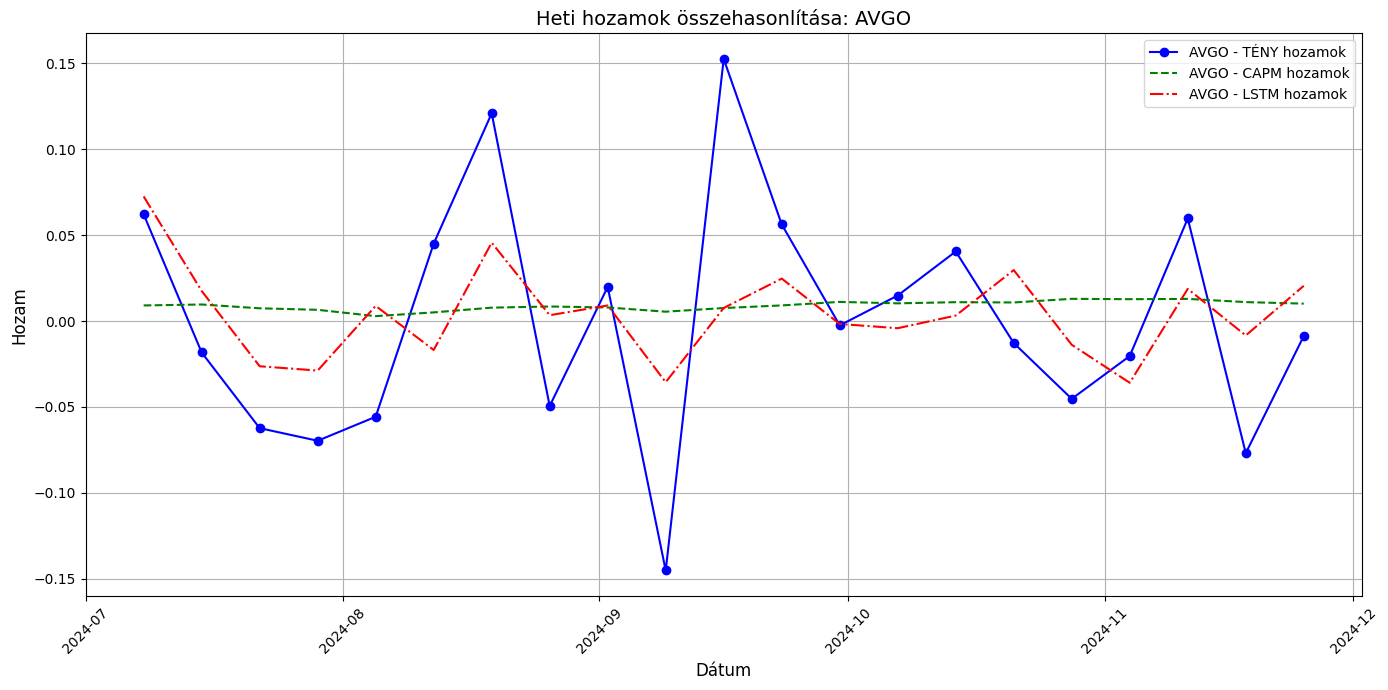

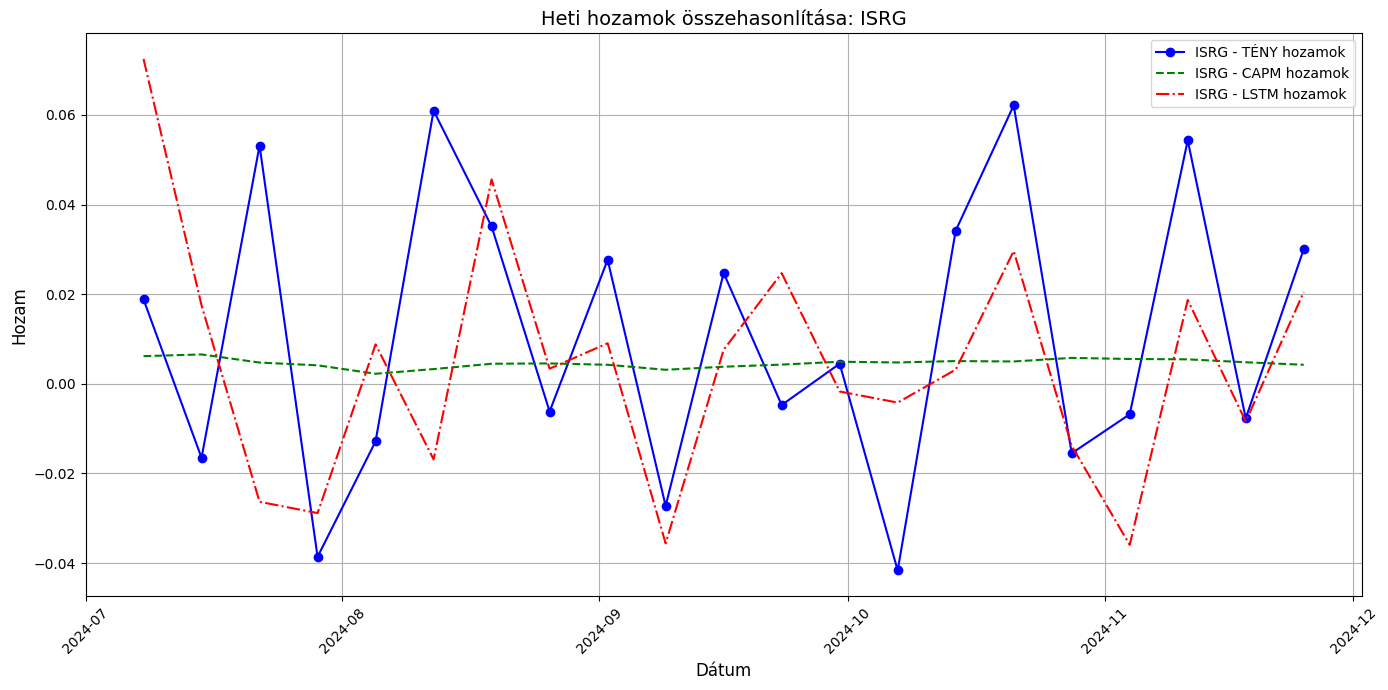

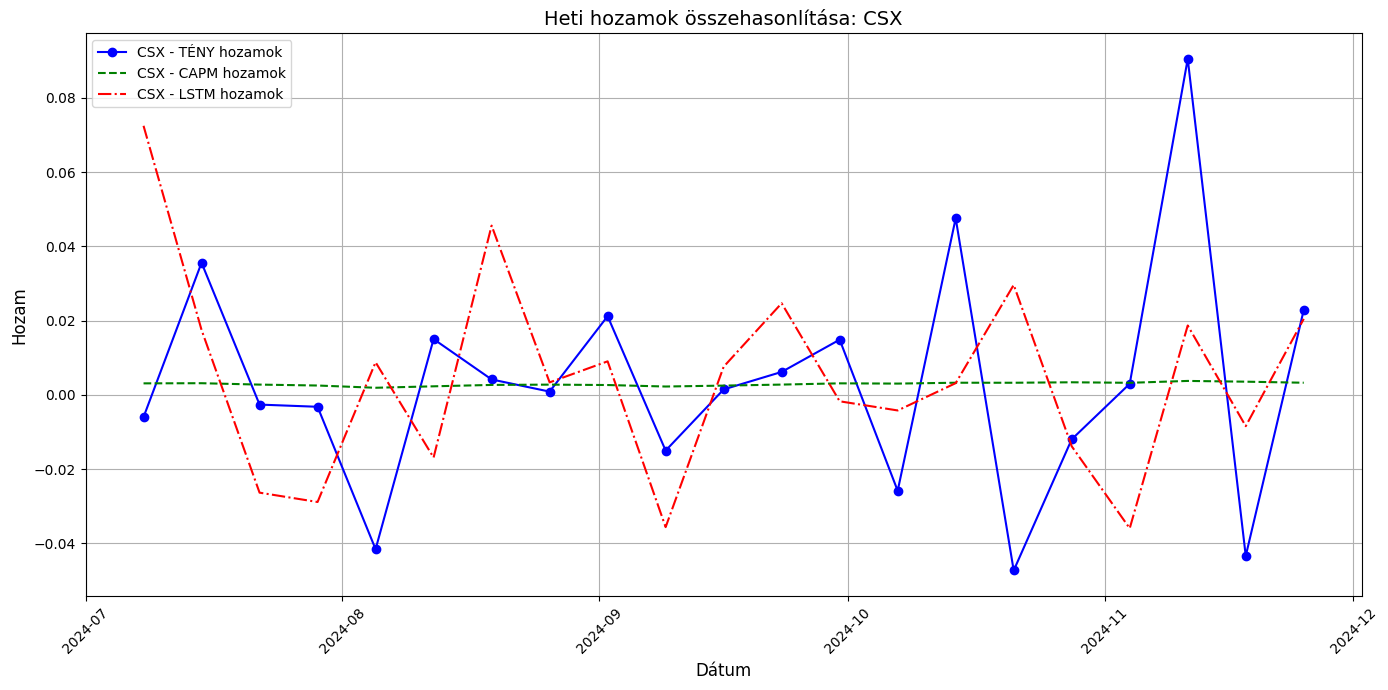

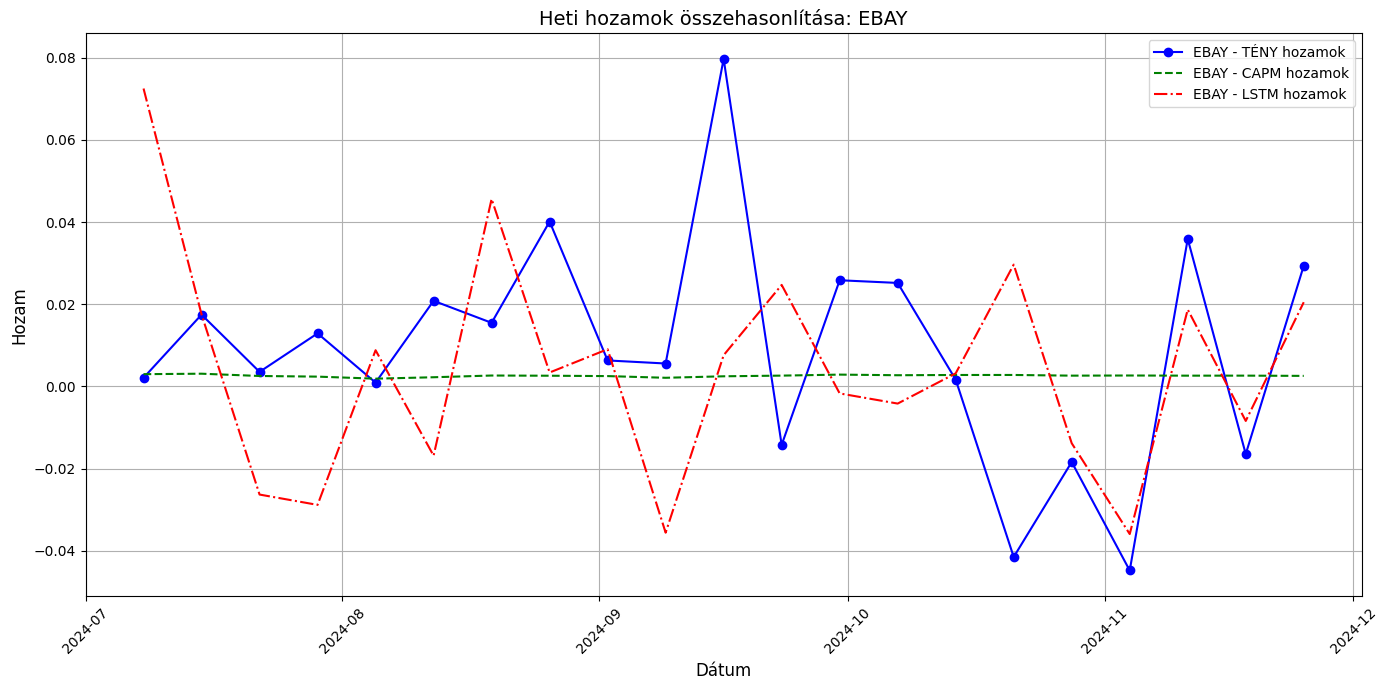

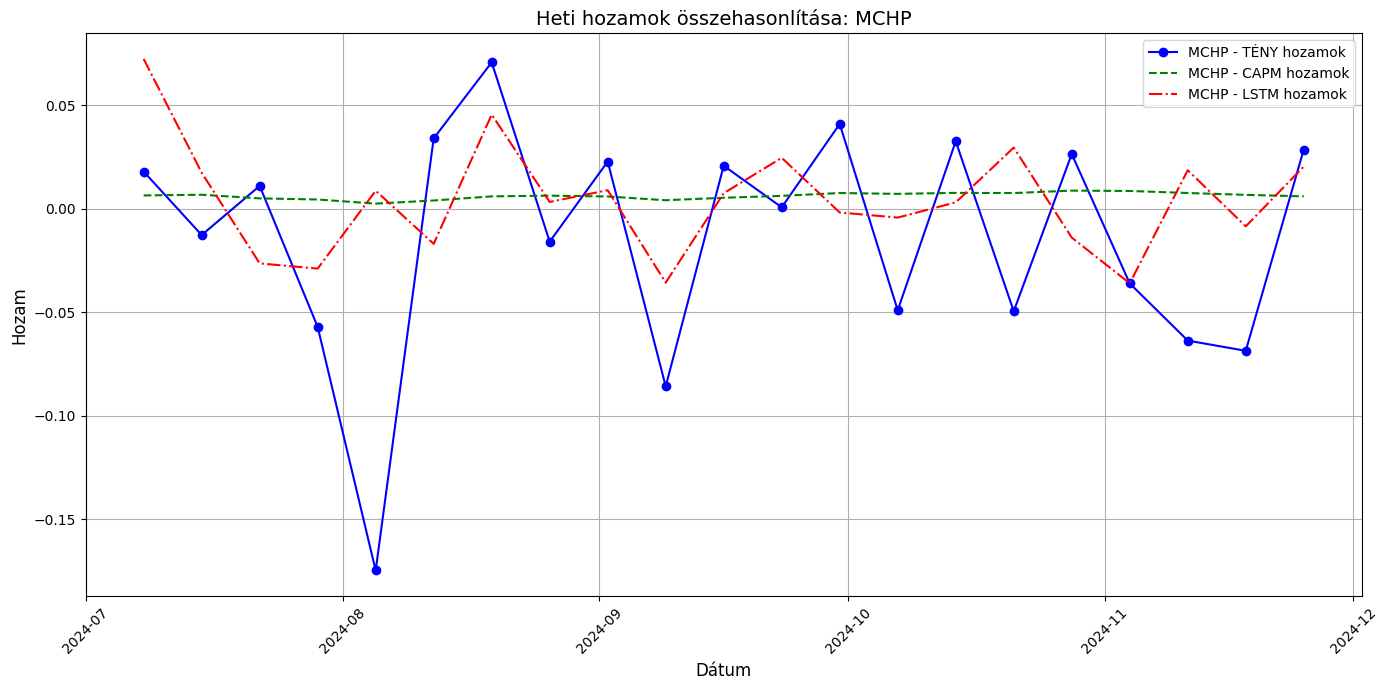

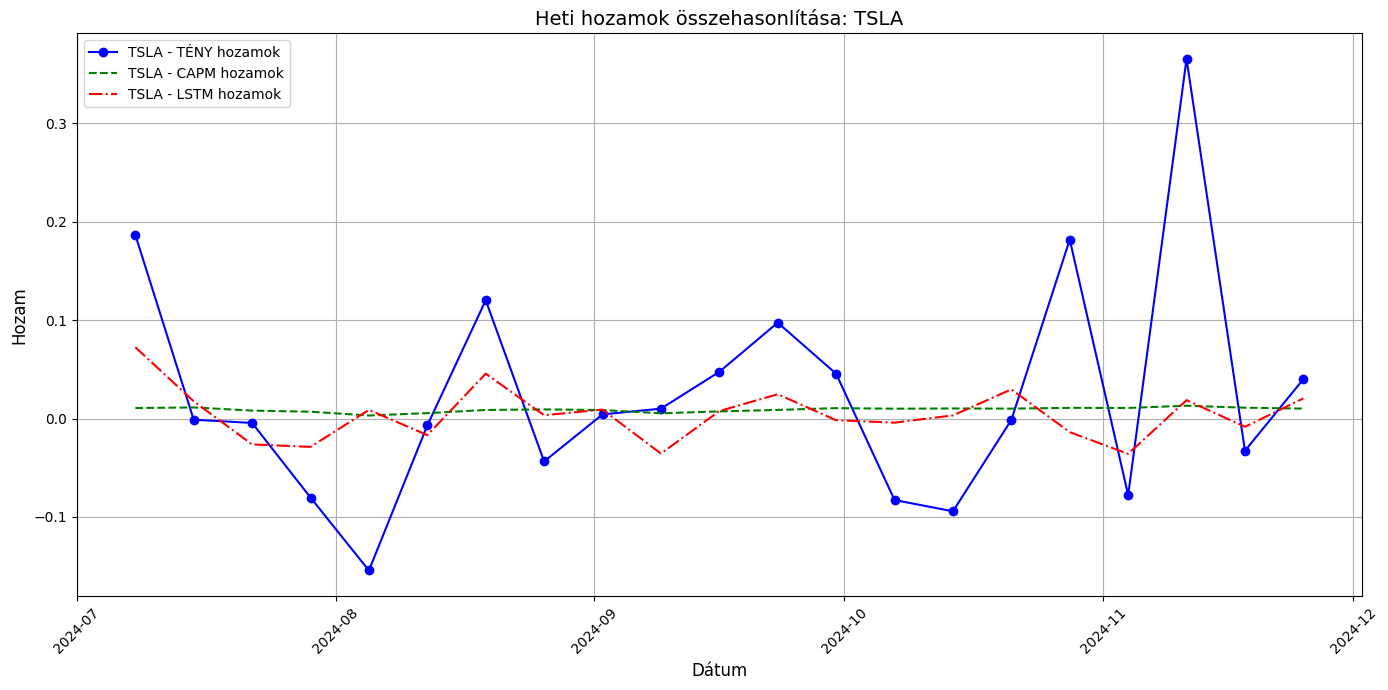

In [ ]:
# Excel fájlok beolvasása
actual_returns = pd.read_excel('actual_weekly_returns.xlsx', index_col=0)
capm_predictions = pd.read_excel('weekly_capm_predictions_2024.xlsx', index_col=0)
lstm_predictions = pd.read_excel('weekly_predictions_with_returns.xlsx', index_col=0)

# Ellenőrizzük, hogy a dátumok indexként szerepelnek-e, és konvertáljuk, ha szükséges
actual_returns.index = pd.to_datetime(actual_returns.index)
capm_predictions.index = pd.to_datetime(capm_predictions.index)

# Ellenőrizzük, hogy az LSTM fájl megfelelően van-e indexelve
if 'Week_Starting' in lstm_predictions.columns:
    lstm_predictions.set_index('Week_Starting', inplace=True)
lstm_predictions.index = pd.to_datetime(lstm_predictions.index)

# Ellenőrizzük a közös dátumokat
common_dates = actual_returns.index.intersection(capm_predictions.index).intersection(lstm_predictions.index)

# Csak a közös dátumokhoz tartozó adatokat használjuk
actual_returns_common = actual_returns.loc[common_dates]
capm_predictions_common = capm_predictions.loc[common_dates]
lstm_predictions_common = lstm_predictions.loc[common_dates]

# Grafikonok létrehozása minden részvényre
for stock in actual_returns.columns:
    plt.figure(figsize=(14, 7))

    # TÉNY hozamok
    plt.plot(actual_returns_common.index, actual_returns_common[stock], label=f"{stock} - TÉNY hozamok", color='blue', marker='o')

    # CAPM hozamok
    plt.plot(capm_predictions_common.index, capm_predictions_common[stock], label=f"{stock} - CAPM hozamok", color='green', linestyle='--')

    # LSTM hozamok
    if 'Log Return' in lstm_predictions_common.columns:
        plt.plot(lstm_predictions_common.index, lstm_predictions_common['Log Return'], label=f"{stock} - LSTM hozamok", color='red', linestyle='-.')

    # Beállítások a grafikonhoz
    plt.title(f"Heti hozamok összehasonlítása: {stock}", fontsize=14)
    plt.xlabel("Dátum", fontsize=12)
    plt.ylabel("Hozam", fontsize=12)
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)

    # Grafikon mentése fájlba és megjelenítése
    plt.tight_layout()
    plt.savefig(f"{stock}_returns_comparison.png")
    plt.show()
